In [ ]:
#####################################################################
#   PROJET 5 - Catégorisez automatiquement des questions            #
#-------------------------------------------------------------------#
#   NOTEBOOK DE TEST :                                              #
#      ---> test des différents modèles.                            #
#####################################################################

In [ ]:
#####################################################################
#   GITHUB                                                          #
#-------------------------------------------------------------------#
# GitHub              : https://github.com/irribarre                #
# Repository projet 5 : https://github.com/irribarre/Texte_1        #
# Notebook 2          : 2_notebook_test.ipynb                       #
#####################################################################

In [1]:
# Constantes
# Exécution sur google colab ou pas
C_EXECUTION_SUR_GOOGLE_COLAB = False  # False --> PC
                                      # True --> Google colab : https://colab.research.google.com/

In [ ]:
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    !pip install transformers

In [ ]:
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    import nltk
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')    

In [2]:
# built-in (librairie par défaut avec python)
import os

# Data
import pandas as pd
import numpy as np

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import tqdm
import pyLDAvis.gensim_models as gensimvis
import pickle  # Sauvegarde modèle
import pyLDAvis
import joblib

In [3]:
# Réduction de dimension
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

# Algorithmes
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC       # SVM
from sklearn.svm import LinearSVC # SVM
from sklearn.ensemble import RandomForestClassifier

# Métriques
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
from sklearn.metrics import jaccard_score
from sklearn.metrics import multilabel_confusion_matrix

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import itertools

# Time
import time
from time import perf_counter

In [4]:
# Sentence Embedding
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Lemmatizer (base d'un mot)

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

import transformers
#from transformers import *
from transformers import AutoTokenizer  # BERT
from transformers import TFAutoModel    # BERT HuggingFace

In [ ]:
# ------------------------------- Pour google colab -------------------------------
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    from google.colab import drive

In [ ]:
# Montage disques réseau avec google drive + demande autorisation connexion)
# Google drive : https://drive.google.com/drive/my-drive
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    drive.mount('/content/drive', force_remount = True)
    # vérification fichier
    !ls /content/drive/MyDrive/Colab_Notebooks/data_P5

In [5]:
# Constantes
# Google colab
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    C_DATASET_SOURCE  = '/content/drive/MyDrive/Colab_Notebooks/data_P5/source/'        
    C_DATASET_CLEANED = '/content/drive/MyDrive/Colab_Notebooks/data_P5/cleaned/'
    C_APP_MODELE      = '/content/drive/MyDrive/Colab_Notebooks/app_models/'       # modèles pré-entraînés pour
                                                                                   # l'application
    C_APP_PREPARATION = '/content/drive/MyDrive/Colab_Notebooks/app_preparation/'  # fichiers de préparation pour 
                                                                                   # l'application    
# PC
else:
    C_DATASET_SOURCE  = './data/source/'
    C_DATASET_CLEANED = './data/cleaned/'
    C_APP_MODELE      = './app_models/'       # modèles pré-entraînés pour l'application
    C_APP_PREPARATION = './app_preparation/'  # fichiers de préparation pour l'application

In [6]:
###############################################################
# Affichage durée programme                                   #
###############################################################
def affichage_duree_programme(time_start_sec, time_stop_sec) :
    
    # Delta time in seconds
    delta_time_sec = time_stop_sec - time_start_sec
    
    # Delta time in minutes
    delta_time_min = delta_time_sec / 60
    
    print('Durée programme (start : {:.3f}'.format(time_start_sec), '--> stop : {:.3f}'.format(time_stop_sec), ') = '
          '{:.3f}'.format(delta_time_sec), 'sec ou {:.3f}'.format(delta_time_min), 'min\n')

# 1. DONNEES

In [7]:
################################################
#      Chargement jeu de données               #
################################################
# Données nettoyées
df = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', sep = '\t')

# Données nettoyées réduites
df_light = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean_light.csv', sep = '\t')

In [8]:
print('df shape\t=', df.shape)
print('df_light shape\t=', df_light.shape)

df shape	= (49493, 7)
df_light shape	= (49493, 6)


In [9]:
df.columns

Index(['_Tag_1', '_Tag_2', '_Text_sans_html', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final'],
      dtype='object')

In [10]:
df_light.columns

Index(['_Tag_1', '_Tag_2', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final'],
      dtype='object')

# 1.1. CORPUS TEXTE

In [ ]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.

In [11]:
# Colonne _Stemmer_clean_final
corpus_stemmer = ' '.join(df['_Stemmer_clean_final'])

print('taille corpus_stemmer =', f"{len(corpus_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_stemmer[:1_000])

taille corpus_stemmer = 25,493,275 

perform class radio time process time process perform store configur load input web configur instanc partial trust solut add memori disk tell time final save disk handl load test perform get environ get environ set host solut solut server either server let bit add port servic get version load take get bit server build server turn client server servic bit bit servic instanc forward respons live let trust next time find load class class bit break view get find project project stack trace line either line call stack system string string system string express system string express system line add privat imag imag class free file light get add web project render render output get add render layout neat output get cut time forward submit contain web tomcat server environ set connector tomcat server file next filter request packag import java import public class filter public void destroy public void request respons chain request respons text chain request

In [12]:
# Colonne _Lemma_clean_final
corpus_lemma = ' '.join(df['_Lemma_clean_final'])

print('taille corpus_lemma =', f"{len(corpus_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_lemma[:1_000])

taille corpus_lemma = 30,543,818 

performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance get environment get environment setting hosting solution solution server either server let preference bit add port service get version loading take get bit server build server turn velocity lars client server service bit bit installation service architecture instance translate subscribe happy forward response live let trust enterprise reliability scalable intervention next time find loading designer class class bit break designer view designer get find assembly project project stack trace line either designer line call stack system serialization string string system serialization string expression system serialization string expression system serialization line add private image image class assembly difference summary summary free 

# 1.2. TOKEN TEXTE

In [13]:
# Colonne _Stemmer_clean_final
token_stemmer = corpus_stemmer.split()

print('taille token_stemmer =', f"{len(token_stemmer):,}")
print(token_stemmer[0:10])

taille token_stemmer = 4,065,752
['perform', 'class', 'radio', 'time', 'process', 'time', 'process', 'perform', 'store', 'configur']


In [14]:
# Colonne _Lemma_clean_final
token_lemma = corpus_lemma.split()

print('taille token_lemma =', f"{len(token_lemma):,}")
print(token_lemma[0:10])

taille token_lemma = 4,486,345
['performance', 'class', 'radio', 'time', 'process', 'time', 'process', 'performance', 'store', 'configuration']


In [262]:
##########################################
#        DISTRIBUTION DES TOKENS         #
##########################################

In [15]:
count_stemmer = pd.Series(token_stemmer).value_counts()

# Nombre de valeurs uniques
print('count_stemmer :', len(count_stemmer), 'valeurs uniques')

count_stemmer : 1633 valeurs uniques


In [16]:
# Affichage des 20 premiers éléments
count = 0

for idx, name in enumerate(count_stemmer.index.tolist()):
    if (count < 20):
        print(count_stemmer[idx], "\t:", name)
    else:
        break
    count = count + 1

137644 	: java
101731 	: android
95023 	: class
78751 	: public
69621 	: file
69017 	: string
67360 	: return
66939 	: get
50016 	: function
46770 	: import
43116 	: self
42556 	: set
41392 	: system
39819 	: void
39817 	: version
35068 	: null
33585 	: server
33213 	: build
32617 	: text
32271 	: time


In [17]:
count_lemma = pd.Series(token_lemma).value_counts()

# Nombre de valeurs uniques
print('count_lemma :', len(count_lemma), 'valeurs uniques')

count_lemma : 2818 valeurs uniques


In [18]:
# Affichage des 20 premiers éléments
count = 0

for idx, name in enumerate(count_lemma.index.tolist()):
    if (count < 20):
        print(count_lemma[idx], "\t:", name)
    else:
        break
    count = count + 1

137644 	: java
101731 	: android
95023 	: class
78751 	: public
69621 	: file
69017 	: string
67360 	: return
66939 	: get
50016 	: function
46770 	: import
43116 	: self
41392 	: system
39819 	: void
39817 	: version
37698 	: set
35068 	: null
33585 	: server
32617 	: text
32248 	: object
31057 	: time


# 1.3. CORPUS LISTE DOC

In [ ]:
# https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
##############################################
#   Corpus sous forme de liste de documents  #
##############################################

In [19]:
corpus_liste_doc_stemmer   = []
corpus_liste_doc_lemma     = []

# Updating corpus list : one string for one document :
# corpus = ['This is the first document.',
#           'This document is the second document.',
#           'And this is the third one.',
#           'Is this the first document?']

for index, row in df.iterrows():
    corpus_liste_doc_stemmer.append(row['_Stemmer_clean_final'])
    corpus_liste_doc_lemma.append(row['_Lemma_clean_final'])

In [20]:
print('taille corpus_liste_doc_stemmer =', f"{len(corpus_liste_doc_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_stemmer[:5]) # 5 premiers éléments de la liste

taille corpus_liste_doc_stemmer = 49,493 

['perform class radio time process time process perform store configur load input web configur instanc partial trust solut add memori disk tell time final save disk handl load test perform', 'get environ get environ set host solut solut server either server let bit add port servic get version load take get bit server build server turn client server servic bit bit servic instanc forward respons live let trust next time', 'find load class class bit break view get find project project stack trace line either line call stack system string string system string express system string express system line add privat imag imag class', 'free file light get add web project render render output get add render layout neat output get cut time forward', 'submit contain web tomcat server environ set connector tomcat server file next filter request packag import java import public class filter public void destroy public void request respons chain request respon

In [21]:
print('taille corpus_liste_doc_lemma =', f"{len(corpus_liste_doc_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_lemma[:5])  # 5 premiers éléments de la liste

taille corpus_liste_doc_lemma = 49,493 

['performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance', 'get environment get environment setting hosting solution solution server either server let preference bit add port service get version loading take get bit server build server turn velocity lars client server service bit bit installation service architecture instance translate subscribe happy forward response live let trust enterprise reliability scalable intervention next time', 'find loading designer class class bit break designer view designer get find assembly project project stack trace line either designer line call stack system serialization string string system serialization string expression system serialization string expression system serialization line add private image image class assembly difference', 'summ

# 1.4. TAGS : CORPUS & TOKENS

In [22]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
corpus_tags_1 = ' '.join(df['_Tag_1'])
corpus_tags_1[:500]

'c# c# c# c# java python .net python java c# python java c# java c# c# sql c# c# java java javascript .net python python asp.net c# c# c# php c++ c# c++ jquery java c# windows java c# ruby-on-rails python java c java c# java html c++ javascript python performance c# c++ javascript php c++ java c++ java html java c# java javascript .net php sql asp.net .net java windows c++ c# html c# javascript .net asp.net java java c objective-c windows php c# .net .net java performance c++ java java c# sql c++'

In [23]:
corpus_tags_2 = ' '.join(df['_Tag_2'])
corpus_tags_2[:500]

'.net c++ .net .net jquery linux performance sql no_tag .net sql c++ no_tag no_tag no_tag no_tag no_tag .net .net no_tag no_tag jquery no_tag no_tag no_tag no_tag no_tag no_tag .net performance c .net no_tag no_tag no_tag no_tag no_tag spring performance mysql no_tag c# no_tag spring .net no_tag no_tag no_tag jquery mysql no_tag sql windows html no_tag no_tag no_tag no_tag no_tag css no_tag .net spring no_tag no_tag no_tag no_tag no_tag no_tag c++ no_tag no_tag asp.net css no_tag no_tag asp.net n'

In [24]:
corpus_tags = corpus_tags_1 + ' ' + corpus_tags_2
corpus_tags[len(corpus_tags_1) - 100: len(corpus_tags_1) + 200] # affichage corpus à cheval entre corpus_1 et corpus_2

'va java javascript javascript c++ ios python c++ linux c++ javascript android ruby-on-rails java ios .net c++ .net .net jquery linux performance sql no_tag .net sql c++ no_tag no_tag no_tag no_tag no_tag .net .net no_tag no_tag jquery no_tag no_tag no_tag no_tag no_tag no_tag .net performance c .net'

In [25]:
###########################
# Corpus au format token  #
###########################
token_tags = corpus_tags.split()
len(token_tags)

98986

In [26]:
print(token_tags[0:40])

['c#', 'c#', 'c#', 'c#', 'java', 'python', '.net', 'python', 'java', 'c#', 'python', 'java', 'c#', 'java', 'c#', 'c#', 'sql', 'c#', 'c#', 'java', 'java', 'javascript', '.net', 'python', 'python', 'asp.net', 'c#', 'c#', 'c#', 'php', 'c++', 'c#', 'c++', 'jquery', 'java', 'c#', 'windows', 'java', 'c#', 'ruby-on-rails']


In [27]:
count_tags = pd.Series(token_tags).value_counts()
count_tags

no_tag           30878
java              8749
python            6803
c#                6588
javascript        6540
android           5578
c++               4262
ios               2806
.net              2480
html              2224
php               2210
node.js           2091
spring            2086
c                 1565
jquery            1331
performance       1228
reactjs           1163
ruby-on-rails     1112
asp.net           1107
objective-c       1093
linux             1084
sql                978
swift              906
css                885
mysql              823
json               814
windows            704
iphone             560
xcode              338
Name: count, dtype: int64

In [28]:
# Nombre de valeurs uniques
print('count_tags :', len(count_tags), 'valeurs uniques')

count_tags : 29 valeurs uniques


In [29]:
liste_tags = count_tags.index.tolist()
print(liste_tags)

['no_tag', 'java', 'python', 'c#', 'javascript', 'android', 'c++', 'ios', '.net', 'html', 'php', 'node.js', 'spring', 'c', 'jquery', 'performance', 'reactjs', 'ruby-on-rails', 'asp.net', 'objective-c', 'linux', 'sql', 'swift', 'css', 'mysql', 'json', 'windows', 'iphone', 'xcode']


# 2. MACHINE LEARNING NON SUPERVISE

# 2.1. TF-IDF

In [30]:
# https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

#############################################
#               TF-IDF matrix               #
#############################################
def tf_idf_matrix(corpus_liste_doc_in):
    # TF-IDF matrix
    tfidfvectorizer = TfidfVectorizer()
    train_data = tfidfvectorizer.fit_transform(corpus_liste_doc_in)

    sparsity = 1 - train_data.size / (train_data.shape[0] * train_data.shape[1])
    print("Sparsity =", sparsity)
    
    return tfidfvectorizer, train_data

In [31]:
# TF-IDF matrix du corpus corpus_stemmer
tfidfvectorizer_stemmer, train_data_stemmer = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_stemmer)

Sparsity = 0.9845187086215276


In [32]:
# TF-IDF matrix du corpus corpus_lemma
tfidfvectorizer_lemma, train_data_lemma = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_lemma)

Sparsity = 0.9895762477942232


# 2.2. TOPIC MODEL AVEC LDA (LATENT DIRICHLET ALLOCATION)

# 2.2.1. METHODE 1

In [ ]:
# Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data,
# which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.

In [33]:
################################################################
#    Topic modeling using LDA (Latent Dirichlet Allocation)    #
################################################################
# https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
# https://www.pluralsight.com/guides/topic-identification-nlp
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

# num_components_in = number of topics or components
def topic_modeling_with_LDA(normalization_type_in,
                            num_components_in, 
                            num_word_per_topic_in, 
                            tfidfvectorizer_in, 
                            train_data_in):
    
    # Generate TF-IDF Features
    ###################################
    #          Perform LDA            #
    ###################################
    # Create LDA object
    model = LatentDirichletAllocation(n_components = num_components_in)
    
    # Fit and Transform SVD model on data
    lda_matrix = model.fit_transform(train_data_in)

    # Get Components 
    lda_components = model.components_
    
    
    ###################################
    #   Extract topics and terms      #
    ###################################
    # Print the topics with their terms
    terms = tfidfvectorizer_in.get_feature_names()
    
    
    # affichage
    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
        top_terms_list = list(dict(top_terms_key).keys())
        print("Topic " + str(index) + " : " , top_terms_list)
        
    return lda_components, terms

In [34]:
dict_tags = {}
for tag in liste_tags:
    dict_tags[tag] = 0
    print(tag, dict_tags[tag] )

no_tag 0
java 0
python 0
c# 0
javascript 0
android 0
c++ 0
ios 0
.net 0
html 0
php 0
node.js 0
spring 0
c 0
jquery 0
performance 0
reactjs 0
ruby-on-rails 0
asp.net 0
objective-c 0
linux 0
sql 0
swift 0
css 0
mysql 0
json 0
windows 0
iphone 0
xcode 0


In [39]:
def graphique_topic_modeling_with_LDA(normalization_type_in, num_word_per_topic_in, lda_components_in, terms_in):
    
    # Dictionnaire avec le nombre de tags rencontrés
    dict_tags = {}
    
    
    for index_topic, component in enumerate(lda_components_in):
            zipped = zip(terms_in, component)
            top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
            top_terms_list = list(dict(top_terms_key).keys())
            print('\n\n', '@' * 100)
            print('Topic ' + str(index_topic) + ' : ' , top_terms_list, '\n')
        
        
            # Initialisation d'un dictionnaire avec le nombre de tags rencontrés (avant d'étudier chaque
            # nouvelle liste de mots)
            for tag in liste_tags:
                dict_tags[tag] = 0
        
        
            for word in top_terms_list:
                if (normalization_type_in == 'lemma'):
                    colonne = '_Tokens_lemma_clean_final'
                else:
                    colonne = '_Tokens_stemmer_clean_final'

                # sous-dataframe contenant le mot
                df_word = df[df[colonne].str.contains(word)]
                print('word =', word, ', df_word.shape =', df_word.shape)
                
                # Parcours des lignes contenant le mot pour comptage
                for index_word, row in df_word.iterrows():
                    tag_1 = row['_Tag_1']
                    tag_2 = row['_Tag_2']
            
                    dict_tags[tag_1] = dict_tags[tag_1] + 1
                    dict_tags[tag_2] = dict_tags[tag_2] + 1            
                print('word =', word, ', _Tag_1 =', dict_tags[tag_1], ', _Tag_2 =', dict_tags[tag_2])
            
            print('\ndict_tags =', dict_tags, '\n')
            
            
            # Affichage graphique
            plt.figure(figsize = (12, 4))

            # Suppression des tags vides et des éléments les plus rares. 
            # https://www.mypycode.com/fr/Python/1001006101.html
            for key, value in dict(dict_tags).items():
                if ((key == 'no_tag') | (value <= 2000)):
                    del dict_tags[key]

            myList = dict_tags.items()
            print(myList)
            myList = sorted(myList) 
            x, y = zip(*myList) 

            # couleur
            if (normalization_type_in == 'lemma'):
                color = 'red'
            elif(normalization_type_in == 'stemmer'):
                color = 'green'
                
            plt.plot(x, y, marker = 'o', color = color)
            plt.xticks(rotation = 90)
            plt.xlabel('Key')
            plt.ylabel('Value')
            plt.title('Tags ' + normalization_type_in + ' - topic ' + str(index_topic) + ' : ' + str(top_terms_list))
            plt.show() 

In [176]:
####################################
# LDA corpus stemmer               #
####################################

In [40]:
lda_components_stemmer, terms_stemmer = topic_modeling_with_LDA(normalization_type_in = 'stemmer',
                                                                num_components_in     = 8, 
                                                                num_word_per_topic_in = 12, 
                                                                tfidfvectorizer_in    = tfidfvectorizer_stemmer, 
                                                                train_data_in         = train_data_stemmer)  # 4 min

Topic 0 :  ['self', 'view', 'let', 'string', 'public', 'void', 'class', 'return', 'text', 'import', 'cell', 'audio']
Topic 1 :  ['video', 'import', 'time', 'date', 'flask', 'file', 'function', 'scala', 'python', 'frame', 'stream', 'min']
Topic 2 :  ['imag', 'class', 'width', 'text', 'height', 'button', 'function', 'input', 'label', 'size', 'window', 'background']
Topic 3 :  ['file', 'build', 'python', 'modul', 'project', 'line', 'path', 'local', 'version', 'bin', 'import', 'command']
Topic 4 :  ['request', 'server', 'respons', 'client', 'connect', 'token', 'function', 'post', 'consol', 'file', 'messag', 'get']
Topic 5 :  ['android', 'java', 'layout', 'apach', 'spring', 'jar', 'public', 'version', 'class', 'hibern', 'boot', 'sun']
Topic 6 :  ['memori', 'class', 'function', 'return', 'string', 'void', 'public', 'char', 'includ', 'static', 'time', 'size']
Topic 7 :  ['public', 'string', 'model', 'class', 'system', 'entiti', 'get', 'null', 'return', 'privat', 'set', 'key']


C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['self', 'view', 'let', 'string', 'public', 'void', 'class', 'return', 'text', 'import', 'cell', 'audio'] 

word = self , df_word.shape = (5083, 7)
word = self , _Tag_1 = 1359 , _Tag_2 = 555
word = view , df_word.shape = (7450, 7)
word = view , _Tag_1 = 1258 , _Tag_2 = 7419
word = let , df_word.shape = (6406, 7)
word = let , _Tag_1 = 3390 , _Tag_2 = 1630
word = string , df_word.shape = (14963, 7)
word = string , _Tag_1 = 3972 , _Tag_2 = 2012
word = public , df_word.shape = (14540, 7)
word = public , _Tag_1 = 4187 , _Tag_2 = 2104
word = void , df_word.shape = (12246, 7)
word = void , _Tag_1 = 5023 , _Tag_2 = 2260
word = class , df_word.shape = (21176, 7)
word = class , _Tag_1 = 5879 , _Tag_2 = 2680
word = return , df_word.shape = (20538, 7)
word = return , _Tag_1 = 6928 , _Tag_2 = 3146
word = text , df_word.shape = (9076, 7)
word = text , _Tag_1 = 16253 , _Tag_2 = 66730
wor

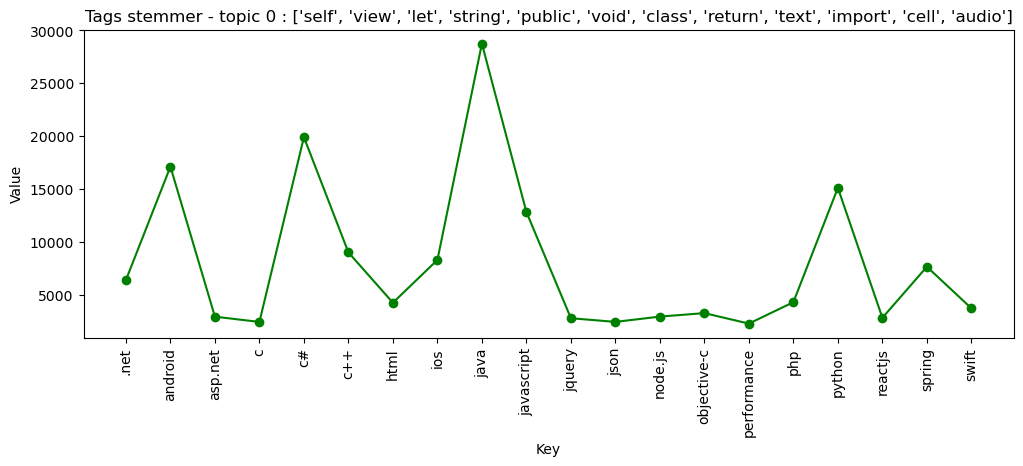



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['video', 'import', 'time', 'date', 'flask', 'file', 'function', 'scala', 'python', 'frame', 'stream', 'min'] 

word = video , df_word.shape = (1284, 7)
word = video , _Tag_1 = 143 , _Tag_2 = 727
word = import , df_word.shape = (8531, 7)
word = import , _Tag_1 = 1862 , _Tag_2 = 955
word = time , df_word.shape = (13077, 7)
word = time , _Tag_1 = 3971 , _Tag_2 = 14696
word = date , df_word.shape = (3305, 7)
word = date , _Tag_1 = 6525 , _Tag_2 = 554
word = flask , df_word.shape = (407, 7)
word = flask , _Tag_1 = 6908 , _Tag_2 = 16913
word = file , df_word.shape = (15560, 7)
word = file , _Tag_1 = 7282 , _Tag_2 = 26957
word = function , df_word.shape = (13460, 7)
word = function , _Tag_1 = 9554 , _Tag_2 = 1653
word = scala , df_word.shape = (471, 7)
word = scala , _Tag_1 = 11964 , _Tag_2 = 35066
word = python , df_word.shape = (4876, 7)
word = python , _Tag_1 = 949 , _Tag_2 =

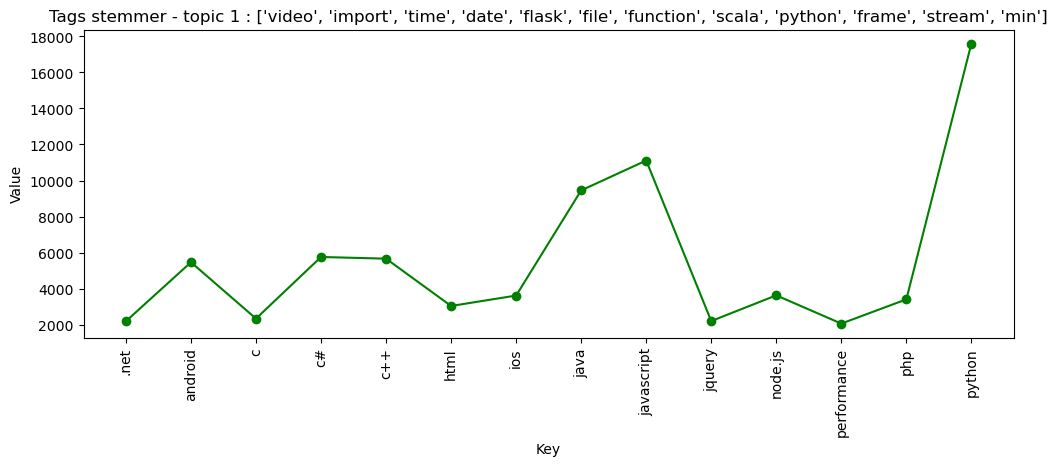



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['imag', 'class', 'width', 'text', 'height', 'button', 'function', 'input', 'label', 'size', 'window', 'background'] 

word = imag , df_word.shape = (4938, 7)
word = imag , _Tag_1 = 855 , _Tag_2 = 2936
word = class , df_word.shape = (21176, 7)
word = class , _Tag_1 = 1427 , _Tag_2 = 590
word = width , df_word.shape = (4954, 7)
word = width , _Tag_1 = 3245 , _Tag_2 = 254
word = text , df_word.shape = (9076, 7)
word = text , _Tag_1 = 6150 , _Tag_2 = 23091
word = height , df_word.shape = (4414, 7)
word = height , _Tag_1 = 4586 , _Tag_2 = 390
word = button , df_word.shape = (4379, 7)
word = button , _Tag_1 = 3390 , _Tag_2 = 1261
word = function , df_word.shape = (13460, 7)
word = function , _Tag_1 = 13220 , _Tag_2 = 1030
word = input , df_word.shape = (5664, 7)
word = input , _Tag_1 = 14490 , _Tag_2 = 1168
word = label , df_word.shape = (2400, 7)
word = label , _Tag_1 = 4232 ,

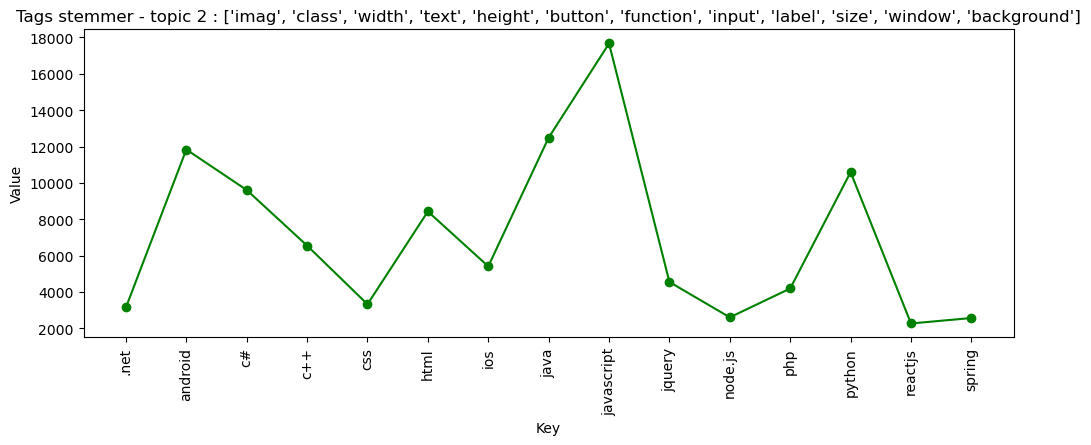



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['file', 'build', 'python', 'modul', 'project', 'line', 'path', 'local', 'version', 'bin', 'import', 'command'] 

word = file , df_word.shape = (15560, 7)
word = file , _Tag_1 = 2703 , _Tag_2 = 10044
word = build , df_word.shape = (9701, 7)
word = build , _Tag_1 = 755 , _Tag_2 = 16347
word = python , df_word.shape = (4876, 7)
word = python , _Tag_1 = 767 , _Tag_2 = 20189
word = modul , df_word.shape = (5141, 7)
word = modul , _Tag_1 = 5640 , _Tag_2 = 4010
word = project , df_word.shape = (8565, 7)
word = project , _Tag_1 = 7640 , _Tag_2 = 28971
word = line , df_word.shape = (8443, 7)
word = line , _Tag_1 = 5855 , _Tag_2 = 856
word = path , df_word.shape = (7222, 7)
word = path , _Tag_1 = 1573 , _Tag_2 = 39217
word = local , df_word.shape = (5088, 7)
word = local , _Tag_1 = 1793 , _Tag_2 = 42721
word = version , df_word.shape = (11308, 7)
word = version , _Tag_1 = 2050 , _T

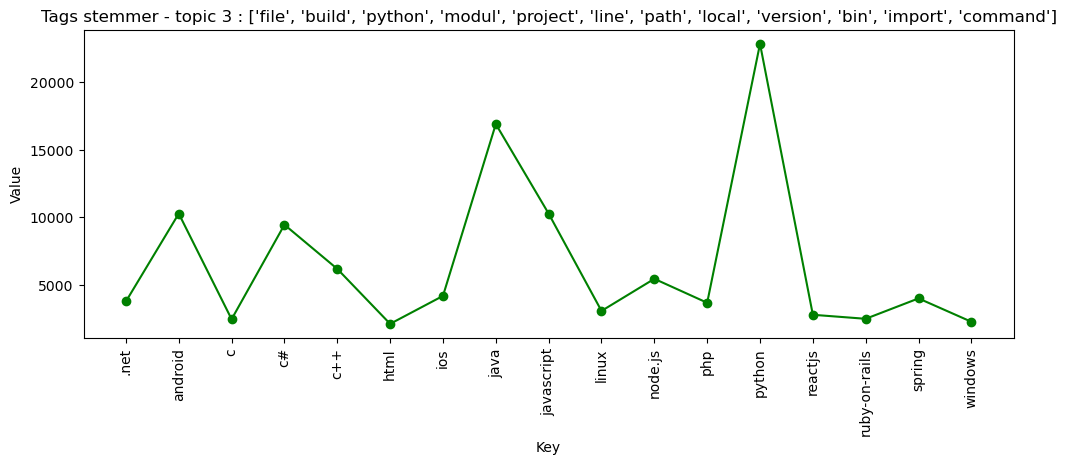



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['request', 'server', 'respons', 'client', 'connect', 'token', 'function', 'post', 'consol', 'file', 'messag', 'get'] 

word = request , df_word.shape = (7349, 7)
word = request , _Tag_1 = 350 , _Tag_2 = 140
word = server , df_word.shape = (9615, 7)
word = server , _Tag_1 = 2699 , _Tag_2 = 10094
word = respons , df_word.shape = (5481, 7)
word = respons , _Tag_1 = 966 , _Tag_2 = 315
word = client , df_word.shape = (5774, 7)
word = client , _Tag_1 = 5775 , _Tag_2 = 16793
word = connect , df_word.shape = (6370, 7)
word = connect , _Tag_1 = 438 , _Tag_2 = 20663
word = token , df_word.shape = (2275, 7)
word = token , _Tag_1 = 1097 , _Tag_2 = 22140
word = function , df_word.shape = (13460, 7)
word = function , _Tag_1 = 9977 , _Tag_2 = 878
word = post , df_word.shape = (6955, 7)
word = post , _Tag_1 = 7247 , _Tag_2 = 33768
word = consol , df_word.shape = (5511, 7)
word = consol ,

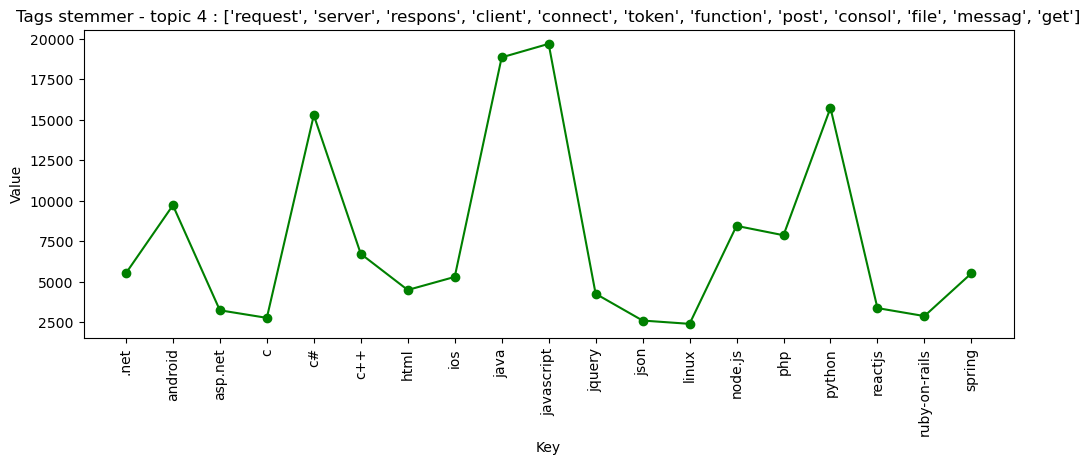



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['android', 'java', 'layout', 'apach', 'spring', 'jar', 'public', 'version', 'class', 'hibern', 'boot', 'sun'] 

word = android , df_word.shape = (5536, 7)
word = android , _Tag_1 = 4949 , _Tag_2 = 3478
word = java , df_word.shape = (8634, 7)
word = java , _Tag_1 = 7680 , _Tag_2 = 9052
word = layout , df_word.shape = (3336, 7)
word = layout , _Tag_1 = 370 , _Tag_2 = 11209
word = apach , df_word.shape = (2512, 7)
word = apach , _Tag_1 = 10056 , _Tag_2 = 12862
word = spring , df_word.shape = (2812, 7)
word = spring , _Tag_1 = 12255 , _Tag_2 = 13988
word = jar , df_word.shape = (1907, 7)
word = jar , _Tag_1 = 9956 , _Tag_2 = 15313
word = public , df_word.shape = (14540, 7)
word = public , _Tag_1 = 688 , _Tag_2 = 167
word = version , df_word.shape = (11308, 7)
word = version , _Tag_1 = 502 , _Tag_2 = 31735
word = class , df_word.shape = (21176, 7)
word = class , _Tag_1 = 2011 

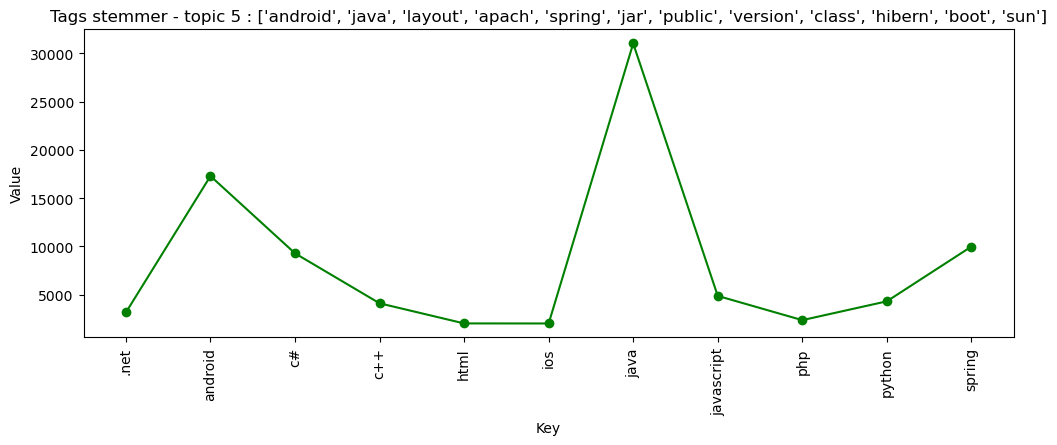



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['memori', 'class', 'function', 'return', 'string', 'void', 'public', 'char', 'includ', 'static', 'time', 'size'] 

word = memori , df_word.shape = (3726, 7)
word = memori , _Tag_1 = 807 , _Tag_2 = 2379
word = class , df_word.shape = (21176, 7)
word = class , _Tag_1 = 1056 , _Tag_2 = 456
word = function , df_word.shape = (13460, 7)
word = function , _Tag_1 = 6869 , _Tag_2 = 1011
word = return , df_word.shape = (20538, 7)
word = return , _Tag_1 = 2588 , _Tag_2 = 1127
word = string , df_word.shape = (14963, 7)
word = string , _Tag_1 = 3170 , _Tag_2 = 1509
word = void , df_word.shape = (12246, 7)
word = void , _Tag_1 = 4006 , _Tag_2 = 1665
word = public , df_word.shape = (14540, 7)
word = public , _Tag_1 = 4221 , _Tag_2 = 1757
word = char , df_word.shape = (2153, 7)
word = char , _Tag_1 = 11435 , _Tag_2 = 62354
word = includ , df_word.shape = (5924, 7)
word = includ , _Tag_1 

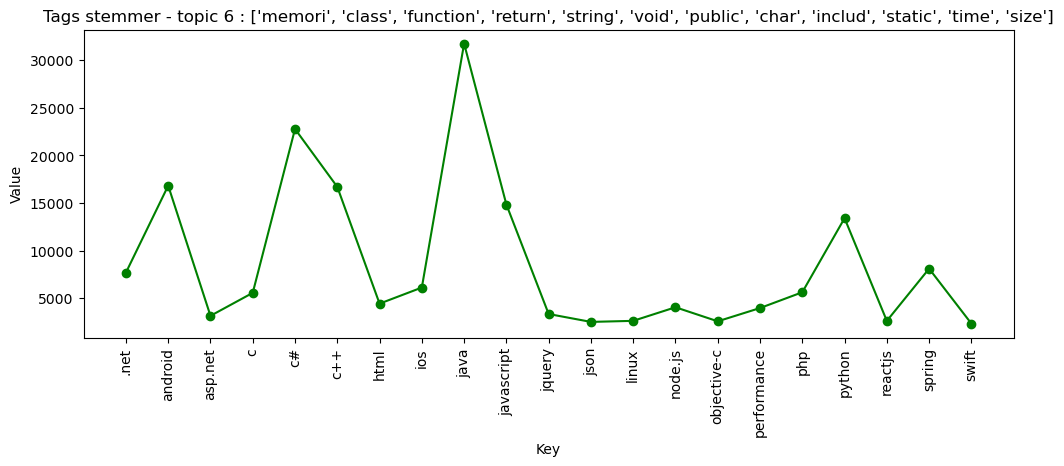



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['public', 'string', 'model', 'class', 'system', 'entiti', 'get', 'null', 'return', 'privat', 'set', 'key'] 

word = public , df_word.shape = (14540, 7)
word = public , _Tag_1 = 215 , _Tag_2 = 92
word = string , df_word.shape = (14963, 7)
word = string , _Tag_1 = 797 , _Tag_2 = 474
word = model , df_word.shape = (5123, 7)
word = model , _Tag_1 = 10793 , _Tag_2 = 21528
word = class , df_word.shape = (21176, 7)
word = class , _Tag_1 = 1801 , _Tag_2 = 955
word = system , df_word.shape = (9712, 7)
word = system , _Tag_1 = 19173 , _Tag_2 = 40314
word = entiti , df_word.shape = (2462, 7)
word = entiti , _Tag_1 = 20147 , _Tag_2 = 5633
word = get , df_word.shape = (28041, 7)
word = get , _Tag_1 = 3705 , _Tag_2 = 1537
word = null , df_word.shape = (9925, 7)
word = null , _Tag_1 = 27872 , _Tag_2 = 14073
word = return , df_word.shape = (20538, 7)
word = return , _Tag_1 = 5018 , _Tag_

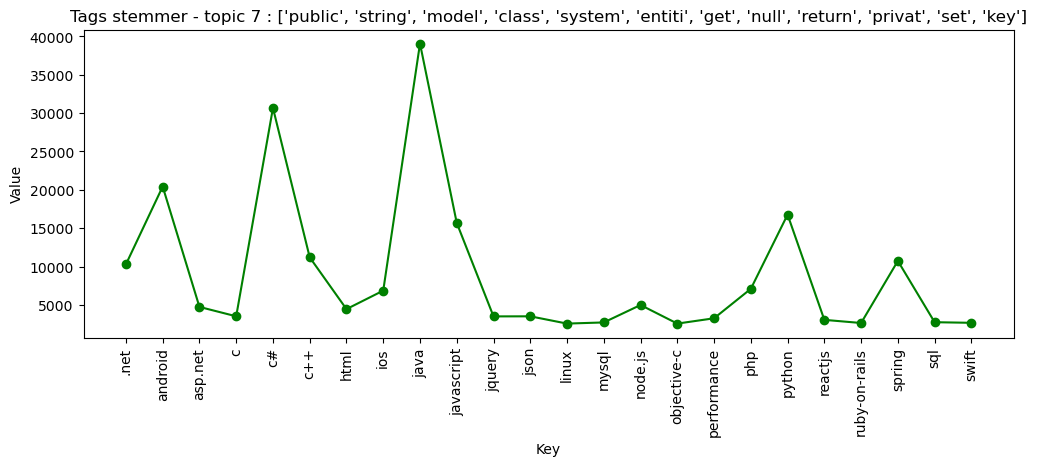

In [41]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'stemmer', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_stemmer, 
                                  terms_in              = terms_stemmer)

In [ ]:
##################################################################
# ANALYSE GRAPHIQUE STEMMER :                                    #
# Synthèse des 5 premiers tags fournis par LDA pour chaque topic #
################################################################## 
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 0 :  ['self', 'view', 'let', 'string', 'public', 'void', 'class', 'return', 'text', 'import', 'cell', 'audio'] 
# 
# ('java',       28742)
# ('python',     15113)
# ('c#',         19899)
# ('javascript', 12830)
# ('android',    17117)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 1 :  ['video', 'import', 'time', 'date', 'flask', 'file', 'function', 'scala', 'python', 'frame', 'stream', 'min'] 
# 
# ('java',        9452)
# ('python',     17602)
# ('c#',          5755)
# ('javascript', 11111)
# ('android',     5463)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 2 :  ['imag', 'class', 'width', 'text', 'height', 'button', 'function', 'input', 'label', 'size', 'window', 'background'] 
# 
# ('java',       12490)
# ('python',     10592)
# ('c#',          9610)
# ('javascript', 17670)
# ('android',    11837)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 3 :  ['file', 'build', 'python', 'modul', 'project', 'line', 'path', 'local', 'version', 'bin', 'import', 'command'] 
# 
# ('java',       16900)
# ('python',     22829)
# ('c#',          9462)
# ('javascript', 10281)
# ('android',    10283)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 4 :  ['request', 'server', 'respons', 'client', 'connect', 'token', 'function', 'post', 'consol', 'file', 'messag', 'get'] 
# 
# ('java',       18863)
# ('python',     15742)
# ('c#',         15291)
# ('javascript', 19698)
# ('android',     9725)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 5 :  ['android', 'java', 'layout', 'apach', 'spring', 'jar', 'public', 'version', 'class', 'hibern', 'boot', 'sun'] 
# 
# ('java',       31011)
# ('python',      4320)
# ('c#',          9287)
# ('javascript',  4881)
# ('android',    17287)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 6 :  ['memori', 'class', 'function', 'return', 'string', 'void', 'public', 'char', 'includ', 'static', 'time', 'size'] 
# 
# ('java',       31750)
# ('python',     13409)
# ('c#',         22782)
# ('javascript', 14847)
# ('android',    16826)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 7 :  ['public', 'string', 'model', 'class', 'system', 'entiti', 'get', 'null', 'return', 'privat', 'set', 'key'] 
# 
# ('java',       39053)
# ('python',     16762)
# ('c#',         30667)
# ('javascript', 15681)
# ('android',    20420)

In [ ]:
####################################
# LDA corpus lemma                 #
####################################

In [42]:
lda_components_lemma, terms_lemma = topic_modeling_with_LDA(normalization_type_in = 'lemma',
                                                            num_components_in     = 8, 
                                                            num_word_per_topic_in = 12, 
                                                            tfidfvectorizer_in    = tfidfvectorizer_lemma, 
                                                            train_data_in         = train_data_lemma) # 6 min

Topic 0 :  ['memory', 'time', 'task', 'size', 'string', 'return', 'system', 'select', 'count', 'function', 'list', 'process']
Topic 1 :  ['file', 'python', 'build', 'include', 'line', 'project', 'bin', 'module', 'local', 'version', 'path', 'function']
Topic 2 :  ['java', 'spring', 'apache', 'web', 'version', 'jar', 'system', 'hibernate', 'security', 'boot', 'class', 'sun']
Topic 3 :  ['class', 'text', 'button', 'function', 'input', 'width', 'document', 'click', 'title', 'label', 'window', 'element']
Topic 4 :  ['self', 'image', 'size', 'frame', 'view', 'video', 'height', 'width', 'import', 'let', 'cell', 'canvas']
Topic 5 :  ['android', 'layout', 'java', 'view', 'public', 'fragment', 'parent', 'void', 'string', 'import', 'height', 'private']
Topic 6 :  ['request', 'server', 'response', 'client', 'token', 'file', 'function', 'console', 'get', 'post', 'session', 'message']
Topic 7 :  ['public', 'class', 'string', 'return', 'object', 'private', 'get', 'void', 'model', 'entity', 'null', 's

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['memory', 'time', 'task', 'size', 'string', 'return', 'system', 'select', 'count', 'function', 'list', 'process'] 

word = memory , df_word.shape = (3726, 7)
word = memory , _Tag_1 = 807 , _Tag_2 = 2379
word = time , df_word.shape = (13081, 7)
word = time , _Tag_1 = 2728 , _Tag_2 = 10510
word = task , df_word.shape = (3493, 7)
word = task , _Tag_1 = 3271 , _Tag_2 = 12822
word = size , df_word.shape = (7694, 7)
word = size , _Tag_1 = 1801 , _Tag_2 = 515
word = string , df_word.shape = (14976, 7)
word = string , _Tag_1 = 2383 , _Tag_2 = 897
word = return , df_word.shape = (20538, 7)
word = return , _Tag_1 = 3432 , _Tag_2 = 1363
word = system , df_word.shape = (9712, 7)
word = system , _Tag_1 = 15285 , _Tag_2 = 45253
word = select , df_word.shape = (6181, 7)
word = select , _Tag_1 = 4207 , _Tag_2 = 1578
word = count , df_word.shape = (5408, 7)
word = count , _Tag_1 = 4628 , 

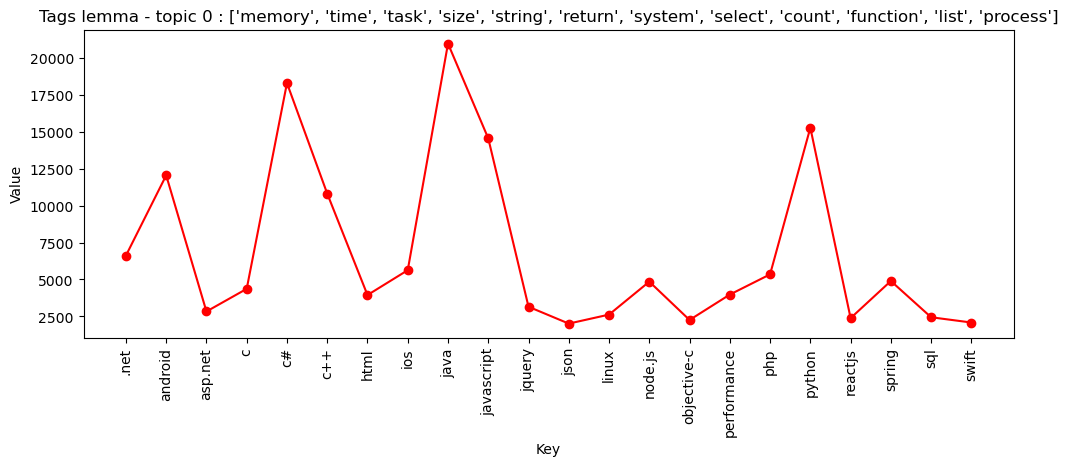



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['file', 'python', 'build', 'include', 'line', 'project', 'bin', 'module', 'local', 'version', 'path', 'function'] 

word = file , df_word.shape = (16554, 7)
word = file , _Tag_1 = 2845 , _Tag_2 = 10638
word = python , df_word.shape = (4876, 7)
word = python , _Tag_1 = 483 , _Tag_2 = 14480
word = build , df_word.shape = (9701, 7)
word = build , _Tag_1 = 800 , _Tag_2 = 20783
word = include , df_word.shape = (5924, 7)
word = include , _Tag_1 = 4383 , _Tag_2 = 24757
word = line , df_word.shape = (8997, 7)
word = line , _Tag_1 = 4515 , _Tag_2 = 949
word = project , df_word.shape = (8567, 7)
word = project , _Tag_1 = 9101 , _Tag_2 = 36076
word = bin , df_word.shape = (7101, 7)
word = bin , _Tag_1 = 1672 , _Tag_2 = 40758
word = module , df_word.shape = (5046, 7)
word = module , _Tag_1 = 10667 , _Tag_2 = 7384
word = local , df_word.shape = (5088, 7)
word = local , _Tag_1 = 2002 ,

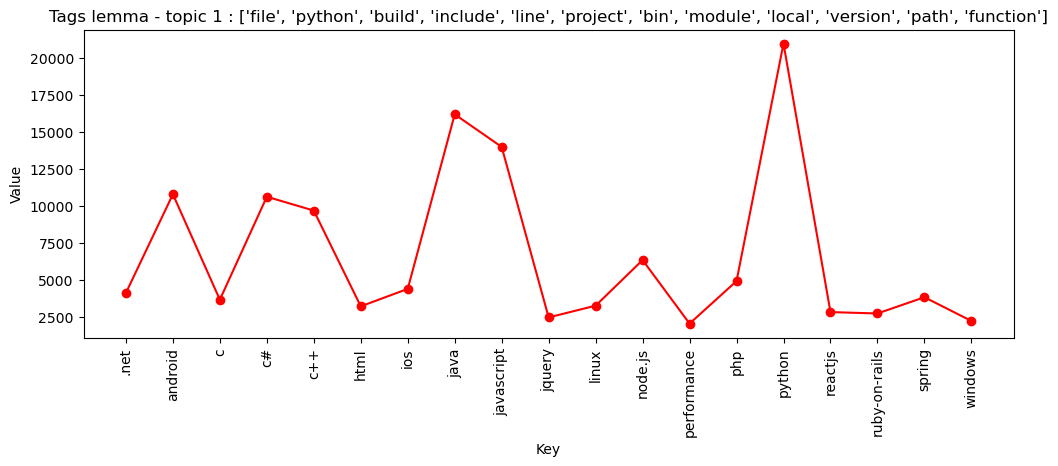



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['java', 'spring', 'apache', 'web', 'version', 'jar', 'system', 'hibernate', 'security', 'boot', 'class', 'sun'] 

word = java , df_word.shape = (8634, 7)
word = java , _Tag_1 = 6286 , _Tag_2 = 5574
word = spring , df_word.shape = (2812, 7)
word = spring , _Tag_1 = 8485 , _Tag_2 = 6700
word = apache , df_word.shape = (2512, 7)
word = apache , _Tag_1 = 10154 , _Tag_2 = 8353
word = web , df_word.shape = (6930, 7)
word = web , _Tag_1 = 1253 , _Tag_2 = 241
word = version , df_word.shape = (11333, 7)
word = version , _Tag_1 = 497 , _Tag_2 = 19723
word = jar , df_word.shape = (1907, 7)
word = jar , _Tag_1 = 5196 , _Tag_2 = 21048
word = system , df_word.shape = (9712, 7)
word = system , _Tag_1 = 18602 , _Tag_2 = 27087
word = hibernate , df_word.shape = (1256, 7)
word = hibernate , _Tag_1 = 19671 , _Tag_2 = 27717
word = security , df_word.shape = (2654, 7)
word = security , _Tag_1

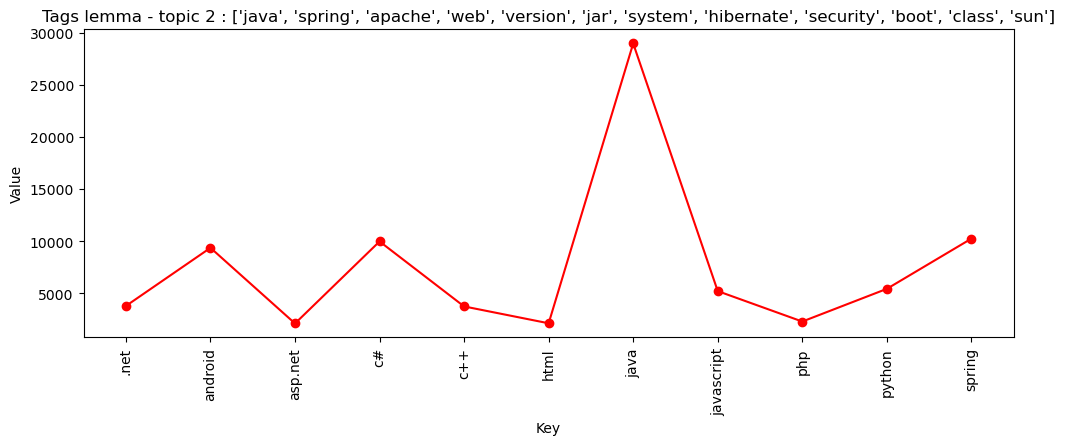



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['class', 'text', 'button', 'function', 'input', 'width', 'document', 'click', 'title', 'label', 'window', 'element'] 

word = class , df_word.shape = (21271, 7)
word = class , _Tag_1 = 857 , _Tag_2 = 421
word = text , df_word.shape = (9077, 7)
word = text , _Tag_1 = 3950 , _Tag_2 = 17686
word = button , df_word.shape = (4379, 7)
word = button , _Tag_1 = 1844 , _Tag_2 = 767
word = function , df_word.shape = (13460, 7)
word = function , _Tag_1 = 10110 , _Tag_2 = 854
word = input , df_word.shape = (5664, 7)
word = input , _Tag_1 = 11380 , _Tag_2 = 992
word = width , df_word.shape = (4954, 7)
word = width , _Tag_1 = 7218 , _Tag_2 = 673
word = document , df_word.shape = (6072, 7)
word = document , _Tag_1 = 3363 , _Tag_2 = 1280
word = click , df_word.shape = (3584, 7)
word = click , _Tag_1 = 1151 , _Tag_2 = 38501
word = title , df_word.shape = (4144, 7)
word = title , _Tag_1 = 

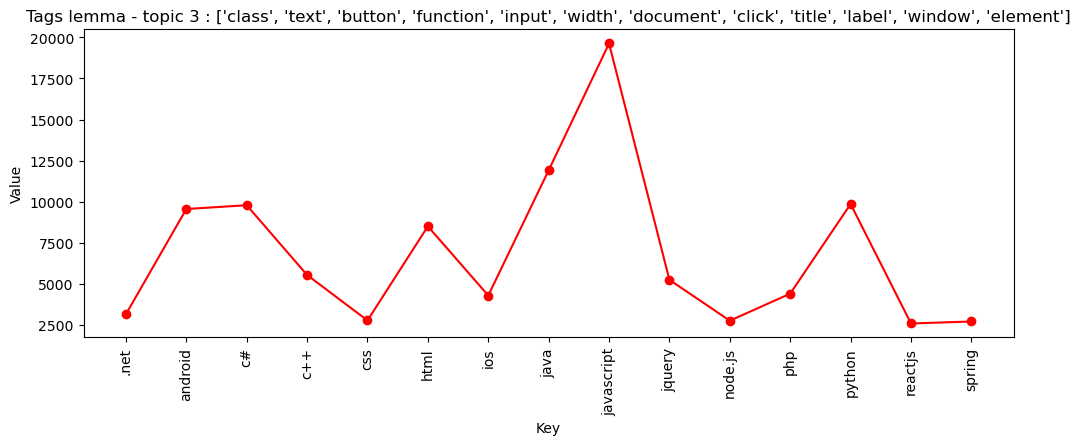



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['self', 'image', 'size', 'frame', 'view', 'video', 'height', 'width', 'import', 'let', 'cell', 'canvas'] 

word = self , df_word.shape = (5083, 7)
word = self , _Tag_1 = 1359 , _Tag_2 = 555
word = image , df_word.shape = (4938, 7)
word = image , _Tag_1 = 935 , _Tag_2 = 6102
word = size , df_word.shape = (7694, 7)
word = size , _Tag_1 = 2557 , _Tag_2 = 902
word = frame , df_word.shape = (1974, 7)
word = frame , _Tag_1 = 3050 , _Tag_2 = 1083
word = view , df_word.shape = (7450, 7)
word = view , _Tag_1 = 3227 , _Tag_2 = 16214
word = video , df_word.shape = (1284, 7)
word = video , _Tag_1 = 5362 , _Tag_2 = 16941
word = height , df_word.shape = (4414, 7)
word = height , _Tag_1 = 5625 , _Tag_2 = 537
word = width , df_word.shape = (4954, 7)
word = width , _Tag_1 = 5965 , _Tag_2 = 565
word = import , df_word.shape = (8531, 7)
word = import , _Tag_1 = 6021 , _Tag_2 = 7831
word = l

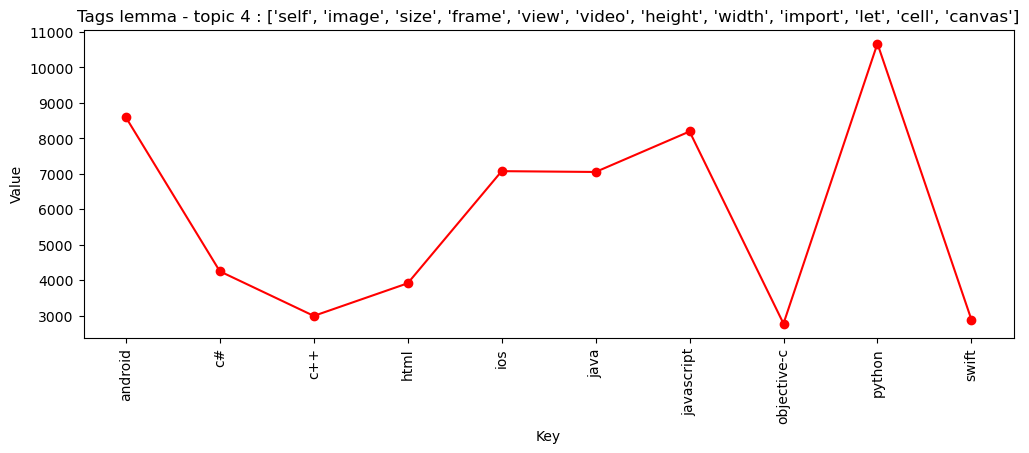



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['android', 'layout', 'java', 'view', 'public', 'fragment', 'parent', 'void', 'string', 'import', 'height', 'private'] 

word = android , df_word.shape = (5536, 7)
word = android , _Tag_1 = 4949 , _Tag_2 = 3478
word = layout , df_word.shape = (3336, 7)
word = layout , _Tag_1 = 175 , _Tag_2 = 5635
word = java , df_word.shape = (8634, 7)
word = java , _Tag_1 = 8387 , _Tag_2 = 11209
word = view , df_word.shape = (7450, 7)
word = view , _Tag_1 = 9473 , _Tag_2 = 15462
word = public , df_word.shape = (14540, 7)
word = public , _Tag_1 = 1715 , _Tag_2 = 526
word = fragment , df_word.shape = (1073, 7)
word = fragment , _Tag_1 = 14789 , _Tag_2 = 25151
word = parent , df_word.shape = (3826, 7)
word = parent , _Tag_1 = 1436 , _Tag_2 = 328
word = void , df_word.shape = (12246, 7)
word = void , _Tag_1 = 2727 , _Tag_2 = 726
word = string , df_word.shape = (14976, 7)
word = string , _Tag_

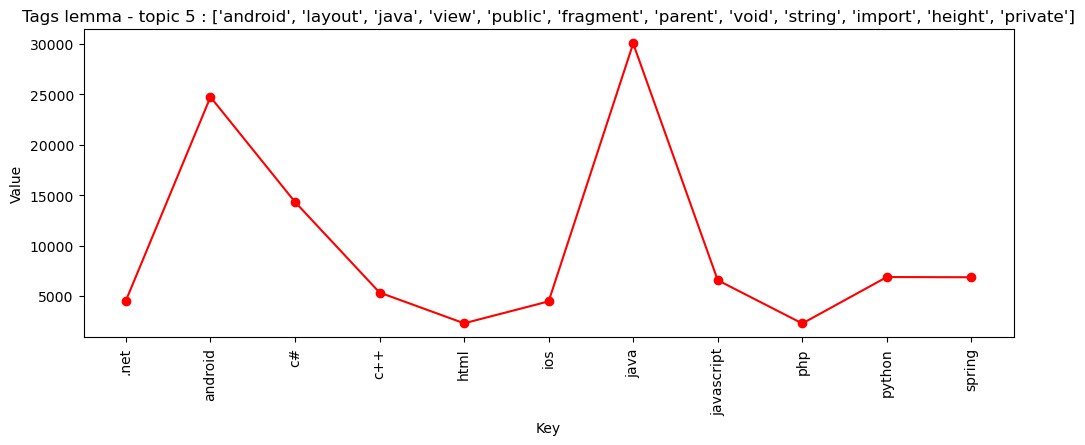



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['request', 'server', 'response', 'client', 'token', 'file', 'function', 'console', 'get', 'post', 'session', 'message'] 

word = request , df_word.shape = (7349, 7)
word = request , _Tag_1 = 350 , _Tag_2 = 140
word = server , df_word.shape = (9615, 7)
word = server , _Tag_1 = 2699 , _Tag_2 = 10094
word = response , df_word.shape = (5168, 7)
word = response , _Tag_1 = 951 , _Tag_2 = 312
word = client , df_word.shape = (5774, 7)
word = client , _Tag_1 = 5759 , _Tag_2 = 16694
word = token , df_word.shape = (2275, 7)
word = token , _Tag_1 = 919 , _Tag_2 = 18171
word = file , df_word.shape = (16554, 7)
word = file , _Tag_1 = 8902 , _Tag_2 = 28809
word = function , df_word.shape = (13460, 7)
word = function , _Tag_1 = 11213 , _Tag_2 = 1087
word = console , df_word.shape = (5511, 7)
word = console , _Tag_1 = 2722 , _Tag_2 = 850
word = get , df_word.shape = (28041, 7)
word = get 

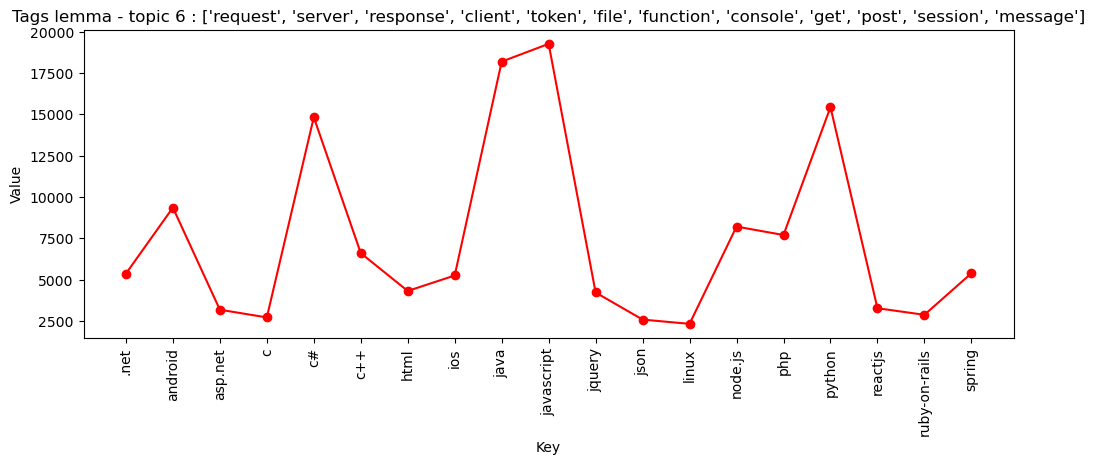



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['public', 'class', 'string', 'return', 'object', 'private', 'get', 'void', 'model', 'entity', 'null', 'set'] 

word = public , df_word.shape = (14540, 7)
word = public , _Tag_1 = 215 , _Tag_2 = 92
word = class , df_word.shape = (21271, 7)
word = class , _Tag_1 = 1072 , _Tag_2 = 513
word = string , df_word.shape = (14976, 7)
word = string , _Tag_1 = 1654 , _Tag_2 = 895
word = return , df_word.shape = (20538, 7)
word = return , _Tag_1 = 2703 , _Tag_2 = 1361
word = object , df_word.shape = (11105, 7)
word = object , _Tag_1 = 6798 , _Tag_2 = 50394
word = private , df_word.shape = (8800, 7)
word = private , _Tag_1 = 7358 , _Tag_2 = 55805
word = get , df_word.shape = (28041, 7)
word = get , _Tag_1 = 5084 , _Tag_2 = 2197
word = void , df_word.shape = (12246, 7)
word = void , _Tag_1 = 5920 , _Tag_2 = 2353
word = model , df_word.shape = (5123, 7)
word = model , _Tag_1 = 34985 , _T

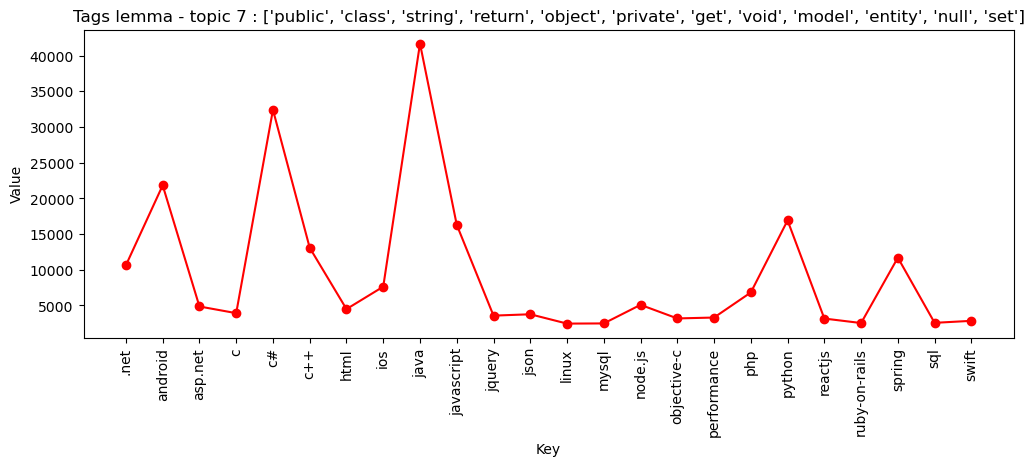

In [43]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'lemma', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_lemma, 
                                  terms_in              = terms_lemma)

In [ ]:
##################################################################
# ANALYSE GRAPHIQUE LEMMA :                                      #
# Synthèse des 5 premiers tags fournis par LDA pour chaque topic #
##################################################################
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 0 :  ['memory', 'time', 'task', 'size', 'string', 'return', 'system', 'select', 'count', 'function', 'list', 'process'] 
# 
# ('java',       20956)
# ('python',     15265)
# ('c#',         18283)
# ('javascript', 14545)
# ('android',    12045)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 1 :  ['file', 'python', 'build', 'include', 'line', 'project', 'bin', 'module', 'local', 'version', 'path', 'function'] 
# 
# ('java',       16194)
# ('python',     20968)
# ('c#',         10630)
# ('javascript', 13993)
# ('android',    10798)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 2 :  ['java', 'spring', 'apache', 'web', 'version', 'jar', 'system', 'hibernate', 'security', 'boot', 'class', 'sun'] 
# 
# ('java',       28975)
# ('python',      5426)
# ('c#',          9975)
# ('javascript',  5209)
# ('android',     9364)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 3 :  ['class', 'text', 'button', 'function', 'input', 'width', 'document', 'click', 'title', 'label', 'window', 'element'] 
# 
# ('java',       11907)
# ('python',      9856)
# ('c#',          9783)
# ('javascript', 19632)
# ('android',     9551)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 4 :  ['self', 'image', 'size', 'frame', 'view', 'video', 'height', 'width', 'import', 'let', 'cell', 'canvas'] 
# 
# ('java',        7051)
# ('python',     10672)
# ('c#',          4248)
# ('javascript',  8193)
# ('android',     8590)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 5 :  ['android', 'layout', 'java', 'view', 'public', 'fragment', 'parent', 'void', 'string', 'import', 'height', 'private'] 
# 
# ('java',       30057)
# ('python',      6893)
# ('c#',         14339)
# ('javascript',  6577)
# ('android',    24750)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 6 :  ['request', 'server', 'response', 'client', 'token', 'file', 'function', 'console', 'get', 'post', 'session', 'message'] 
# 
# ('java',       18202)
# ('python',     15446)
# ('c#',         14834)
# ('javascript', 19279)
# ('android',     9359)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 7 :  ['public', 'class', 'string', 'return', 'object', 'private', 'get', 'void', 'model', 'entity', 'null', 'set'] 
# 
# ('java',       41668)
# ('python',     16900)
# ('c#',         32395)
# ('javascript', 16283)
# ('android',    21818)

In [ ]:
# => la pertinence du machine learning non supervisé est plutôt globale et imprécise.

# 2.2.2. METHODE 2

In [ ]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# Topic model : LDA
# ------------------------------------------------
# 1) Data transformation: Corpus and Dictionary
# 2) Base Model
# 3) Hyperparameter Tuning
# 4) Final Model
# 5) Visualize Results

In [44]:
#####################################################
#  1) Data Transformation : Corpus and Dictionary   #
#####################################################
# https://stackoverflow.com/questions/33229360/gensim-typeerror-doc2bow-expects-an-array-of-unicode-tokens-on-input-not-a-si
# The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.
def LDA_Data_Transformation(normalization_type_in, corpus_liste_in):
       
    # Create Dictionary
    id2word = corpora.Dictionary(corpus_liste_in)

    # Create Corpus
    texts = corpus_liste_in

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # View
    print('Term Document Frequency for', normalization_type_in, ':', corpus[:1][0][:30])
    
    return id2word, texts, corpus

In [45]:
# corpus_lemma = ' '.join(df['_Lemma_clean_final'])
id2word_lemma, texts_lemma, corpus_lemma = LDA_Data_Transformation(normalization_type_in = 'lemma',
                                                                   corpus_liste_in       = [token_lemma])

Term Document Frequency for lemma : [(0, 21), (1, 17), (2, 28), (3, 623), (4, 1509), (5, 2188), (6, 165), (7, 142), (8, 209), (9, 28), (10, 110), (11, 165), (12, 674), (13, 81), (14, 343), (15, 4193), (16, 58), (17, 97), (18, 89), (19, 147), (20, 20), (21, 153), (22, 43), (23, 58), (24, 6), (25, 1809), (26, 656), (27, 12049), (28, 1601), (29, 145)]


In [46]:
# corpus_stemmer = ' '.join(df['_Stemmer_clean_final'])
id2word_stemmer, texts_stemmer, corpus_stemmer = LDA_Data_Transformation(normalization_type_in = 'stemmer',
                                                                         corpus_liste_in       = [token_stemmer])

Term Document Frequency for stemmer : [(0, 21), (1, 17), (2, 623), (3, 2353), (4, 343), (5, 4251), (6, 147), (7, 20), (8, 58), (9, 6), (10, 1809), (11, 656), (12, 12049), (13, 505), (14, 92), (15, 309), (16, 29496), (17, 162), (18, 61), (19, 53), (20, 1607), (21, 198), (22, 190), (23, 4), (24, 36), (25, 289), (26, 422), (27, 3249), (28, 229), (29, 20)]


In [47]:
#####################################################
# 2) Base Model                                     #
#####################################################
def LDA_Base_Model(normalization_type_in, corpus_in, id2word_in):
    
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus          = corpus_in,
                                           id2word         = id2word_in,
                                           num_topics      = 10, 
                                           random_state    = 100,
                                           chunksize       = 100,
                                           passes          = 10,
                                           per_word_topics = True)

    # View the topics in LDA model
    # Print the Keyword in the 10 topics
    print('10 topics in LDA model for', normalization_type_in, ':')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus_in]
    
    return lda_model

In [48]:
lda_model_lemma = LDA_Base_Model(normalization_type_in = 'lemma',
                                 corpus_in             = corpus_lemma,
                                 id2word_in            = id2word_lemma)

10 topics in LDA model for lemma :
[(0,
  '0.031*"java" + 0.026*"android" + 0.025*"class" + 0.018*"return" + '
  '0.017*"file" + 0.016*"string" + 0.016*"public" + 0.012*"get" + 0.010*"self" '
  '+ 0.009*"system"'),
 (1,
  '0.030*"java" + 0.024*"android" + 0.020*"public" + 0.019*"file" + '
  '0.017*"class" + 0.016*"return" + 0.014*"get" + 0.013*"string" + '
  '0.012*"function" + 0.011*"void"'),
 (2,
  '0.040*"java" + 0.025*"android" + 0.019*"class" + 0.019*"public" + '
  '0.015*"string" + 0.014*"file" + 0.014*"get" + 0.013*"self" + '
  '0.011*"function" + 0.011*"return"'),
 (3,
  '0.034*"java" + 0.020*"class" + 0.019*"android" + 0.016*"file" + '
  '0.016*"public" + 0.015*"string" + 0.015*"return" + 0.014*"get" + '
  '0.012*"import" + 0.012*"function"'),
 (4,
  '0.025*"java" + 0.021*"public" + 0.020*"android" + 0.019*"get" + '
  '0.018*"file" + 0.016*"return" + 0.015*"class" + 0.014*"string" + '
  '0.012*"import" + 0.010*"function"'),
 (5,
  '0.028*"java" + 0.023*"class" + 0.022*"android

In [49]:
lda_model_stemmer = LDA_Base_Model(normalization_type_in = 'stemmer',
                                   corpus_in             = corpus_stemmer,
                                   id2word_in            = id2word_stemmer)

10 topics in LDA model for stemmer :
[(0,
  '0.032*"java" + 0.027*"android" + 0.021*"class" + 0.021*"get" + '
  '0.018*"public" + 0.016*"file" + 0.015*"string" + 0.014*"return" + '
  '0.012*"system" + 0.012*"function"'),
 (1,
  '0.028*"java" + 0.025*"class" + 0.024*"android" + 0.022*"public" + '
  '0.016*"return" + 0.015*"get" + 0.015*"string" + 0.014*"function" + '
  '0.014*"file" + 0.013*"import"'),
 (2,
  '0.036*"java" + 0.026*"android" + 0.020*"public" + 0.018*"file" + '
  '0.018*"class" + 0.014*"function" + 0.014*"return" + 0.014*"get" + '
  '0.012*"string" + 0.012*"null"'),
 (3,
  '0.032*"java" + 0.025*"android" + 0.024*"class" + 0.020*"string" + '
  '0.020*"public" + 0.018*"file" + 0.016*"return" + 0.014*"get" + 0.013*"void" '
  '+ 0.012*"import"'),
 (4,
  '0.033*"java" + 0.024*"android" + 0.021*"class" + 0.019*"return" + '
  '0.018*"get" + 0.016*"file" + 0.016*"string" + 0.015*"public" + 0.013*"set" '
  '+ 0.013*"version"'),
 (5,
  '0.037*"java" + 0.023*"class" + 0.022*"android

In [50]:
####################################################
#   Compute Model Perplexity and Coherence Score   #
####################################################
def LDA_Coherence_Score(normalization_type_in, lda_model_in, corpus_liste_in, id2word_in):
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model      = lda_model_in, 
                                         texts      = corpus_liste_in, 
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score for', normalization_type_in, ':', coherence_lda)

In [51]:
LDA_Coherence_Score(normalization_type_in = 'lemma',
                    lda_model_in          = lda_model_lemma, 
                    corpus_liste_in       = [token_lemma], 
                    id2word_in            = id2word_lemma)

Coherence Score for lemma : 0.36203503137793863


In [52]:
LDA_Coherence_Score(normalization_type_in = 'stemmer',
                    lda_model_in          = lda_model_stemmer, 
                    corpus_liste_in       = [token_stemmer], 
                    id2word_in            = id2word_stemmer) 

Coherence Score for stemmer : 0.3505478226299601


In [ ]:
#####################################################
# 3) Hyperparameter Tuning                          #
#####################################################
#   --> k : Number of Topics
#   --> a (Dirichlet hyperparameter alpha) : Document-Topic Density
#   --> b (Dirichlet hyperparameter beta) : Word-Topic Density

In [53]:
# supporting function
def compute_coherence_values(corpus_in, id2word_in, k_in, a_in, b_in, lda_model_in, corpus_liste_in):
    
    lda_model = gensim.models.LdaMulticore(corpus       = corpus_in,
                                           id2word      = id2word_in,
                                           num_topics   = k_in, 
                                           random_state = 100,
                                           chunksize    = 100,
                                           passes       = 10,
                                           alpha        = a_in,
                                           eta          = b_in)
    
    coherence_model_lda = CoherenceModel(model      = lda_model_in,
                                         texts      = corpus_liste_in,
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')
    
    return coherence_model_lda.get_coherence()

In [54]:
# Let’s call the function, and iterate it over the range of topics, alpha, and beta parameter values.
def LDA_hyperparameters_tuning(normalization_type_in, corpus_in, id2word_in, lda_model_in, corpus_liste_in):

    grid = {}
    grid['Validation_Set'] = {}

    # Topics range
    topics_range = [8, 10, 12]

    # Alpha parameter
    alpha = [0.01, 0.1, 1]

    # Beta parameter
    beta = [0.01, 0.1, 1]    

    # Validation sets
    num_of_docs = len(corpus_in)
    corpus_sets = [gensim.utils.ClippedCorpus(corpus_in, int(num_of_docs * 0.75)), 
                   corpus_in]

    corpus_title = ['75% Corpus', '100% Corpus']

    model_results = {'Validation_Set': [],
                     'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }

    # Can take a long time to run
    if 1 == 1:
        pbar = tqdm.tqdm(total = (len(beta) * len(alpha) * len(topics_range) * len(corpus_title)))
    
        # iterate through validation corpuses
        for i in range(len(corpus_sets)):
            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        
                        print('i =', i, '/', len(corpus_sets), ', k =', k, ', a =', a, ', b =', b)
                        
                        # get the coherence score for the given parameters                     
                        cv = compute_coherence_values(corpus_in       = corpus_sets[i], 
                                                      id2word_in      = id2word_in,
                                                      k_in            = k, 
                                                      a_in            = a, 
                                                      b_in            = b,
                                                      lda_model_in    = lda_model_in,
                                                      corpus_liste_in = corpus_liste_in)
        
                        # Save the model results
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)
                    
                        pbar.update(1)
        
        # Ecriture dans un fichier
        if (normalization_type_in == 'lemma'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_lemma.csv', index = False)
        elif (normalization_type_in == 'stemmer'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_stemmer.csv', index = False)
        else:
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index = False)            
        pbar.close()

In [55]:
LDA_hyperparameters_tuning(normalization_type_in = 'lemma',
                           corpus_in             = corpus_lemma, 
                           id2word_in            = id2word_lemma, 
                           lda_model_in          = lda_model_lemma, 
                           corpus_liste_in       = [token_lemma]) # 1 h 01 min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [01:08<1:00:12, 68.15s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [02:11<56:26, 65.12s/it]  

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [03:06<51:30, 60.59s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [04:01<48:47, 58.56s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [04:57<47:07, 57.69s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [05:55<46:01, 57.52s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [06:52<44:58, 57.41s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [07:51<44:26, 57.96s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [08:50<43:37, 58.17s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [09:54<43:57, 59.95s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [10:54<43:10, 60.25s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [11:55<42:15, 60.38s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [12:55<41:10, 60.26s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [13:54<39:55, 59.89s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [14:55<39:09, 60.23s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [15:57<38:24, 60.65s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [16:57<37:20, 60.55s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [17:57<36:17, 60.50s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [19:01<35:47, 61.36s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [20:03<34:53, 61.58s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [21:07<34:21, 62.46s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [22:15<34:11, 64.10s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [23:23<33:37, 65.09s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [24:28<32:30, 65.02s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [25:30<31:00, 64.16s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [26:32<29:36, 63.44s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [27:35<28:36, 63.57s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [28:43<28:07, 64.91s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [30:03<28:49, 69.18s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [31:52<32:29, 81.24s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [33:32<33:20, 86.99s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [35:09<32:59, 89.98s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [36:45<32:04, 91.64s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [38:17<30:33, 91.66s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [39:50<29:09, 92.10s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [41:28<28:10, 93.93s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [43:00<26:28, 93.44s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [44:31<24:44, 92.79s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [45:52<22:16, 89.09s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [46:55<18:56, 81.15s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [47:56<16:18, 75.26s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [48:56<14:08, 70.67s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [49:56<12:22, 67.50s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [50:57<10:53, 65.40s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [51:57<09:33, 63.75s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [52:57<08:22, 62.76s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [53:57<07:13, 61.94s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [54:57<06:08, 61.45s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [55:59<05:07, 61.59s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [57:00<04:04, 61.22s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [58:01<03:03, 61.17s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [59:04<02:03, 61.85s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:00:09<01:02, 62.88s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:01:21<00:00, 68.17s/it]


In [57]:
LDA_hyperparameters_tuning(normalization_type_in = 'stemmer',
                           corpus_in             = corpus_stemmer, 
                           id2word_in            = id2word_stemmer, 
                           lda_model_in          = lda_model_stemmer, 
                           corpus_liste_in       = [token_stemmer])  # 1 h 03 min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [00:50<44:16, 50.13s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [01:39<43:16, 49.94s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [02:39<46:04, 54.21s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [03:45<49:10, 59.02s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [04:53<50:49, 62.24s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [05:58<50:35, 63.23s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [07:09<51:24, 65.62s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [08:13<50:02, 65.27s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [09:18<48:54, 65.21s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [10:28<48:48, 66.56s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [11:38<48:22, 67.50s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [12:44<47:01, 67.19s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [13:55<46:37, 68.24s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [15:06<46:08, 69.22s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [16:14<44:46, 68.88s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [17:24<43:41, 68.98s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [18:30<42:03, 68.20s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [19:41<41:22, 68.95s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [20:49<40:02, 68.64s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [21:52<38:02, 67.13s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [22:56<36:21, 66.10s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [24:02<35:20, 66.26s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [25:09<34:16, 66.34s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [26:20<33:49, 67.65s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [27:30<33:01, 68.32s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [28:35<31:24, 67.32s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [29:41<30:07, 66.93s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [30:54<29:54, 69.01s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [32:07<29:15, 70.22s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [33:22<28:37, 71.56s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [34:37<27:47, 72.51s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [35:40<25:32, 69.66s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [36:43<23:41, 67.71s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [37:42<21:42, 65.12s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [38:44<20:19, 64.19s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [39:47<19:07, 63.77s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [40:59<18:44, 66.14s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [42:08<17:54, 67.13s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [43:23<17:22, 69.50s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [44:39<16:41, 71.52s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [45:57<15:55, 73.47s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [47:19<15:12, 76.02s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [48:40<14:11, 77.44s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [50:02<13:07, 78.79s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [51:22<11:53, 79.28s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [52:39<10:27, 78.44s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [53:56<09:06, 78.05s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [55:26<08:09, 81.56s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [56:49<06:50, 82.11s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [58:19<05:37, 84.30s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [59:43<04:12, 84.20s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [1:01:00<02:44, 82.07s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:02:18<01:20, 80.91s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:03:39<00:00, 70.73s/it]


In [58]:
########################################
# Investigate Results                  #
########################################
def LDA_Investigate_Results(normalization_type_in):
    
    if (normalization_type_in == 'lemma'):
        df_lda = pd.read_csv('./results/lda_tuning_results_lemma.csv')
    elif (normalization_type_in == 'stemmer'):
        df_lda = pd.read_csv('./results/lda_tuning_results_stemmer.csv')
    else:
        df_lda = pd.read_csv('./results/lda_tuning_results.csv')    
     
    print('columns\t:', df_lda.columns)
    print('shape\t:', df_lda.shape, '\n')
    print('dtypes :')
    print(df_lda.dtypes)
    
    return df_lda

In [59]:
df_lda_lemma = LDA_Investigate_Results(normalization_type_in = 'lemma')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [60]:
df_lda_stemmer = LDA_Investigate_Results(normalization_type_in = 'stemmer')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [61]:
#############################################################################
# Affichage hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma #
#############################################################################
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

def LDA_affichage_hyperparametres():
    
    plt.figure(figsize = (15, 6))
    
    # >>>>>>> Topics % Coherence
    plt.subplot(1, 3, 1)   # lignes, colonnes
    plt.plot(df_lda_lemma['Topics'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Topics'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Topics')
    plt.ylabel('Coherence')
    plt.title('Topics % Coherence')
    plt.legend() 

    # >>>>>>> Alpha % Coherence
    plt.subplot(1, 3, 2)   # lignes, colonnes
    plt.plot(df_lda_lemma['Alpha'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Alpha'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Alpha')
    plt.ylabel('Coherence')
    plt.title('Alpha % Coherence')
    plt.legend()

    # >>>>>>> Beta % Coherence
    plt.subplot(1, 3, 3)   # lignes, colonnes
    plt.plot(df_lda_lemma['Beta'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Beta'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Beta')
    plt.ylabel('Coherence')
    plt.title('Beta % Coherence')
    plt.legend()

    
    # >>>>>>> Paramètres communs
    plt.suptitle('Hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma', fontsize = 18)
    plt.tight_layout() # pour éviter chevauchement titre et ligne suivante
    plt.legend() 
    plt.show()

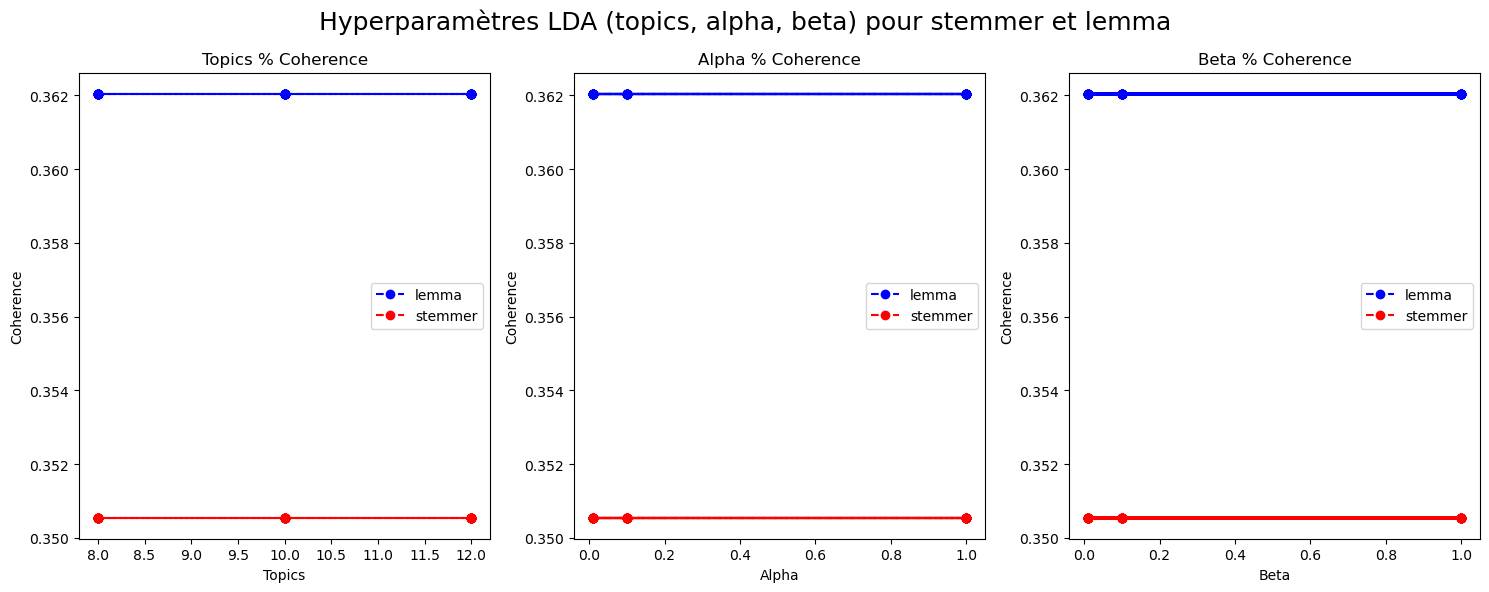

In [62]:
LDA_affichage_hyperparametres()

In [ ]:
#####################################################
# 4) Final Model                                    #
#####################################################

In [63]:
# Maj hyperparamètres : on prend la 1ère valeur de la plage car ils donnent tous le même résultat.
# Remarque : la cohérence est meilleure pour lemma que stemmer.
num_topics = 8    # Number of Topics
alpha      = 0.01 # Alpha parameter
beta       = 0.01 # Beta parameter

In [64]:
lda_model_lemma = gensim.models.LdaMulticore(corpus       = corpus_lemma,
                                             id2word      = id2word_lemma,
                                             num_topics   = num_topics, # hyperparamètre
                                             random_state = 100,
                                             chunksize    = 100,
                                             passes       = 10,
                                             alpha        = alpha,      # hyperparamètre
                                             eta          = beta)       # hyperparamètre

In [65]:
lda_model_stemmer = gensim.models.LdaMulticore(corpus       = corpus_stemmer,
                                               id2word      = id2word_stemmer,
                                               num_topics   = num_topics, # hyperparamètre
                                               random_state = 100,
                                               chunksize    = 100,
                                               passes       = 10,
                                               alpha        = alpha,      # hyperparamètre
                                               eta          = beta)       # hyperparamètre

In [66]:
#####################################################
# 5) Visualize Results                              #
#####################################################
def LDA_Visualize_Results(normalization_type_in, corpus_in, id2word_in, lda_model_in):

    # Visualize the topics
    pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+ str(num_topics))

    # this is a bit time consuming - make the if statement True
    # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = gensimvis.prepare(lda_model_in, corpus_in, id2word_in)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    
    if (normalization_type_in == 'lemma'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_lemma_'+ str(num_topics) +'.html')
    elif (normalization_type_in == 'stemmer'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_stemmer_'+ str(num_topics) +'.html')
    else:
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

    LDAvis_prepared

In [67]:
LDA_Visualize_Results(normalization_type_in = 'lemma', 
                      corpus_in             = corpus_lemma, 
                      id2word_in            = id2word_lemma, 
                      lda_model_in          = lda_model_lemma)

In [68]:
LDA_Visualize_Results(normalization_type_in = 'stemmer', 
                      corpus_in             = corpus_stemmer, 
                      id2word_in            = id2word_stemmer, 
                      lda_model_in          = lda_model_stemmer)

In [ ]:
# transformation manuelle du fichier html --> jpg

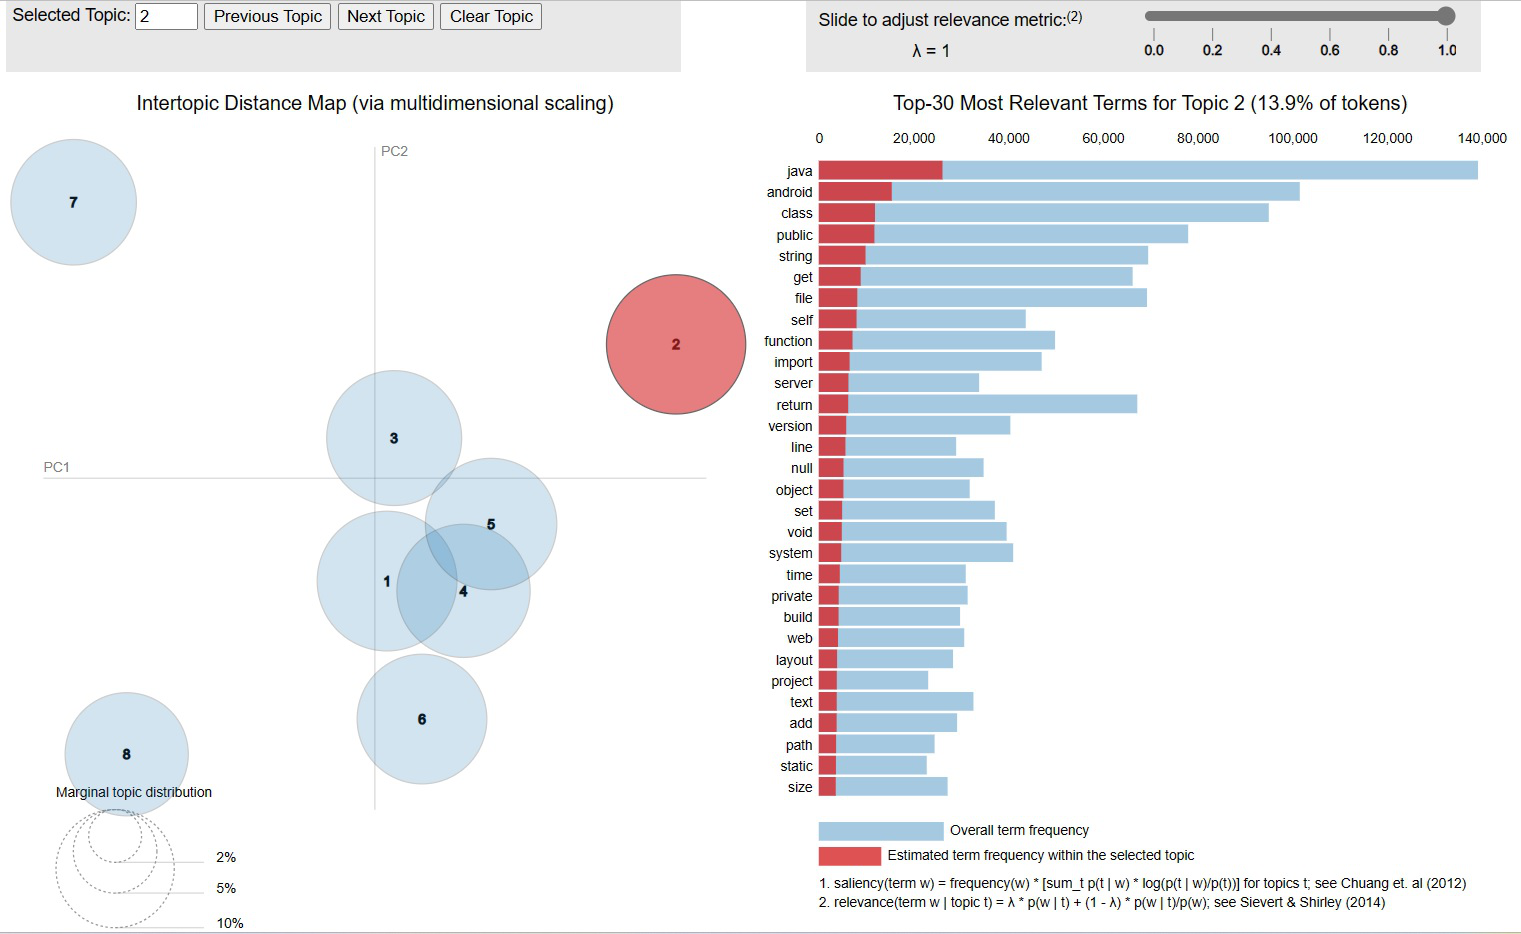

In [69]:
Image.open('./results/ldavis_tuned_lemma_8.jpg')

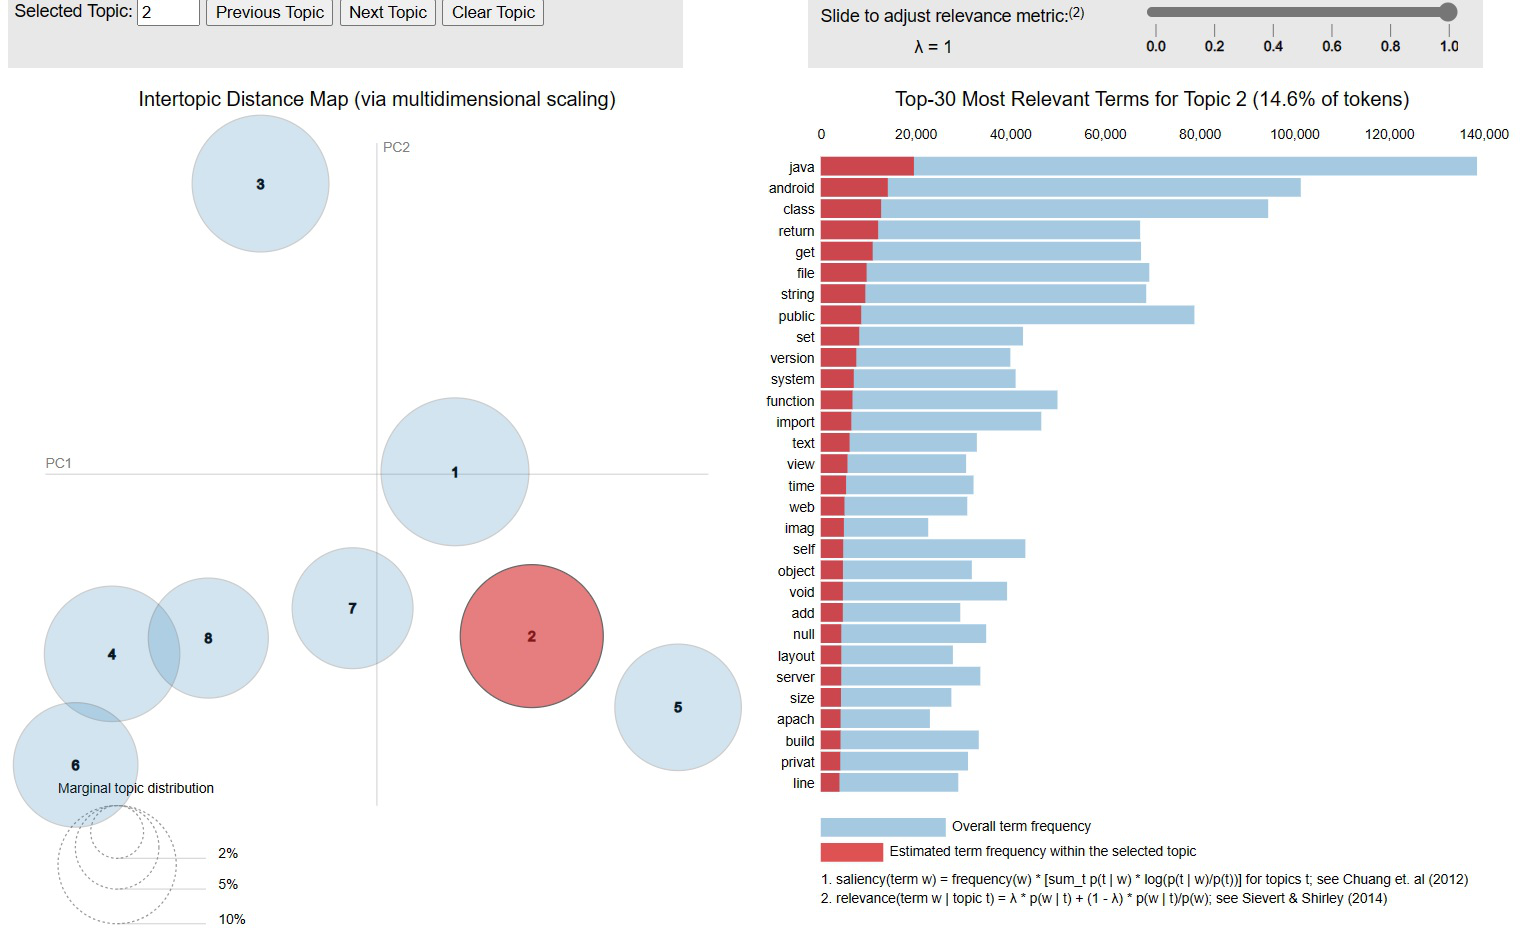

In [70]:
Image.open('./results/ldavis_tuned_stemmer_8.jpg')

# 3. MACHINE LEARNING SUPERVISE - COMMUN

In [71]:
df.columns

Index(['_Tag_1', '_Tag_2', '_Text_sans_html', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final'],
      dtype='object')

In [72]:
df.head()

_Tag_1  _Tag_2                                    _Text_sans_html  \
0     c#    .net  configurationmanager.appsettings performance c...   
1     c#     c++  can i get memcached running on a windows (x64)...   
2     c#    .net  "could not find type" error loading a form in ...   
3     c#    .net  asp.net custom controls - composites summary\n...   
4   java  jquery  how can i make this code to submit a utf-8 for...   

                         _Tokens_stemmer_clean_final  \
0  ['perform', 'class', 'radio', 'time', 'process...   
1  ['get', 'environ', 'get', 'environ', 'set', 'h...   
2  ['find', 'load', 'class', 'class', 'bit', 'bre...   
3  ['free', 'file', 'light', 'get', 'add', 'web',...   
4  ['submit', 'contain', 'web', 'tomcat', 'server...   

                           _Tokens_lemma_clean_final  \
0  ['performance', 'class', 'radio', 'time', 'pro...   
1  ['get', 'environment', 'get', 'environment', '...   
2  ['find', 'loading', 'designer', 'class', 'clas...   
3  ['summary', 'summary', 'free', 'file', 'light'...   
4  ['submit', 'contain', 'web', 'tomcat', 'server...   

                                _Stemmer_clean_final  \
0  perform class radio time process time process ...   
1  get environ get environ set host solut solut s...   
2  find load class class bit break view get find ...   
3  free file light get add web project render ren...   
4  submit contain web tomcat server environ set c...   

                                  _Lemma_clean_final  
0  performance class radio time process time proc...  
1  get environment get environment setting hostin...  
2  find loading designer class class bit break de...  
3  summary summary free file light get designer c...  
4  submit contain web tomcat server environment s...

# 3.1. EXTRACTION DONNEES X

In [ ]:
# Nous étudierons 2 types de méthodes d’extraction de features (pour les données X) :
# ---> Une approche de type bag-of-words :
#      § 4. MACHINE LEARNING SUPERVISE - EXTRACTION DE FEATURES AVEC UNE APPROCHE BOW
#
# ---> Des approches de Word/Sentence Embedding :
#      § 5. MACHINE LEARNING SUPERVISE - EXTRACTION DE FEATURES AVEC 3 APPROCHES WORD / SENTENCE EMBEDDING

# 3.2. EXTRACTION DONNEES Y

In [ ]:
###############################################
# y : données de sortie (résultat)            #
###############################################

In [73]:
# Copie des 2 sorties y (_Tag_1 et _Tag_2) dans un dataframe.
def Y_extraction_Tag_1_et_Tag_2(df_in):
    
    df_y = df_in[['_Tag_1', '_Tag_2']].copy()
    print('df_y shape =', df_y.shape)
    
    return df_y

In [74]:
df_y = Y_extraction_Tag_1_et_Tag_2(df_in = df)

df_y shape = (49493, 2)


In [75]:
# Vérifications de la mise à jour des tags dans le nouveau df.
def Y_verification_Tag_1_et_Tag_2(df_in, df_y_in):
    
    nb_ligne = 4
    
    # Vérification n°1
    for index, row in df_in.iterrows():
        if (row['_Tag_1'] != df_y_in.loc[index, '_Tag_1']):
            print('index =', index, ': _Tag_1 différent : df_in =', row['_Tag_1'], 
                  ', df_y_in =', df_y_in.loc[index, '_Tag_1'])
        if (row['_Tag_2'] != df_y_in.loc[index, '_Tag_2']):
            print('index =', index, ': _Tag_2 différent : df_in =', row['_Tag_2'], 
                  ', df_y_in =', df_y_in.loc[index, '_Tag_2'])
        

    # Vérification n°2
    print('@' * 16, 'df_in - head :', '@' * 16, '\n', df_in[['_Tag_1', '_Tag_2']].head(nb_ligne), '\n')
    print('@' * 15, 'df_y_in - head :', '@' * 15, '\n', df_y_in.head(nb_ligne), '\n\n')

    print('@' * 16, 'df_in - tail :', '@' * 16, '\n', df_in[['_Tag_1', '_Tag_2']].tail(nb_ligne), '\n')
    print('@' * 15, 'df_y_in - tail :', '@' * 15, '\n', df_y_in.tail(nb_ligne))  

In [76]:
Y_verification_Tag_1_et_Tag_2(df_in = df, df_y_in = df_y)

@@@@@@@@@@@@@@@@ df_in - head : @@@@@@@@@@@@@@@@ 
   _Tag_1 _Tag_2
0     c#   .net
1     c#    c++
2     c#   .net
3     c#   .net 

@@@@@@@@@@@@@@@ df_y_in - head : @@@@@@@@@@@@@@@ 
   _Tag_1 _Tag_2
0     c#   .net
1     c#    c++
2     c#   .net
3     c#   .net 


@@@@@@@@@@@@@@@@ df_in - tail : @@@@@@@@@@@@@@@@ 
               _Tag_1  _Tag_2
49489        android  no_tag
49490  ruby-on-rails  no_tag
49491           java  no_tag
49492            ios   swift 

@@@@@@@@@@@@@@@ df_y_in - tail : @@@@@@@@@@@@@@@ 
               _Tag_1  _Tag_2
49489        android  no_tag
49490  ruby-on-rails  no_tag
49491           java  no_tag
49492            ios   swift


In [77]:
# Conversion dataframe --> liste
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ Y : df_y --> list_y                                    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def Y_conversion_df_to_liste(df_y_in):
    
    # https://stacklima.com/comment-convertir-pandas-dataframe-en-une-liste/
    list_y = df_y_in.values.tolist()

    # Vérification
    print('list_y :')
    print('\t- nb éléments\t\t=', len(list_y))
    print('\t- 10 premiers éléments\t=', list_y[0:10], '\n\n')
    
    
    # Suppression valeurs vides ('no_tag') (qui correspondent à _Tag_2 non renseignés).
    # https://stacklima.com/python-supprimer-les-chaines-vides-de-la-liste-des-chaines/
    for i in range(len(list_y)):  
        ligne = list_y[i]
#        print('avant :', i, list_y[i])
    
        if ('no_tag' in ligne):            
            list_y[i].remove('no_tag')
#        print('après :', i, list_y[i], '\n')    
    
    
    # Vérification après Suppresion des valeurs None
    print('list_y après suppression de \'no_tag\' :')
    print('\t- nb éléments\t\t=', len(list_y))
    print('\t- 10 premiers éléments\t=', list_y[0:10])  
    
    return list_y

In [78]:
list_y = Y_conversion_df_to_liste(df_y_in = df_y)

list_y :
	- nb éléments		= 49493
	- 10 premiers éléments	= [['c#', '.net'], ['c#', 'c++'], ['c#', '.net'], ['c#', '.net'], ['java', 'jquery'], ['python', 'linux'], ['.net', 'performance'], ['python', 'sql'], ['java', 'no_tag'], ['c#', '.net']] 


list_y après suppression de 'no_tag' :
	- nb éléments		= 49493
	- 10 premiers éléments	= [['c#', '.net'], ['c#', 'c++'], ['c#', '.net'], ['c#', '.net'], ['java', 'jquery'], ['python', 'linux'], ['.net', 'performance'], ['python', 'sql'], ['java'], ['c#', '.net']]


In [79]:
########################################################################################################
# Nous sommes dans un cas de Multi-label text classification, car la sortie est sur _Tag_1 et _Tag_2.  #
# => Transform between iterable of iterables and a multilabel format.                                  #
########################################################################################################
def Y_transformation_to_multilabel(list_y_in):
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
    # https://scikit-learn.org/stable/modules/preprocessing_targets.html
    # https://medium.com/analytics-vidhya/multi-label-text-classification-for-beginners-in-less-than-five-5-minutes-19502a96cf39

    mlb = MultiLabelBinarizer()

    #----------------------------------------------------------------------------------------------
    # fit_transform(y) : Fit the label sets binarizer and transform the given label sets.
    # Parameters:
    #   - y : iterable of iterables.
    #     A set of labels (any orderable and hashable object) for each sample. If the classes parameter is set, 
    #     y will not be iterated.

    # Returns:
    #    - y_indicator{ndarray, sparse matrix} of shape (n_samples, n_classes).
    #      A matrix such that y_indicator[i, j] = 1 iff classes_[j] is in y[i], and 0 otherwise. 
    #      Sparse matrix will be of CSR format.
    #----------------------------------------------------------------------------------------------
    mlb_indicator = mlb.fit_transform(list_y_in)

    print('type mlb_indicator =', type(mlb_indicator), '\n')
    print('mlb_indicator =\n', mlb_indicator, '\n')
    
    # Classes
    classes = mlb.classes_
    print('classes_ :')
    print('\t- nb éléments\t=', len(classes))
    print('\t- liste\t\t=\n', classes, '\n')

    # y
    #y = np.array(mlb)
    y = mlb_indicator

    print('y shape =', y.shape, '\n')
    print('y =\n', y)
    
    return y, classes

In [80]:
y, classes = Y_transformation_to_multilabel(list_y_in = list_y)

type mlb_indicator = <class 'numpy.ndarray'> 

mlb_indicator =
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]] 

classes_ :
	- nb éléments	= 28
	- liste		=
 ['.net' 'android' 'asp.net' 'c' 'c#' 'c++' 'css' 'html' 'ios' 'iphone'
 'java' 'javascript' 'jquery' 'json' 'linux' 'mysql' 'node.js'
 'objective-c' 'performance' 'php' 'python' 'reactjs' 'ruby-on-rails'
 'spring' 'sql' 'swift' 'windows' 'xcode'] 

y shape = (49493, 28) 

y =
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


# 3.3. DECOUPAGE DONNEES TRAIN / TEST

In [81]:
# Découpage des données X, y en données d'entrainement et de test
def decoupage_train_test(X_in, y_in):
    
    X_train, X_test, y_train, y_test = train_test_split(X_in, 
                                                        y_in, 
                                                        test_size    = 0.35,  # test_size = 0.35, train_size = 0.65
                                                        random_state = 42) 

    # Vérification
    print('X_train shape\t=', X_train.shape)
    print('X_test shape\t=',  X_test.shape)
    print('y_train shape\t=', y_train.shape)
    print('y_test shape\t=',  y_test.shape)
    
    return X_train, X_test, y_train, y_test

# 3.4. ALGORITHMES

In [ ]:
###############################################
#   ALGORITHME SVM (SUPPORT VECTOR MACHINE)   #
###############################################
# https://www.actuia.com/contribution/victorbigand/tutoriel-tal-pour-les-debutants-classification-de-texte/
# https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/
# https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
    
# l'algorithme SVM (Support Vector Machine) :
# ---> Permet de réaliser des tâches de classification ou de régression.
# ---> Fonctionne bien sur des données textuelles, même si il est aujourd'hui largement surpassé par les réseaux 
#     de neurones profonds.
# ---> Sépare au maximum les exemples tirés des différentes classes.
# ---> Est un algorithme de classification binaire que nous utilisons avec l'heuristique One-vs-Rest pour effectuer
#      une classification multiclasse.

# 2 choix de modèles : 
#  --> modèle SVC
#  --> modèle LinearSVC (à privilégier por les gros datasets), que nous utiliserons.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
# https://www.kaggle.com/code/kkhandekar/1-vs-1-1-vs-rest-classification-sklearn
# https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

In [82]:
def algorithme_ovr(model_in, 
                   model_name_in,
                   X_train_in, y_train_in, X_test_in, 
                   feature_extraction_type_in):
    
    # Start the stopwatch / counter
    time_start_sec = perf_counter()
        
    
    # Define model
    model = model_in

    # Define the ovr (one-vs-rest) strategy
    ovr = OneVsRestClassifier(model)

    # Fitting the model with training data
    classifier = ovr.fit(X_train_in, y_train_in)
    
    # Enregistrement du modèle uniquement dans les cas suivants (pour réduire les cas dans l'API) :
    # type de feature extraction : 
    # --> NLTK stemmer (dont avec PCA).
    # --> Word2Vec.
    # --> BERT.  
    # https://medium.com/@maziarizadi/pickle-your-model-in-python-2bbe7dba2bbb
    # https://www.geeksforgeeks.org/understanding-python-pickling-example/
    # https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/    
    if ((feature_extraction_type_in == 'NLTK_stemmer') | 
        (feature_extraction_type_in == 'NLTK_stemmer_500') |
        (feature_extraction_type_in == 'w2v') |
        (feature_extraction_type_in == 'BERT') |
        (feature_extraction_type_in == 'USE')):

        # >>>>>>> Enregistrement avec pickle
        pickle.dump(ovr, 
                    open(C_APP_MODELE + 'model_' + model_name_in + '_' + feature_extraction_type_in + '.pkl', 'wb'))
        
#        # >>>>>>> Enregistrement avec joblib
#        file_name = C_APP_MODELE + 'model_' + model_name_in + '_' + feature_extraction_type_in + '.sav'
#        joblib.dump(ovr, file_name)        
   

    # Making a prediction on the test set
    y_pred = ovr.predict(X_test_in)
    
   
    # Stop the stopwatch / counter
    time_stop_sec = perf_counter()
    
    # Affichage durée programme
    affichage_duree_programme(time_start_sec = time_start_sec, 
                              time_stop_sec  = time_stop_sec)
        
    return y_pred

In [83]:
###################################################
# Métriques pour évaluer le modèle                #
###################################################
def metriques_algo(y_test_in, y_pred_in, afficher_all_matrices = False):
    
    # Initialisation
    f1_score_      = 0.0
    jaccard_score_ = 0.0
    
    
    
    # ------------------------- Accuracy classification score.
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    test_set_accuracy = accuracy_score(y_true = y_test_in, 
                                       y_pred = y_pred_in)
    print('Test Set Accuracy\t=', round(test_set_accuracy, 3), '\n')

    
    
    # ------------------------- F1 score.
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    for average_F1 in ['micro', 'macro', 'samples', 'weighted']:
        f1_score_ = f1_score(y_true         = y_test_in,
                             y_pred         = y_pred_in,
                             average        = average_F1,
                             zero_division = 0.0)
        print('F1 score\t\t=', round(f1_score_, 3), ', average =', average_F1)
    print('\n')
    
    
    
    # ------------------------- Jaccard similarity coefficient score.
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
    for average_jaccard in ['micro', 'macro', 'samples', 'weighted']: 
        jaccard_score_ = jaccard_score(y_true  = y_test_in, 
                                       y_pred  = y_pred_in,
                                       average = average_jaccard)
        print('Jaccard score\t\t=', round(jaccard_score_, 3), ', average =', average_jaccard)
    print('\n')
    

    
    # ------------------------- Main classification metrics.
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
    # Text summary of the precision, recall, F1 score for each class.
    classification_metrics = classification_report(y_true  = y_test_in,
                                                   y_pred  = y_pred_in)
    print('Classification metrics =\n', classification_metrics, '\n')
    
    
    
    # ------------------------- Confusion matrix to evaluate the accuracy of a classification.
    # >>>>>>> Matrice de confusion multilabel
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
    confusion_matrices_ = multilabel_confusion_matrix(y_true = y_test_in, 
                                                      y_pred = y_pred_in)
#                                                     labels = list(mlb.classes_))

#    print('confusion_matrices_ =\n', confusion_matrices_) 
    
    
    # Liste des labels / tags / classes.
    labels = list(classes)  #   classes = mlb.classes_
#    labels = list(mlb.classes_)
#    print('labels =', labels)
    
    print('confusion_matrices_ par label :') 
    for i in np.arange(0, len(labels)):
        # matrice de confusion du label i
        cm = confusion_matrices_[i]    
        print(labels[i], ':\n', cm) 
        
        # matrice de confusion du label i normalisée        
        # https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
        # https://fr.moonbooks.org/Articles/Arrondir-les-%C3%A9l%C3%A9ments-dune-matrice-avec-numpy-sous-python/           
        cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print(labels[i], 'normalisé :\n', np.round(cmn, 2), '\n')
        
        
    
    # >>>>>>> Matrice de confusion totale (affichage optionnel pour limiter les traces)
    # https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
    cm_argmax = confusion_matrix(y_test_in.argmax(axis = 1), y_pred_in.argmax(axis = 1))
        
    if (afficher_all_matrices):
        print('\nMatrice de confusion totale =\n', cm_argmax)
    
        mask = np.zeros_like(cm_argmax)
        mask[np.triu_indices_from(mask)] = True

        fig, ax = plt.subplots(figsize = (15, 15))

        # http://seaborn.pydata.org/generated/seaborn.heatmap.html
        ax = sns.heatmap(cm_argmax, 
                         mask        = mask, 
                         annot       = True, 
                         cmap        = 'coolwarm', 
                         xticklabels = labels, 
                         yticklabels = labels,
                         square      = True)

        # labels, title and ticks
        ax.set_xlabel('Classe prédite')
        ax.set_ylabel('Classe réelle')
        ax.set_title('Matrice de confusion')
        plt.show()    

        print('\n')
    
    
    # >>>>>>> Matrice de confusion totale normalisée
    # https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
    cmn_argmax = cm_argmax.astype('float') / cm_argmax.sum(axis = 1)[:, np.newaxis]
    
    maskn = np.zeros_like(cmn_argmax)
    maskn[np.triu_indices_from(maskn)] = True
    
    fig, ax = plt.subplots(figsize = (15, 15))
    sns.heatmap(cmn_argmax, 
                mask        = maskn, 
                annot       = True, 
                cmap        = 'coolwarm', 
                fmt         = '.1f', 
                xticklabels = labels, 
                yticklabels = labels, 
                square      = True)
    
    # labels, title and ticks    
    ax.set_xlabel('Classe prédite')
    ax.set_ylabel('Classe réelle')
    ax.set_title('Matrice de confusion normalisée')
    plt.show()

# 4. MACHINE LEARNING SUPERVISE - EXTRACTION DE FEATURES AVEC UNE APPROCHE BOW

In [ ]:
###########################################################################################################################
# EXTRACTION DE FEATURE A PARTIR DU TEXTE <=> nous créons une matrice de valeurs numériques pour représenter notre texte  #
# APPROCHE DE TYPE BAG-OF-WORDS (BOW) <=> 2 méthodes : CountVectorizer (choisie ici) / TfidfVectorizer                    #
###########################################################################################################################
# https://andhint.github.io/machine-learning/nlp/Feature-Extraction-From-Text/
# https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

# 4.1. COUNTVECTORIZER

In [84]:
###################################################
# Méthode CountVectorizer                         #
###################################################
# CountVectorizer :
#  --> convertit le texte en données numériques.
#  --> adopte une approche bag-of-words (sac de mots) : chaque message est séparé en jetons et le nombre de fois 
#      où chaque jeton apparaît dans un message est compté.

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vect_stemmer = CountVectorizer()
vect_lemma   = CountVectorizer()

In [ ]:
###############################################
# X : données d'entrée                        #
###############################################
# Travail à part dans les 2 colonnes texte (de manière isolée) :
#   ---> Colonne '_Stemmer_clean_final' --> corpus_liste_doc_stemmer
#   ---> Colonne '_Lemma_clean_final' ----> corpus_liste_doc_lemma
#
#------------------------------------------------------------------------------------------------#
# Méthode fit :                                                                                  #
#------------------------------------------------------------------------------------------------#
# CountVectorizer() va apprendre quels tokens sont utilisés dans notre corpus_liste_doc_xxx.     #
# corpus list : one string for one document :                                                    #
# corpus = ['This is the first document.',                                                       #
#           'This document is the second document.',                                             #
#           'And this is the third one.',                                                        #
#           'Is this the first document?']                                                       #
#------------------------------------------------------------------------------------------------#

In [85]:
vect_stemmer.fit(corpus_liste_doc_stemmer)

CountVectorizer()

In [86]:
vect_lemma.fit(corpus_liste_doc_lemma)

CountVectorizer()

In [ ]:
#------------------------------------------------------------------------------------------------#
# Vocabulaire :                                                                                  #
# liste de mots uniques, identifés par leur indice dans la matrice                               #
#------------------------------------------------------------------------------------------------#

In [87]:
print(len(vect_stemmer.vocabulary_), 'mots de vocabulaire pour stemmer\n')

# Affichage des 20 premiers mots
res = dict(list(vect_stemmer.vocabulary_.items())[0:20])    
print('20 premiers mots du dictionnaire :', str(res), '\n')

#print('Stemmer vocabulary :', vect_stemmer.vocabulary_)

# Vérification avec le corpus stemmer (corpus_stemmer --> token_stemmer --> count_stemmer)
print('corpus_stemmer =', len(count_stemmer.index.tolist()), 'mots uniques')

1633 mots de vocabulaire pour stemmer

20 premiers mots du dictionnaire : {'perform': 972, 'class': 233, 'radio': 1086, 'time': 1462, 'process': 1041, 'store': 1366, 'configur': 262, 'load': 760, 'input': 660, 'web': 1599, 'instanc': 666, 'partial': 953, 'trust': 1509, 'solut': 1315, 'add': 16, 'memori': 816, 'disk': 350, 'tell': 1434, 'final': 470, 'save': 1203} 

corpus_stemmer = 1633 mots uniques


In [88]:
print(len(vect_lemma.vocabulary_), 'mots de vocabulaire pour lemma\n')

# Affichage des 20 premiers mots
res = dict(list(vect_lemma.vocabulary_.items())[0:20])    
print('20 premiers mots du dictionnaire :', str(res), '\n')

#print('Lemma vocabulary :', vect_lemma.vocabulary_)

# Vérification avec le corpus stemmer (corpus_lemma --> token_lemma --> count_lemma)
print('corpus_lemma =', len(count_lemma.index.tolist()), 'mots uniques')

2818 mots de vocabulaire pour lemma

20 premiers mots du dictionnaire : {'performance': 1734, 'class': 403, 'radio': 1925, 'time': 2550, 'process': 1850, 'store': 2379, 'configuration': 469, 'load': 1357, 'input': 1178, 'web': 2778, 'instance': 1188, 'partial': 1698, 'trust': 2634, 'solution': 2309, 'add': 34, 'memory': 1447, 'disk': 658, 'tell': 2502, 'final': 870, 'save': 2134} 

corpus_lemma = 2818 mots uniques


In [ ]:
#------------------------------------------------------------------------------------------------#
# Méthode get_feature_names :                                                                    #
# liste des features créées pour nos messages (ou qui ont été apprises par CountVectorizer)      #
#------------------------------------------------------------------------------------------------#

In [89]:
print(len(vect_stemmer.get_feature_names()), 'stemmer feature_names\n')
print(vect_stemmer.get_feature_names()[0:30])

1633 stemmer feature_names

['aba', 'abac', 'abort', 'abstract', 'accordion', 'account', 'ace', 'acid', 'acrobat', 'acronym', 'across', 'act', 'action', 'actor', 'ada', 'adam', 'add', 'ado', 'aero', 'affix', 'agent', 'aim', 'air', 'airdrop', 'aix', 'akka', 'alarm', 'alert', 'alex', 'alfa']


C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [90]:
print(len(vect_lemma.get_feature_names()), 'lemma feature_names\n')
print(vect_lemma.get_feature_names()[0:30])

2818 lemma feature_names

['aba', 'abac', 'abbreviation', 'abort', 'absolute', 'abstract', 'abstraction', 'accelerate', 'acceleration', 'accelerator', 'accelerometer', 'accessibility', 'accessible', 'accessory', 'accordion', 'account', 'accounting', 'accumulate', 'accumulator', 'ace', 'acid', 'acme', 'acquisition', 'acrobat', 'acronym', 'across', 'act', 'action', 'activation', 'activator']


In [ ]:
#--------------------------------------------------------------------------------------------------#
# DTM (Document Term Matrix) :                                                                     #
# Sparse matrix <=> compressed sparse row format : le corpus se répartit sur différentes features  #
# <=> les lignes seront remplies avec une majorité de zéros.                                       #
#--------------------------------------------------------------------------------------------------#

In [91]:
dtm_lemma = vect_lemma.transform(corpus_liste_doc_lemma)
repr(dtm_lemma)

"<49493x2818 sparse matrix of type '<class 'numpy.int64'>'\n\twith 1453814 stored elements in Compressed Sparse Row format>"

In [92]:
dtm_stemmer = vect_stemmer.transform(corpus_liste_doc_stemmer)
repr(dtm_stemmer)

"<49493x1633 sparse matrix of type '<class 'numpy.int64'>'\n\twith 1251230 stored elements in Compressed Sparse Row format>"

In [93]:
print(dtm_lemma)

  (0, 34)	1
  (0, 403)	1
  (0, 469)	2
  (0, 658)	2
  (0, 870)	1
  (0, 1059)	1
  (0, 1178)	1
  (0, 1188)	1
  (0, 1357)	2
  (0, 1447)	1
  (0, 1698)	1
  (0, 1734)	3
  (0, 1850)	2
  (0, 1925)	1
  (0, 2134)	1
  (0, 2309)	1
  (0, 2379)	1
  (0, 2502)	1
  (0, 2518)	1
  (0, 2550)	3
  (0, 2634)	1
  (0, 2716)	1
  (0, 2778)	1
  (1, 34)	1
  (1, 122)	1
  :	:
  (49492, 1044)	1
  (49492, 1149)	1
  (49492, 1207)	2
  (49492, 1327)	7
  (49492, 1357)	1
  (49492, 1358)	1
  (49492, 1376)	1
  (49492, 1430)	2
  (49492, 1875)	1
  (49492, 1880)	1
  (49492, 2046)	4
  (49492, 2059)	3
  (49492, 2067)	1
  (49492, 2073)	2
  (49492, 2160)	1
  (49492, 2171)	1
  (49492, 2181)	2
  (49492, 2265)	1
  (49492, 2378)	6
  (49492, 2379)	3
  (49492, 2388)	1
  (49492, 2399)	5
  (49492, 2433)	1
  (49492, 2743)	1
  (49492, 2812)	1


In [94]:
print(dtm_stemmer)

  (0, 16)	1
  (0, 233)	1
  (0, 262)	2
  (0, 350)	2
  (0, 470)	1
  (0, 597)	1
  (0, 660)	1
  (0, 666)	1
  (0, 760)	2
  (0, 816)	1
  (0, 953)	1
  (0, 972)	3
  (0, 1041)	2
  (0, 1086)	1
  (0, 1203)	1
  (0, 1315)	1
  (0, 1366)	1
  (0, 1434)	1
  (0, 1440)	1
  (0, 1462)	3
  (0, 1509)	1
  (0, 1599)	1
  (1, 16)	1
  (1, 116)	4
  (1, 155)	1
  :	:
  (49492, 358)	1
  (49492, 460)	1
  (49492, 546)	1
  (49492, 574)	2
  (49492, 587)	1
  (49492, 652)	1
  (49492, 673)	2
  (49492, 741)	7
  (49492, 760)	2
  (49492, 771)	1
  (49492, 804)	2
  (49492, 1054)	1
  (49492, 1146)	4
  (49492, 1152)	3
  (49492, 1159)	2
  (49492, 1219)	1
  (49492, 1226)	1
  (49492, 1233)	2
  (49492, 1284)	1
  (49492, 1366)	3
  (49492, 1373)	1
  (49492, 1378)	5
  (49492, 1393)	1
  (49492, 1575)	1
  (49492, 1628)	1


In [ ]:
#------------------------------------------------------------------------------------------------------#
# Conversion spare matrix --> dense matrix (pour gagner de la place)                                   #
#------------------------------------------------------------------------------------------------------#

In [95]:
df_lemma = pd.DataFrame(dtm_lemma.toarray(), columns = vect_lemma.get_feature_names())
print(df_lemma)

       aba  abac  abbreviation  abort  absolute  abstract  abstraction  \
0        0     0             0      0         0         0            0   
1        0     0             0      0         0         0            0   
2        0     0             0      0         0         0            0   
3        0     0             0      0         0         0            0   
4        0     0             0      0         0         0            0   
...    ...   ...           ...    ...       ...       ...          ...   
49488    0     0             0      0         0         0            0   
49489    0     0             0      0         0         0            0   
49490    0     0             0      0         0         0            0   
49491    0     0             0      0         0         0            0   
49492    0     0             0      0         0         0            0   

       accelerate  acceleration  accelerator  ...  yellow  yelp  yeoman  \
0               0             0     

In [96]:
df_stemmer = pd.DataFrame(dtm_stemmer.toarray(), columns = vect_stemmer.get_feature_names())
print(df_stemmer)

       aba  abac  abort  abstract  accordion  account  ace  acid  acrobat  \
0        0     0      0         0          0        0    0     0        0   
1        0     0      0         0          0        0    0     0        0   
2        0     0      0         0          0        0    0     0        0   
3        0     0      0         0          0        0    0     0        0   
4        0     0      0         0          0        0    0     0        0   
...    ...   ...    ...       ...        ...      ...  ...   ...      ...   
49488    0     0      0         0          0        0    0     0        0   
49489    0     0      0         0          0        0    0     0        0   
49490    0     0      0         0          0        0    0     0        0   
49491    0     0      0         0          0        0    0     0        0   
49492    0     0      0         0          0        0    0     0        0   

       acronym  ...  yard  yellow  yelp  yeoman  yield  zero  zip  zipper  

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [97]:
df_lemma.columns

Index(['aba', 'abac', 'abbreviation', 'abort', 'absolute', 'abstract',
       'abstraction', 'accelerate', 'acceleration', 'accelerator',
       ...
       'yellow', 'yelp', 'yeoman', 'yield', 'zero', 'zeus', 'zip', 'zipper',
       'zone', 'zoo'],
      dtype='object', length=2818)

In [98]:
df_stemmer.columns

Index(['aba', 'abac', 'abort', 'abstract', 'accordion', 'account', 'ace',
       'acid', 'acrobat', 'acronym',
       ...
       'yard', 'yellow', 'yelp', 'yeoman', 'yield', 'zero', 'zip', 'zipper',
       'zone', 'zoo'],
      dtype='object', length=1633)

In [99]:
print('df_lemma shape\t\t=', df_lemma.shape)
print('df_stemmer shape\t=', df_stemmer.shape)

df_lemma shape		= (49493, 2818)
df_stemmer shape	= (49493, 1633)


In [ ]:
# Création dataframe contenant uniquement les colonnes (pour l'API)
df_stemmer_columns = pd.DataFrame(columns = df_stemmer.columns)
print(df_stemmer_columns.shape)
print(df_stemmer_columns)

# Enregistrement dans un fichier
df_stemmer_columns.to_csv(C_DATASET_CLEANED + 'df_stemmer_columns.csv', 
                          sep = '\t', header = True, index = False)

In [ ]:
# SYNTHESE EXTRACTION DONNEES :
#-------------|-----------------|---------|
#             |        X        |    y    |
#-------------|-----------------|---------|
#             | df_lemma        |         |
#   Données   |-----------------|    y    |
#             | df_stemmer      |         |
#-------------|-----------------|---------|

# 4.1.1. ALGORITHMES DONNEES STEMMER

In [ ]:
######################################################
#       Découpage données X, y en train / test       # 
######################################################

In [ ]:
# SYNTHESE DECOUPAGE TRAIN / TEST :
#---------------|--------------------|----------------------------------------------------------------------------------|
#               |        X           |              Données train / test                                                |
#---------------|--------------------|----------------------------------------------------------------------------------|
#  Données      | df_stemmer         | X_train_stemmer, X_test_stemmer, y_train_stemmer, y_test_stemmer                 |
#---------------|--------------------|----------------------------------------------------------------------------------|

In [100]:
X_train_stemmer, X_test_stemmer, \
y_train_stemmer, y_test_stemmer = decoupage_train_test(X_in = df_stemmer,
                                                       y_in = y)

X_train shape	= (32170, 1633)
X_test shape	= (17323, 1633)
y_train shape	= (32170, 28)
y_test shape	= (17323, 28)


In [ ]:
#######################################
#       Algorithme RandomForest       #
#######################################

In [101]:
y_pred_stemmer_randomforest = algorithme_ovr(model_in                   = RandomForestClassifier(),
                                             model_name_in              = 'RandomForestClassifier',
                                             X_train_in                 = X_train_stemmer, 
                                             y_train_in                 = y_train_stemmer, 
                                             X_test_in                  = X_test_stemmer,
                                             feature_extraction_type_in = 'NLTK_stemmer')

# PC : 20.739 min

Durée programme (start : 25859.986 --> stop : 27104.314 ) = 1244.328 sec ou 20.739 min



Test Set Accuracy	= 0.364 

F1 score		= 0.575 , average = micro
F1 score		= 0.289 , average = macro
F1 score		= 0.486 , average = samples
F1 score		= 0.505 , average = weighted


Jaccard score		= 0.404 , average = micro
Jaccard score		= 0.212 , average = macro
Jaccard score		= 0.455 , average = samples
Jaccard score		= 0.397 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       883
           1       0.95      0.88      0.91      1983
           2       0.33      0.00      0.01       397
           3       0.87      0.05      0.09       532
           4       0.90      0.41      0.56      2332
           5       0.91      0.44      0.59      1485
           6       0.88      0.02      0.04       322
           7       0.74      0.12      0.20       753
           8       0.77      0.33      0.47       945
           9       0.00      0.00      0.00       191
          10       0.86      

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


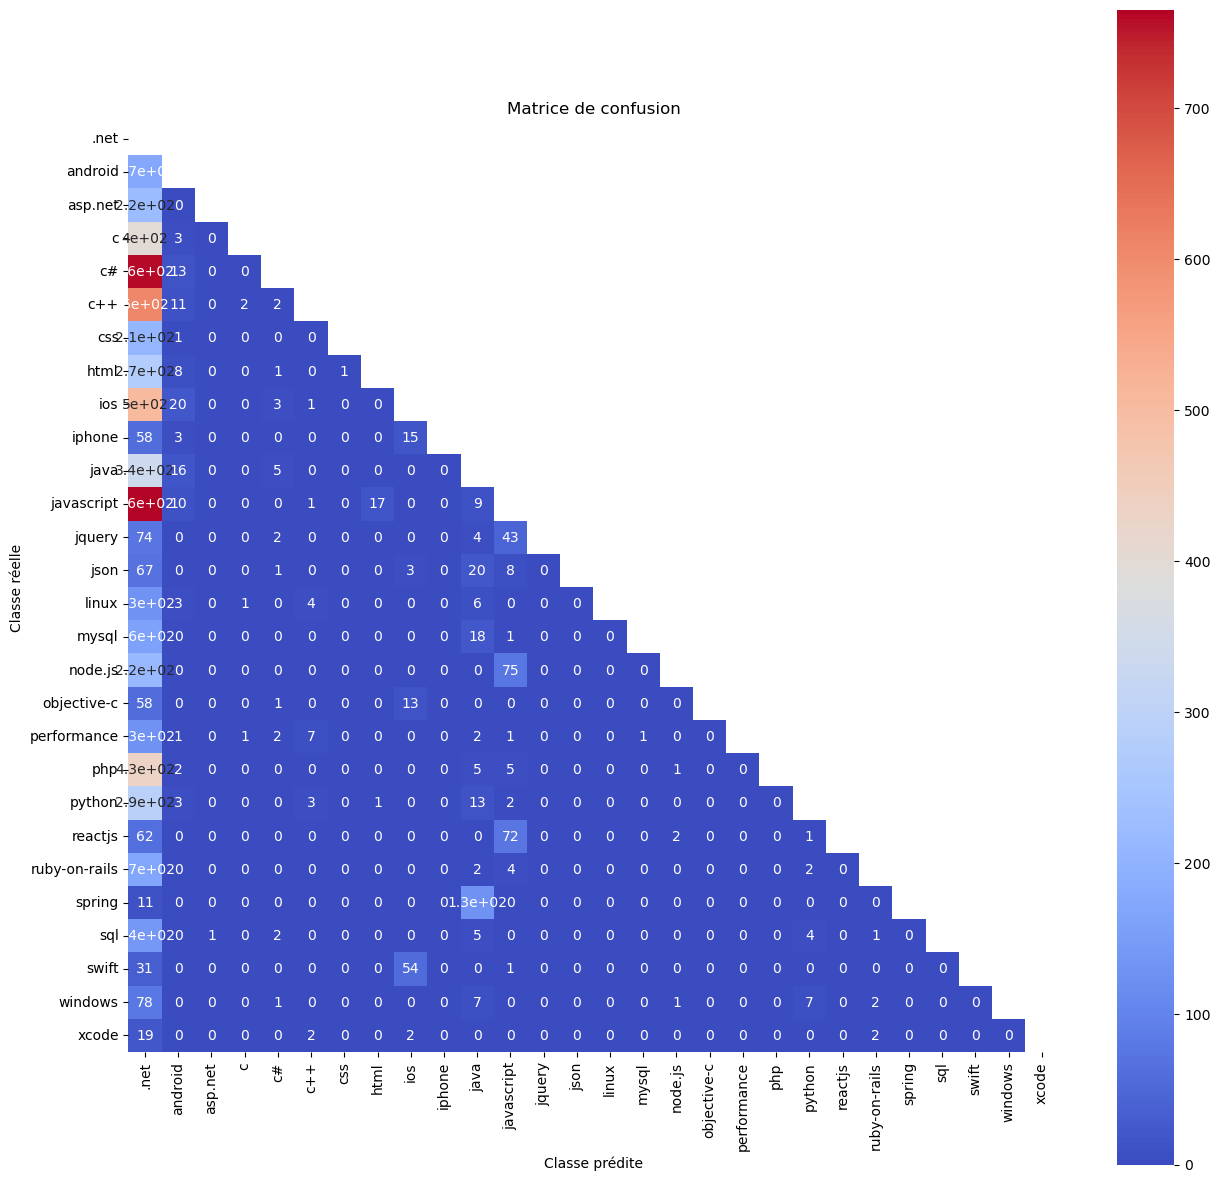

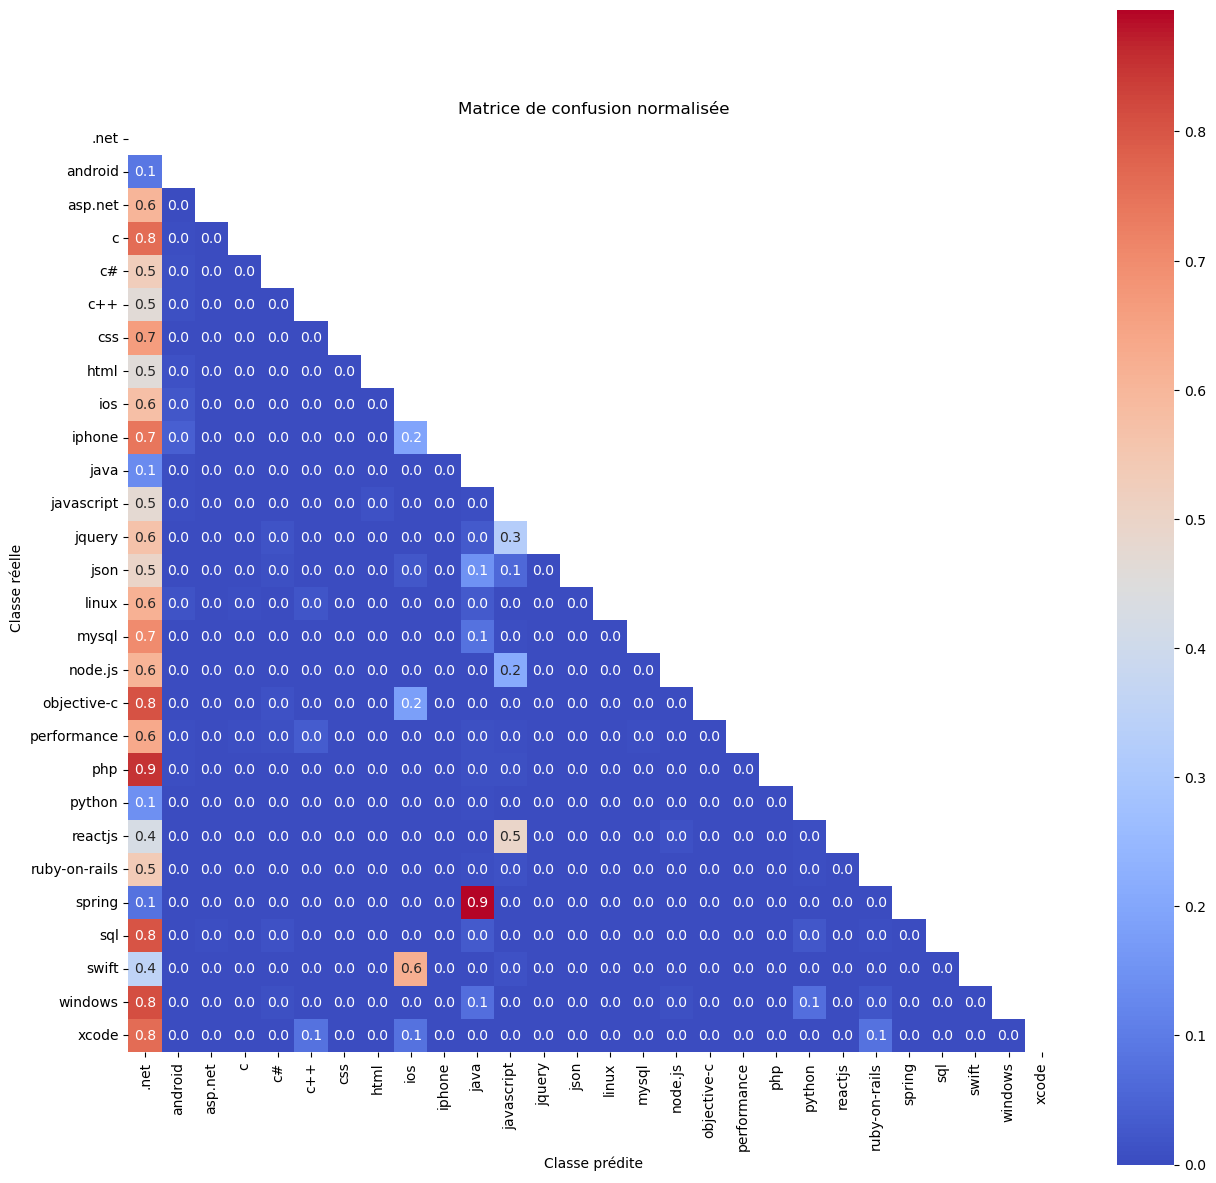

In [102]:
metriques_algo(y_test_in              = y_test_stemmer,
               y_pred_in              = y_pred_stemmer_randomforest,
               afficher_all_matrices = True)

# Test Set Accuracy = 0.364

In [ ]:
#######################################
#        Algorithme LinearSVC         #
#######################################

In [103]:
y_pred_stemmer_LinearSVC = algorithme_ovr(model_in                   = LinearSVC(),
                                          model_name_in              = 'LinearSVC',
                                          X_train_in                 = X_train_stemmer, 
                                          y_train_in                 = y_train_stemmer, 
                                          X_test_in                  = X_test_stemmer,
                                          feature_extraction_type_in = 'NLTK_stemmer')

# PC : 1.589 min

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 28910.026 --> stop : 29005.375 ) = 95.348 sec ou 1.589 min



Test Set Accuracy	= 0.323 

F1 score		= 0.562 , average = micro
F1 score		= 0.385 , average = macro
F1 score		= 0.499 , average = samples
F1 score		= 0.541 , average = weighted


Jaccard score		= 0.39 , average = micro
Jaccard score		= 0.265 , average = macro
Jaccard score		= 0.453 , average = samples
Jaccard score		= 0.402 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.30      0.09      0.14       883
           1       0.88      0.80      0.84      1983
           2       0.27      0.11      0.15       397
           3       0.41      0.21      0.28       532
           4       0.72      0.57      0.64      2332
           5       0.76      0.51      0.61      1485
           6       0.38      0.30      0.34       322
           7       0.45      0.24      0.31       753
           8       0.63      0.44      0.52       945
           9       0.13      0.06      0.08       191
          10       0.70      0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


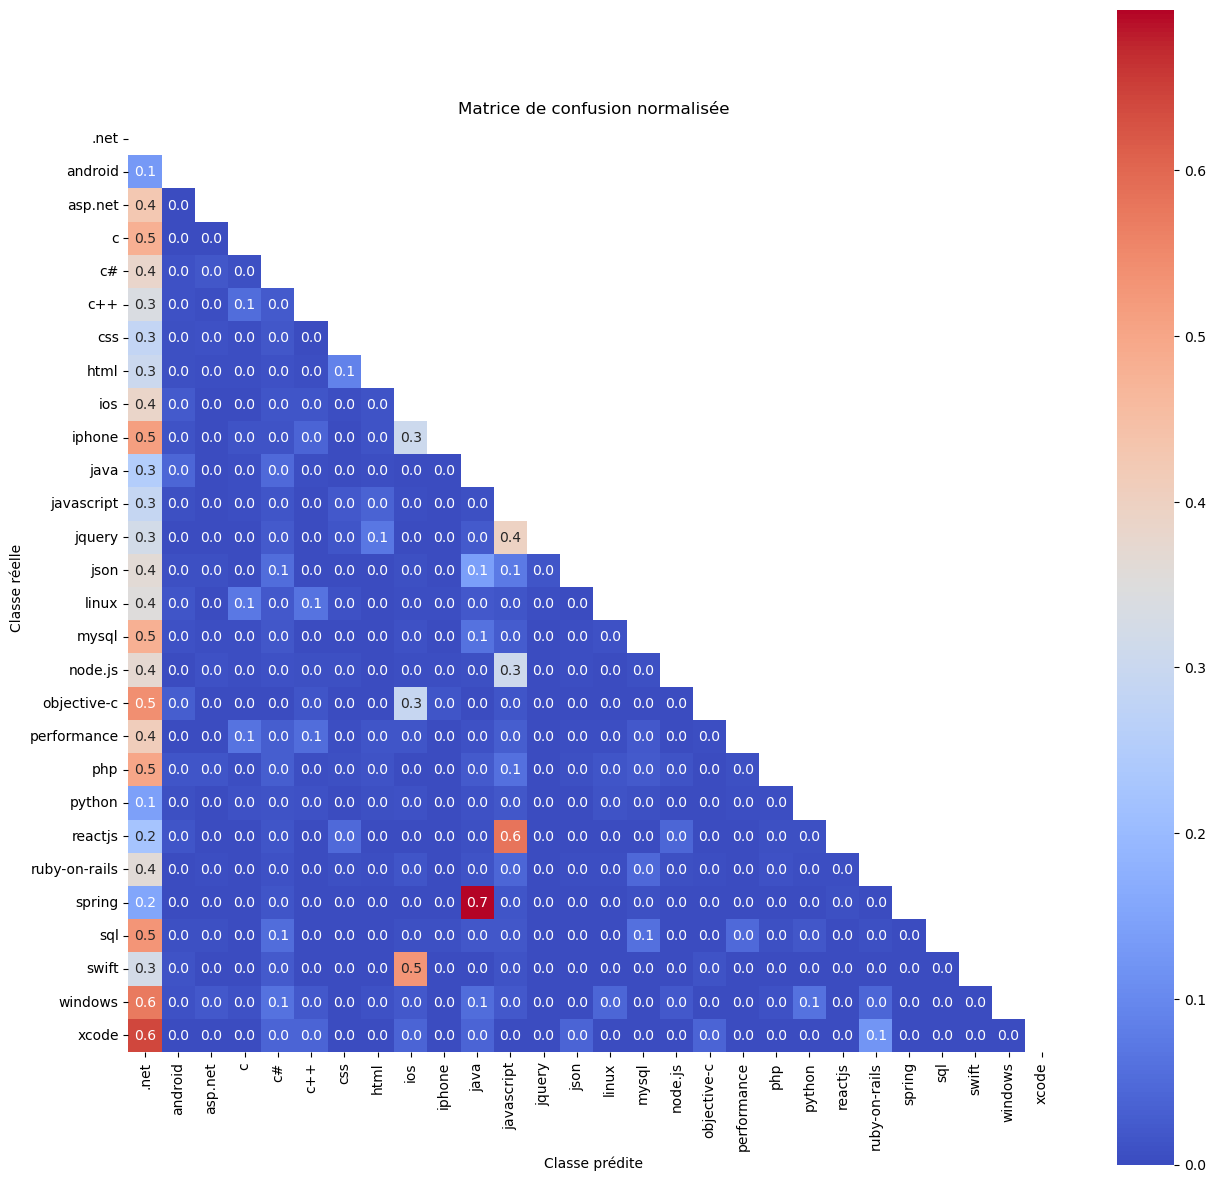

In [104]:
metriques_algo(y_test_in = y_test_stemmer,
               y_pred_in = y_pred_stemmer_LinearSVC)

# Test Set Accuracy = 0.323

# 4.1.2. ALGORITHMES DONNEES LEMMA

In [ ]:
######################################################
#       Découpage données X, y en train / test       # 
######################################################

In [ ]:
# SYNTHESE DECOUPAGE TRAIN / TEST :
#---------------|--------------------|----------------------------------------------------------------------------------|
#               |        X           |              Données train / test                                                |
#---------------|--------------------|----------------------------------------------------------------------------------|
#  Données      | df_lemma           | X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma                         |
#---------------|--------------------|----------------------------------------------------------------------------------|

In [105]:
X_train_lemma, X_test_lemma, \
y_train_lemma, y_test_lemma = decoupage_train_test(X_in = df_lemma,
                                                   y_in = y)

X_train shape	= (32170, 2818)
X_test shape	= (17323, 2818)
y_train shape	= (32170, 28)
y_test shape	= (17323, 28)


In [ ]:
#######################################
#       Algorithme RandomForest       #
#######################################

In [106]:
y_pred_lemma_randomforest = algorithme_ovr(model_in                   = RandomForestClassifier(),
                                           model_name_in              = 'RandomForestClassifier',                   
                                           X_train_in                 = X_train_lemma, 
                                           y_train_in                 = y_train_lemma, 
                                           X_test_in                  = X_test_lemma,
                                           feature_extraction_type_in = 'NLTK_lemma')

# PC : 33.019 min

Durée programme (start : 29278.244 --> stop : 31259.405 ) = 1981.160 sec ou 33.019 min



Test Set Accuracy	= 0.37 

F1 score		= 0.584 , average = micro
F1 score		= 0.291 , average = macro
F1 score		= 0.498 , average = samples
F1 score		= 0.515 , average = weighted


Jaccard score		= 0.412 , average = micro
Jaccard score		= 0.215 , average = macro
Jaccard score		= 0.466 , average = samples
Jaccard score		= 0.406 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.50      0.00      0.00       883
           1       0.95      0.89      0.92      1983
           2       0.00      0.00      0.00       397
           3       0.96      0.04      0.08       532
           4       0.90      0.45      0.60      2332
           5       0.91      0.45      0.60      1485
           6       1.00      0.02      0.03       322
           7       0.72      0.13      0.21       753
           8       0.77      0.32      0.46       945
           9       0.00      0.00      0.00       191
          10       0.87      0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


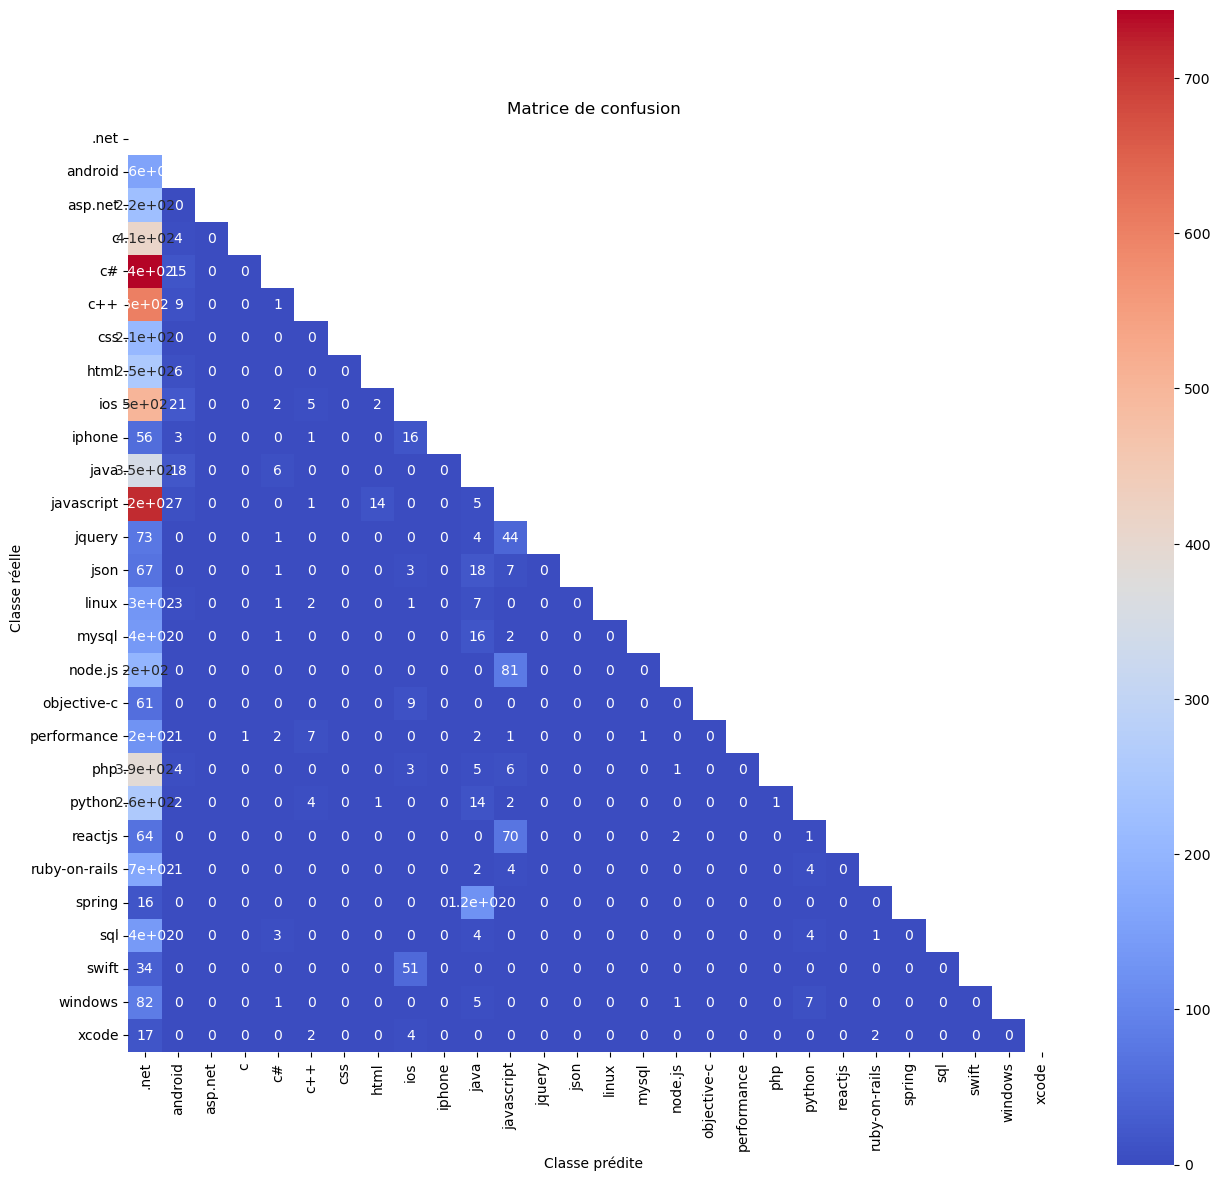

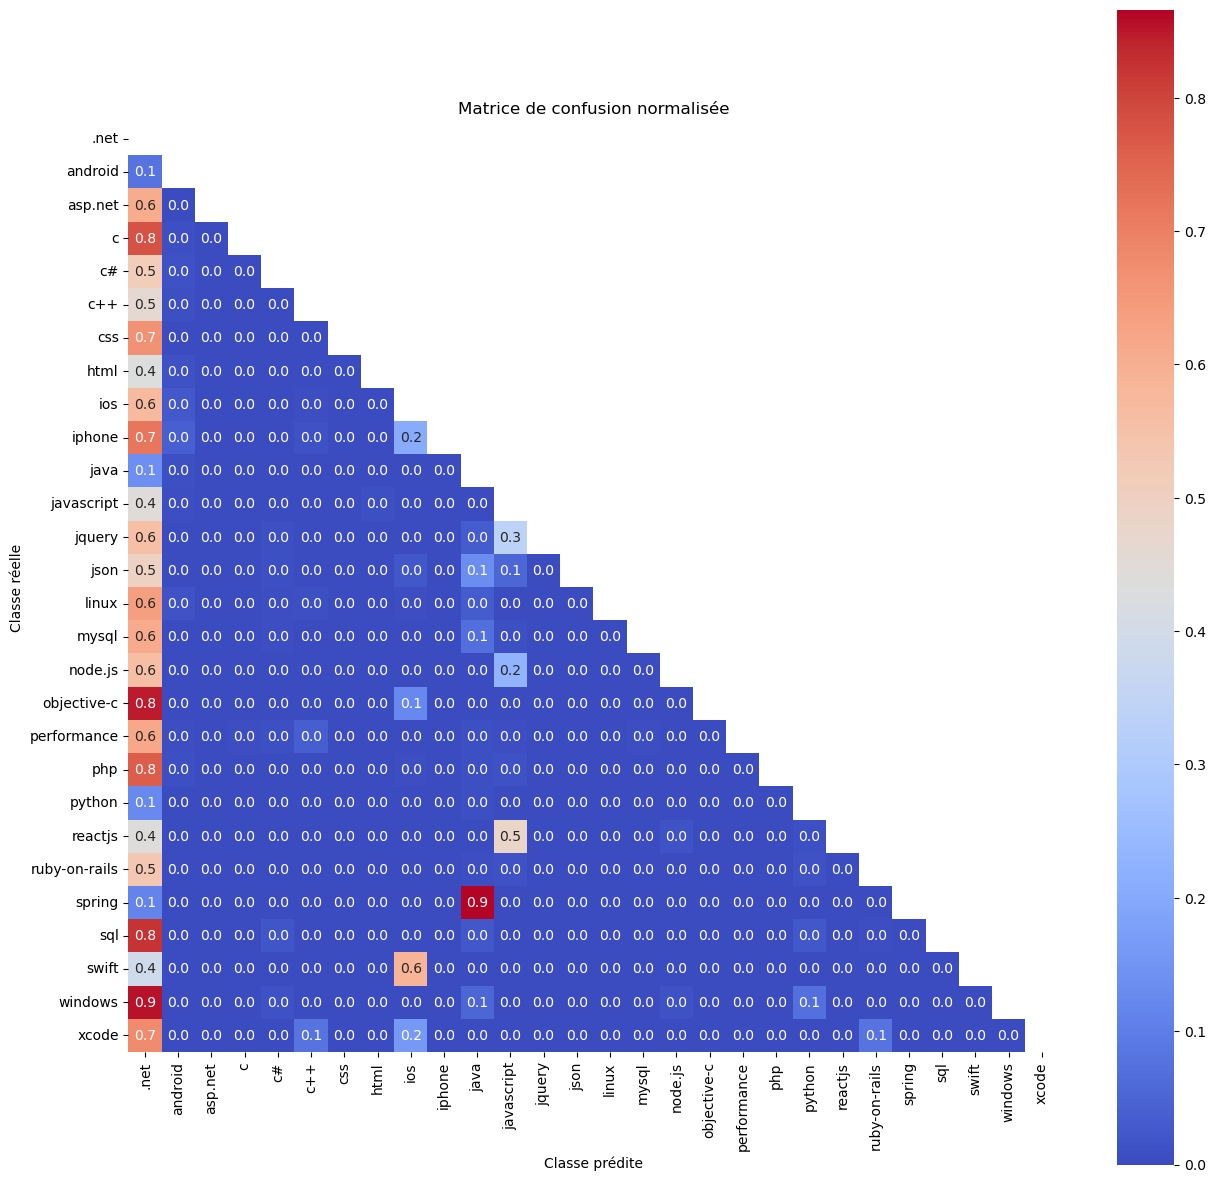

In [107]:
metriques_algo(y_test_in             = y_test_lemma,
               y_pred_in             = y_pred_lemma_randomforest,
               afficher_all_matrices = True)

# Test Set Accuracy = 0.37

In [ ]:
#######################################
#        Algorithme LinearSVC         #
#######################################

In [108]:
y_pred_lemma_LinearSVC = algorithme_ovr(model_in                   = LinearSVC(),
                                        model_name_in              = 'LinearSVC',
                                        X_train_in                 = X_train_lemma, 
                                        y_train_in                 = y_train_lemma, 
                                        X_test_in                  = X_test_lemma,
                                        feature_extraction_type_in = 'NLTK_lemma')

# PC : 1.350 min

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 31482.248 --> stop : 31563.245 ) = 80.996 sec ou 1.350 min



Test Set Accuracy	= 0.333 

F1 score		= 0.563 , average = micro
F1 score		= 0.413 , average = macro
F1 score		= 0.536 , average = samples
F1 score		= 0.565 , average = weighted


Jaccard score		= 0.392 , average = micro
Jaccard score		= 0.284 , average = macro
Jaccard score		= 0.482 , average = samples
Jaccard score		= 0.422 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.33      0.19      0.24       883
           1       0.89      0.79      0.84      1983
           2       0.25      0.21      0.23       397
           3       0.36      0.41      0.39       532
           4       0.70      0.63      0.67      2332
           5       0.69      0.56      0.62      1485
           6       0.31      0.40      0.35       322
           7       0.44      0.34      0.39       753
           8       0.55      0.54      0.54       945
           9       0.13      0.18      0.15       191
          10       0.75      

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


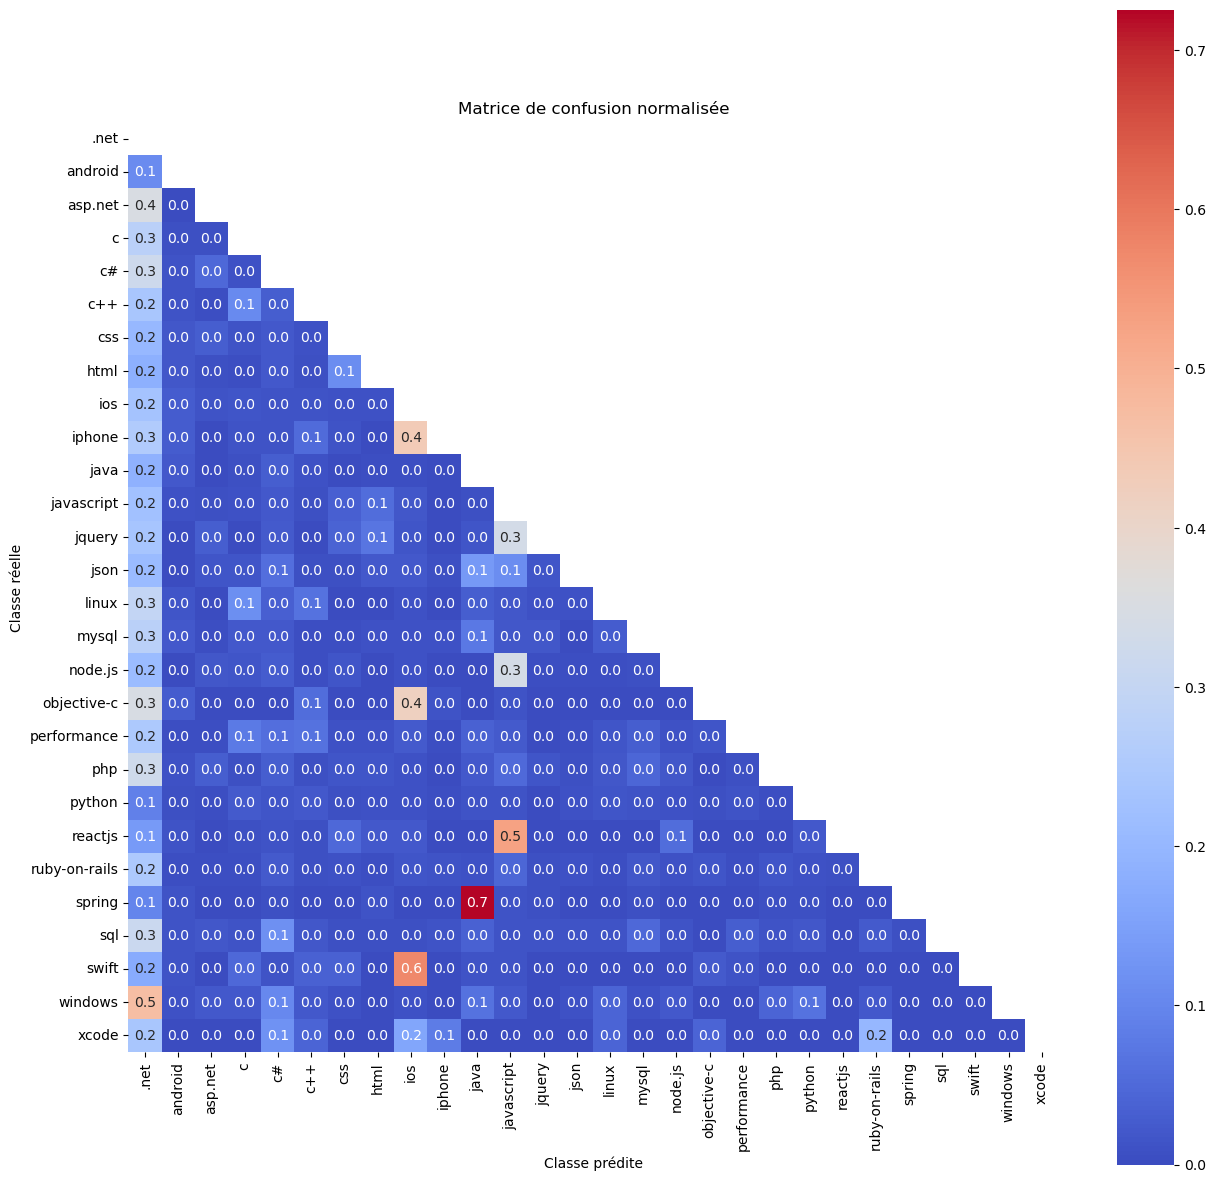

In [109]:
metriques_algo(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_LinearSVC)

# Test Set Accuracy = 0.333

# 4.2. COUNTVECTORIZER & STANDARDISATION DES DONNEES

In [ ]:
# https://ichi.pro/fr/analyse-en-composantes-principales-acp-avec-scikit-learn-33554981925296
# https://stacklima.com/analyse-des-composants-principaux-avec-python/

In [ ]:
########################################################################
# Standardisation des données (uniquement si problème de performance)  #
########################################################################
# https://ichi.pro/fr/pca-utilisant-python-scikit-learn-253248327425632
# https://www.geeksforgeeks.org/how-to-standardize-data-in-a-pandas-dataframe/
# https://www.kaggle.com/code/lilyelizabethjohn/standardization-using-standardscaler
# https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# https://stacklima.com/comment-mettre-a-l-echelle-les-colonnes-pandas-dataframe/

In [110]:
# Define standard scaler
scaler_lemma   = StandardScaler()
scaler_stemmer = StandardScaler()

In [111]:
# Transform data
df_norm_lemma = scaler_lemma.fit_transform(df_lemma)

# Maj type : numpy.ndarray --> panda dataframe
df_norm_lemma = pd.DataFrame(df_norm_lemma, columns = df_lemma.columns)

print('df_norm_lemma =', df_norm_lemma.shape) 

df_norm_lemma = (49493, 2818)


In [112]:
# Transform data
df_norm_stemmer = scaler_stemmer.fit_transform(df_stemmer)

# Maj type : numpy.ndarray --> panda dataframe
df_norm_stemmer = pd.DataFrame(df_norm_stemmer, columns = df_stemmer.columns)

print('df_norm_stemmer =', df_norm_stemmer.shape)

df_norm_stemmer = (49493, 1633)


In [113]:
# Vérification que la moyenne = 0 et l'écart type = 1
idx = ['mean', 'std']

In [114]:
# transpose met les attributs en ligne pour + de lisibilité
pd.DataFrame(df_norm_lemma).describe().round(2).loc[idx, :].transpose()

mean  std
aba           -0.0  1.0
abac           0.0  1.0
abbreviation   0.0  1.0
abort          0.0  1.0
absolute       0.0  1.0
...            ...  ...
zeus           0.0  1.0
zip            0.0  1.0
zipper        -0.0  1.0
zone          -0.0  1.0
zoo            0.0  1.0

[2818 rows x 2 columns]

In [115]:
# transpose met les attributs en ligne pour + de lisibilité
pd.DataFrame(df_norm_stemmer).describe().round(2).loc[idx, :].transpose()

mean  std
aba        -0.0  1.0
abac        0.0  1.0
abort       0.0  1.0
abstract   -0.0  1.0
accordion   0.0  1.0
...         ...  ...
zero        0.0  1.0
zip         0.0  1.0
zipper     -0.0  1.0
zone       -0.0  1.0
zoo         0.0  1.0

[1633 rows x 2 columns]

In [ ]:
# SYNTHESE STANDARDISATION DONNEES :
#-------------|-----------------|---------|
#             |        X        |    y    |
#-------------|-----------------|---------|
#             | df_lemma        |         |
#   Données   |-----------------|    y    |
#             | df_stemmer      |         |
#-------------|-----------------|---------|
#             | df_norm_lemma   |         |
# Standardisé |-----------------|    /    |
#             | df_norm_stemmer |         |
#-------------|-----------------|---------|

# 4.2.2. ALGORITHMES DONNEES STEMMER

In [ ]:
# SYNTHESE DECOUPAGE TRAIN / TEST :
#---------------|--------------------|----------------------------------------------------------------------------------|
#               |        X           |              Données train / test                                                |
#---------------|--------------------|----------------------------------------------------------------------------------|
# Données       | df_norm_stemmer    |               /                                                                  |
# standardisées |                    |                                                                                  |
#---------------|--------------------|----------------------------------------------------------------------------------|

# 4.2.2. ALGORITHMES DONNEES LEMMA

In [ ]:
# SYNTHESE DECOUPAGE TRAIN / TEST :
#---------------|--------------------|----------------------------------------------------------------------------------|
#               |        X           |              Données train / test                                                |
#---------------|--------------------|----------------------------------------------------------------------------------|
# Données       | df_norm_lemma      |               /                                                                  |
# standardisées |                    |                                                                                  |
#---------------|--------------------|----------------------------------------------------------------------------------|

# 4.3. COUNTVECTORIZER & REDUCTION DE DIMENSION (ACP)

In [116]:
##########################################################################
# ACP sur notre ensemble de données (non normalisées et normalisées)     #
# pour voir comment il capture la variance des données.                  #
##########################################################################
def PCA_all(data_in, 
            data_name_in, 
            data_norm_in, 
            data_norm_name_in):
    
    # Nombre de colonnes
    nb_colonnes      = len(data_in.columns)
    nb_colonnes_norm = len(data_norm_in.columns)
    print('nb_colonnes\t\t= ', nb_colonnes)
    print('nb_colonnes_norm\t= ', nb_colonnes_norm, '\n')
    
    
    # PCA sur l'ensemble des données
    pca_all = PCA(n_components = nb_colonnes)
    pca_all.fit(data_in)
    
    pca_all_norm = PCA(n_components = nb_colonnes_norm)
    pca_all_norm.fit(data_norm_in)
    
    
    # Explained variance
    pca_all.explained_variance_ratio_
    pca_all_norm.explained_variance_ratio_        
    
    # Variance captée pour chaque composante
    scree      = (pca_all.explained_variance_ratio_ * 100).round(2)
    scree_norm = (pca_all_norm.explained_variance_ratio_ * 100).round(2)    
    print('scree\t\t\t=', scree)
    print('scree_norm\t\t=', scree_norm, '\n')    
    
    # Somme cumulée
    scree_cum      = scree.cumsum().round()
    scree_cum_norm = scree_norm.cumsum().round()    
    print('scree_cum\t\t=', scree_cum)
    print('scree_cum_norm\t\t=', scree_cum_norm, '\n')
    
    for pca in [pca_all, pca_all_norm]:
        if(pca == pca_all):
            print('@' * 32, data_name_in, ': pca_all', '@' * 32)
        elif(pca == pca_all_norm):
            print('\n')
            print('@' * 27, data_norm_name_in, ': pca_all_norm', '@' * 27)
        
        print('Variance explained by the First principal component\t=', np.cumsum(pca.explained_variance_ratio_ * 100)[0])
        print('Variance explained by the 2 principal components\t=', np.cumsum(pca.explained_variance_ratio_ * 100)[1])
        print('Variance explained by the 3 principal components\t=', np.cumsum(pca.explained_variance_ratio_ * 100)[2])
        print('Variance explained by the 10 principal components\t=', np.cumsum(pca.explained_variance_ratio_ * 100)[9])
        print('Variance explained by the 25 principal components\t=', np.cumsum(pca.explained_variance_ratio_ * 100)[24])    
        print('Variance explained by the 50 principal components\t=', np.cumsum(pca.explained_variance_ratio_ * 100)[49])
        if (nb_colonnes >= 99):
            print('Variance explained by the 100 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[99])
        if (nb_colonnes >= 499):
            print('Variance explained by the 500 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[499])
        if (nb_colonnes >= 749):
            print('Variance explained by the 750 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[749])        
        if (nb_colonnes >= 999):
            print('Variance explained by the 1000 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[999]) 
        if (nb_colonnes >= 1199):
            print('Variance explained by the 1200 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[1199]) 
        if (nb_colonnes >= 1499):
            print('Variance explained by the 1500 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[1499])   
        if (nb_colonnes >= 1999):
            print('Variance explained by the 2000 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[1999])
        if (nb_colonnes >= 2499):
            print('Variance explained by the 2500 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[2499])
        if (nb_colonnes >= 2799):
            print('Variance explained by the 2800 principal components\t=', 
                  np.cumsum(pca.explained_variance_ratio_ * 100)[2799])              
    
    
    # Variable avec la liste de nos composantes :
    x_list      = range(1, nb_colonnes + 1)
    x_list_norm = range(1, nb_colonnes_norm + 1)    
    list(x_list)
    list(x_list_norm)    
    
    
    # Graphique éboulis des valeurs graphiques (scree plot)
    # Remarque : on a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.
    plt.bar(x_list, scree)
    plt.bar(x_list_norm, scree_norm)
    
    plt.plot(x_list,      scree_cum,      c = 'red',  marker = 'o', label = data_name_in)
    plt.plot(x_list_norm, scree_cum_norm, c = 'blue', marker = 'o', label = data_norm_name_in)    
    plt.xlabel('Rang de l\'axe d\'inertie')
    plt.ylabel('Pourcentage d\'inertie')
    plt.title('Eboulis des valeurs propres')
    plt.legend(loc = 'best') # pour afficher label
    plt.show()

In [117]:
# Maj liste colonnes des principales composantes ('PC1', ..., 'PC1000')
def nom_colonne_PCA(nb_composant_in):
    columns = []
    for i in range(nb_composant_in):
        columns.append('PC' + str(i+1))
    print('10 premières colonnes :', columns[0:10])
    print('10 dernières colonnes :', columns[nb_composant_in-10:nb_composant_in])
    return columns

In [118]:
def PCA_reduit(data_in, n_components_in):
    
    # Appliquons PCA sur un nombre réduit de composants
    pca_reduit = PCA(n_components = n_components_in)
    pca_reduit.fit(data_in)
    data_pca_reduit = pca_reduit.transform(data_in)
    
    return data_pca_reduit

In [ ]:
#############################################
# PCA pour df_lemma & df_norm_lemma         #
#############################################

nb_colonnes		=  2818
nb_colonnes_norm	=  2818 

scree			= [16.22 10.82  3.1  ...  0.    0.    0.  ]
scree_norm		= [0.29 0.28 0.25 ... 0.   0.   0.  ] 

scree_cum		= [16. 27. 30. ... 99. 99. 99.]
scree_cum_norm		= [  0.   1.   1. ... 100. 100. 100.] 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ df_lemma : pca_all @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Variance explained by the First principal component	= 16.222886657369283
Variance explained by the 2 principal components	= 27.045574014043183
Variance explained by the 3 principal components	= 30.141612877628738
Variance explained by the 10 principal components	= 43.05360342700396
Variance explained by the 25 principal components	= 55.0685414213623
Variance explained by the 50 principal components	= 65.83142624104676
Variance explained by the 100 principal components	= 76.91426858450863
Variance explained by the 500 principal components	= 95.53069431685334
Variance explained by the 750 principal components	= 97.88931285458689
Variance explained by the 100

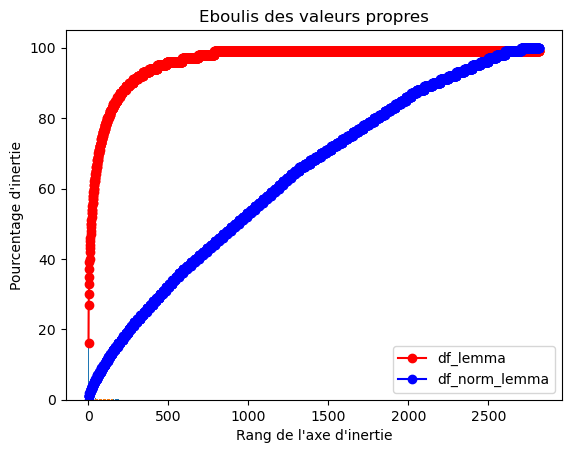

In [119]:
PCA_all(data_in           = df_lemma, 
        data_name_in      = 'df_lemma', 
        data_norm_in      = df_norm_lemma, 
        data_norm_name_in = 'df_norm_lemma')

# df_lemma :
#   - 97 % de la variance est comprise dans les 750 premières composantes sur 2.818.
#
# df_norm_lemma :
#   - 85 % de la variance est comprise dans les 2.000 premières composantes sur 2.818.

In [ ]:
#--------------------------------------------------------#
# Calculs pour df_lemma :                                #
# 97 % de la variance avec 750 composants principaux     #
#--------------------------------------------------------#

In [120]:
data_pca_lemma_750 = PCA_reduit(data_in         = df_lemma,
                                n_components_in = 750)

In [121]:
df_pca_lemma_750 = pd.DataFrame(data_pca_lemma_750, 
                                columns = nom_colonne_PCA(nb_composant_in = 750))

df_pca_lemma_750.shape

10 premières colonnes : ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
10 dernières colonnes : ['PC741', 'PC742', 'PC743', 'PC744', 'PC745', 'PC746', 'PC747', 'PC748', 'PC749', 'PC750']


(49493, 750)

In [ ]:
#############################################
# PCA pour df_stemmer & df_norm_stemmer     #
#############################################

nb_colonnes		=  1633
nb_colonnes_norm	=  1633 

scree			= [17.   11.3   3.26 ...  0.    0.    0.  ]
scree_norm		= [0.44 0.37 0.3  ... 0.   0.   0.  ] 

scree_cum		= [17. 28. 32. ... 99. 99. 99.]
scree_cum_norm		= [  0.   1.   1. ... 100. 100. 100.] 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ df_stemmer : pca_all @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Variance explained by the First principal component	= 17.003982336017835
Variance explained by the 2 principal components	= 28.30380258308386
Variance explained by the 3 principal components	= 31.55935043003072
Variance explained by the 10 principal components	= 45.21118566710032
Variance explained by the 25 principal components	= 57.92761341521275
Variance explained by the 50 principal components	= 69.26458212677251
Variance explained by the 100 principal components	= 81.10649187652812
Variance explained by the 500 principal components	= 98.41038779824693
Variance explained by the 750 principal components	= 99.57503058666033
Variance explained by the 10

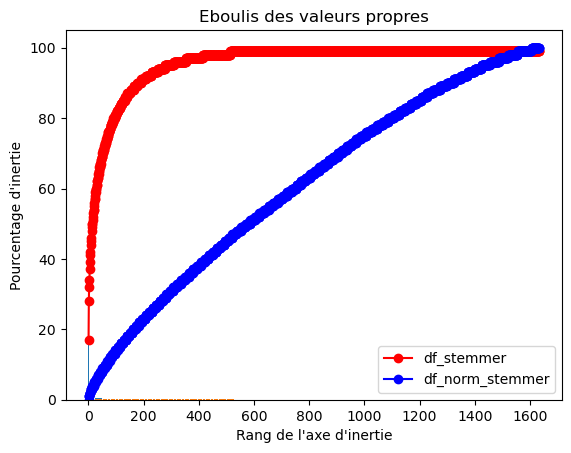

In [122]:
PCA_all(data_in           = df_stemmer, 
        data_name_in      = 'df_stemmer', 
        data_norm_in      = df_norm_stemmer, 
        data_norm_name_in = 'df_norm_stemmer')

# df_stemmer :
#   - 98 % de la variance est comprise dans les 500 premières composantes sur 1.633.

# df_norm_stemmer :
#   - 85 % de la variance est comprise dans les 1.200 premières composantes sur 1.633.

In [ ]:
#--------------------------------------------------------#
# Calculs pour df_stemmer :                              #
# 98 % de la variance avec 500 composants principaux     #
#--------------------------------------------------------#

In [123]:
data_pca_stemmer_500 = PCA_reduit(data_in         = df_stemmer,
                                  n_components_in = 500)

In [124]:
df_pca_stemmer_500 = pd.DataFrame(data_pca_stemmer_500, 
                                  columns = nom_colonne_PCA(nb_composant_in = 500))

df_pca_stemmer_500.shape

10 premières colonnes : ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
10 dernières colonnes : ['PC491', 'PC492', 'PC493', 'PC494', 'PC495', 'PC496', 'PC497', 'PC498', 'PC499', 'PC500']


(49493, 500)

In [ ]:
# SYNTHESE REDUCTION DONNEES (ACP) :
#-------------|-----------------|------------------------------------|
#             |        X        |              PCA                   |
#-------------|-----------------|------------------------------------|
#             | df_lemma        | df_pca_lemma_750 (97 % variance)   |
#  Données    |-----------------|------------------------------------|
#             | df_stemmer      | df_pca_stemmer_500 (98 % variance) |
#-------------|-----------------|------------------------------------|

# 4.3.1. ALGORITHMES DONNEES STEMMER

In [ ]:
######################################################
#       Découpage données X, y en train / test       #
######################################################

In [ ]:
# SYNTHESE DECOUPAGE TRAIN / TEST :
#---------------|--------------------|----------------------------------------------------------------------------------|
#               |        X           |              Données train / test                                                |
#---------------|--------------------|----------------------------------------------------------------------------------|
#  Données PCA  | df_pca_stemmer_500 | X_train_stemmer_500, X_test_stemmer_500, y_train_stemmer_500, y_test_stemmer_500 |
#---------------|--------------------|----------------------------------------------------------------------------------| 

In [125]:
# 500 composantes principales
X_train_stemmer_500, X_test_stemmer_500, \
y_train_stemmer_500, y_test_stemmer_500 = decoupage_train_test(X_in = df_pca_stemmer_500,
                                                               y_in = y)

X_train shape	= (32170, 500)
X_test shape	= (17323, 500)
y_train shape	= (32170, 28)
y_test shape	= (17323, 28)


In [ ]:
#######################################
#       Algorithme RandomForest       #
#######################################

In [126]:
y_pred_stemmer_randomforest_500 = algorithme_ovr(model_in                   = RandomForestClassifier(),
                                                 model_name_in              = 'RandomForestClassifier',
                                                 X_train_in                 = X_train_stemmer_500,
                                                 y_train_in                 = y_train_stemmer_500, 
                                                 X_test_in                  = X_test_stemmer_500,
                                                 feature_extraction_type_in = 'NLTK_stemmer_500')

# Durée programme = 48.980 min

Durée programme (start : 32702.699 --> stop : 35641.495 ) = 2938.796 sec ou 48.980 min



Test Set Accuracy	= 0.199 

F1 score		= 0.366 , average = micro
F1 score		= 0.16 , average = macro
F1 score		= 0.27 , average = samples
F1 score		= 0.318 , average = weighted


Jaccard score		= 0.224 , average = micro
Jaccard score		= 0.105 , average = macro
Jaccard score		= 0.252 , average = samples
Jaccard score		= 0.221 , average = weighted




C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification metrics =
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       883
           1       0.97      0.68      0.80      1983
           2       0.50      0.00      0.01       397
           3       0.56      0.01      0.02       532
           4       0.92      0.15      0.26      2332
           5       0.86      0.15      0.26      1485
           6       0.71      0.02      0.03       322
           7       0.70      0.05      0.09       753
           8       0.87      0.12      0.22       945
           9       0.00      0.00      0.00       191
          10       0.88      0.52      0.66      3096
          11       0.79      0.18      0.30      2223
          12       0.00      0.00      0.00       470
          13       0.00      0.00      0.00       295
          14       0.33      0.00      0.01       369
          15       0.00      0.00      0.00       284
          16       0.88      0.09      0.15       741
 

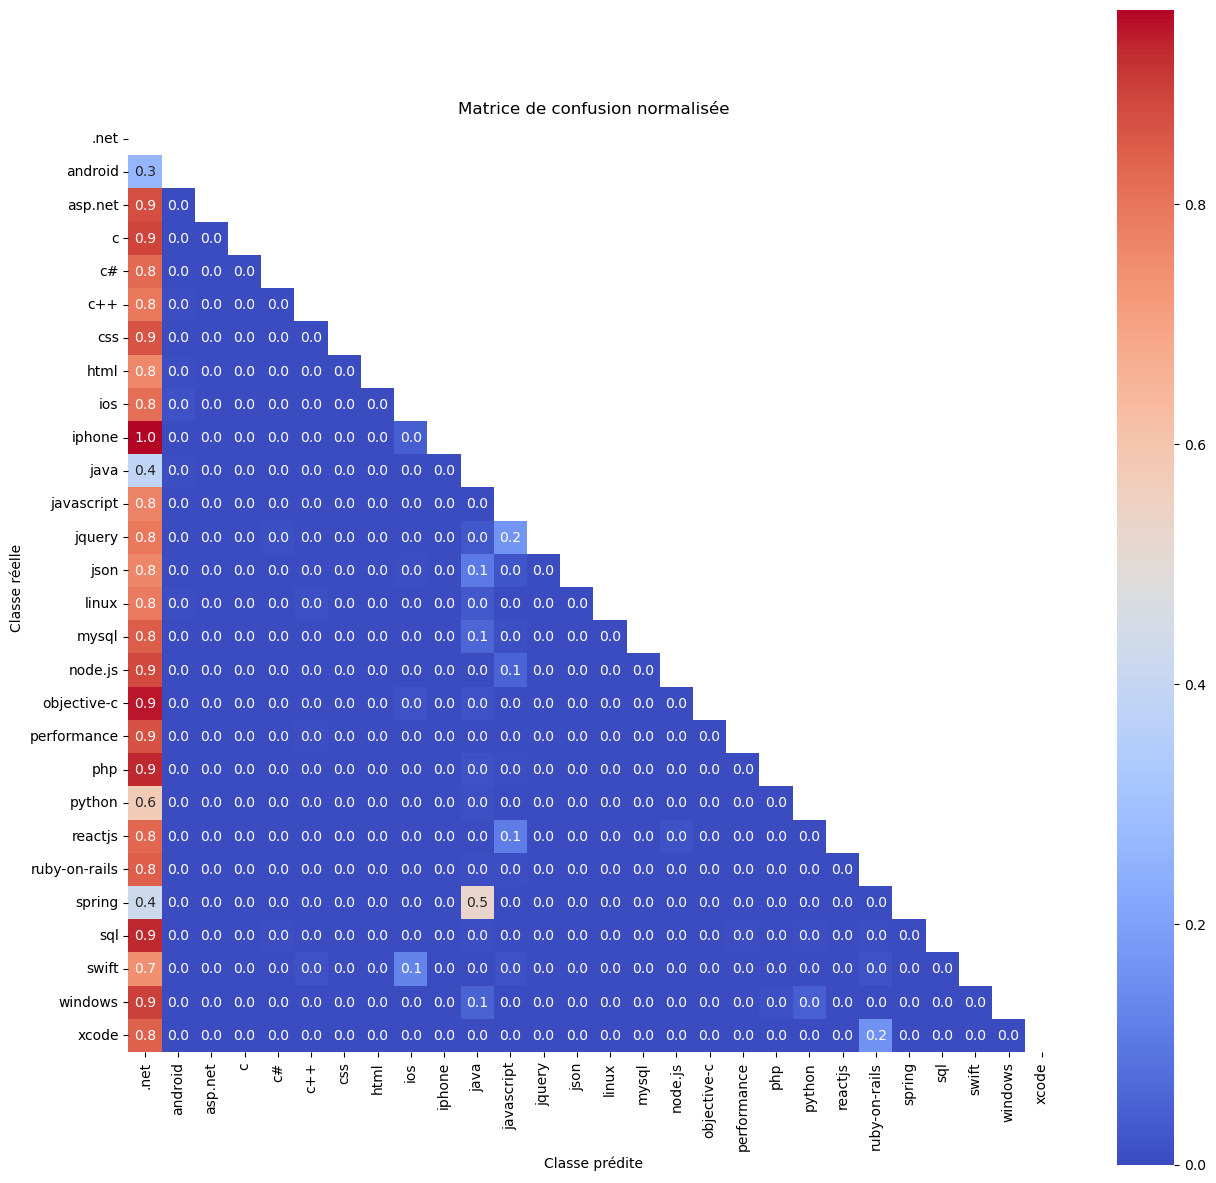

In [127]:
metriques_algo(y_test_in = y_test_stemmer_500,
               y_pred_in = y_pred_stemmer_randomforest_500)

# Test Set Accuracy = 0.199

In [ ]:
#######################################
#        Algorithme LinearSVC         #
#######################################

In [130]:
y_pred_stemmer_LinearSVC_500 = algorithme_ovr(model_in                   = LinearSVC(), 
                                              model_name_in              = 'LinearSVC',
                                              X_train_in                 = X_train_stemmer_500, 
                                              y_train_in                 = y_train_stemmer_500, 
                                              X_test_in                  = X_test_stemmer_500,
                                              feature_extraction_type_in = 'NLTK_stemmer_500')

# Durée programme = 18.984 min

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 1292.241 --> stop : 2431.292 ) = 1139.051 sec ou 18.984 min



Test Set Accuracy	= 0.325 

F1 score		= 0.552 , average = micro
F1 score		= 0.358 , average = macro
F1 score		= 0.47 , average = samples
F1 score		= 0.52 , average = weighted


Jaccard score		= 0.381 , average = micro
Jaccard score		= 0.248 , average = macro
Jaccard score		= 0.432 , average = samples
Jaccard score		= 0.386 , average = weighted




C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification metrics =
               precision    recall  f1-score   support

           0       0.37      0.05      0.08       883
           1       0.93      0.77      0.84      1983
           2       0.39      0.10      0.16       397
           3       0.51      0.20      0.29       532
           4       0.73      0.52      0.61      2332
           5       0.77      0.52      0.62      1485
           6       0.49      0.22      0.31       322
           7       0.53      0.24      0.33       753
           8       0.64      0.44      0.52       945
           9       0.16      0.02      0.03       191
          10       0.78      0.53      0.63      3096
          11       0.68      0.45      0.54      2223
          12       0.35      0.09      0.14       470
          13       0.17      0.02      0.03       295
          14       0.33      0.11      0.16       369
          15       0.32      0.07      0.12       284
          16       0.72      0.36      0.48       741
 

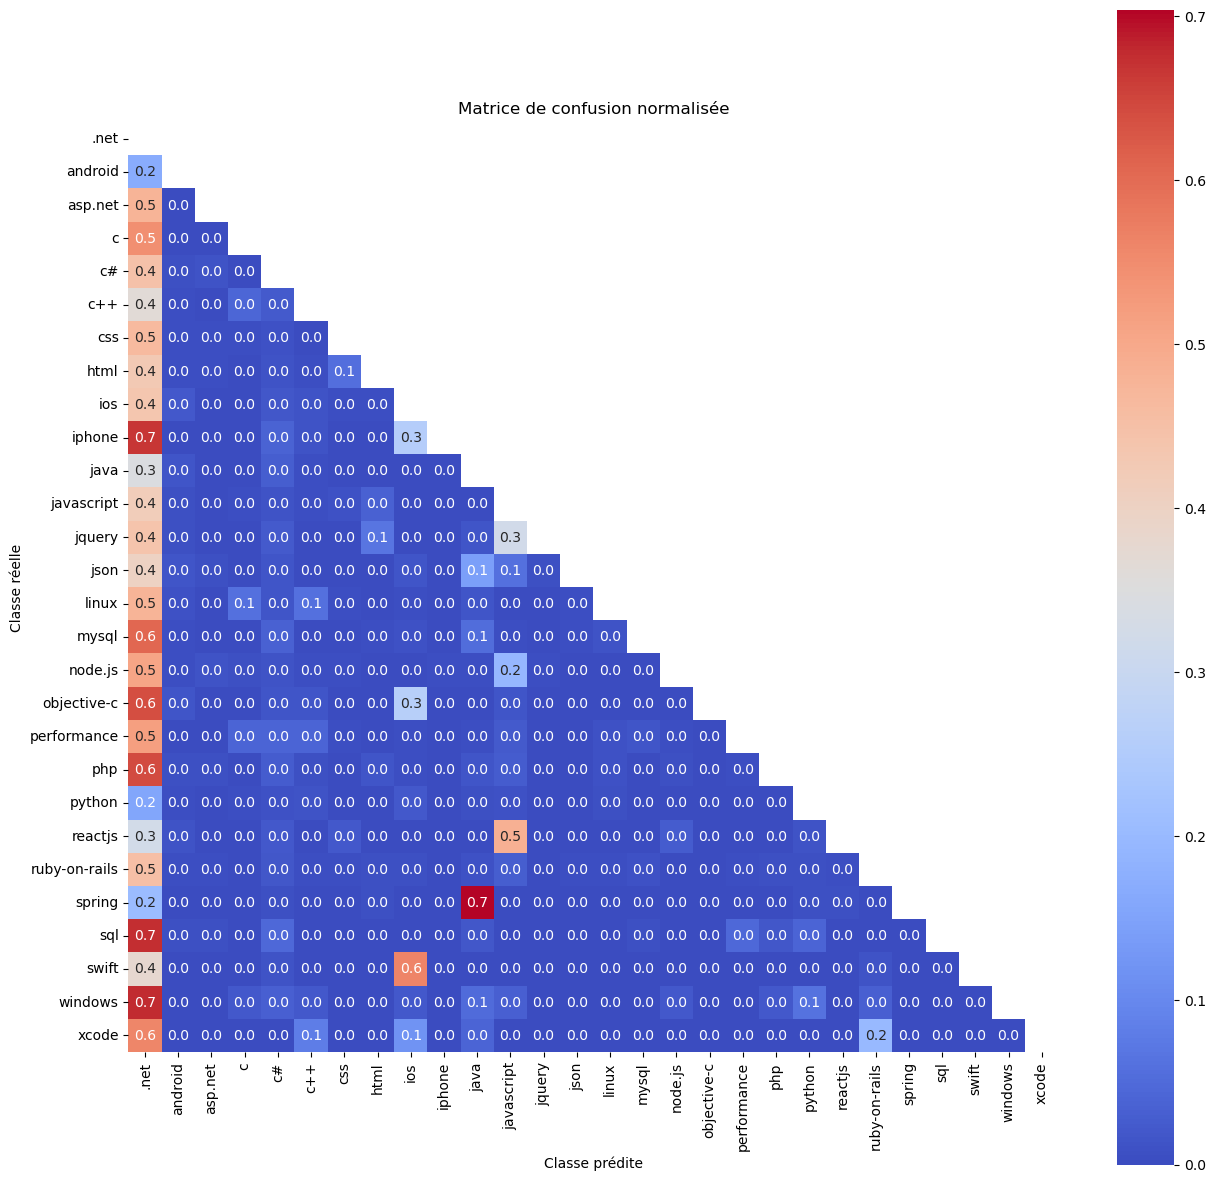

In [131]:
metriques_algo(y_test_in = y_test_stemmer_500,
               y_pred_in = y_pred_stemmer_LinearSVC_500)

# Test Set Accuracy = 0.325

# 4.3.2. ALGORITHMES DONNEES LEMMA

In [ ]:
######################################################
#       Découpage données X, y en train / test       #
######################################################

In [ ]:
# SYNTHESE DECOUPAGE TRAIN / TEST :
#---------------|--------------------|----------------------------------------------------------------------------------|
#               |        X           |              Données train / test                                                |
#---------------|--------------------|----------------------------------------------------------------------------------|
#  Données PCA  | df_pca_lemma_750   | X_train_lemma_750, X_test_lemma_750, y_train_lemma_750, y_test_lemma_750         |
#---------------|--------------------|----------------------------------------------------------------------------------| 

In [132]:
# 750 composantes principales
X_train_lemma_750, X_test_lemma_750, \
y_train_lemma_750, y_test_lemma_750 = decoupage_train_test(X_in = df_pca_lemma_750,
                                                           y_in = y)

X_train shape	= (32170, 750)
X_test shape	= (17323, 750)
y_train shape	= (32170, 28)
y_test shape	= (17323, 28)


In [ ]:
#######################################
#       Algorithme RandomForest       #
#######################################

In [133]:
y_pred_lemma_randomforest_750 = algorithme_ovr(model_in                   = RandomForestClassifier(),
                                               model_name_in              = 'RandomForestClassifier',
                                               X_train_in                 = X_train_lemma_750, 
                                               y_train_in                 = y_train_lemma_750, 
                                               X_test_in                  = X_test_lemma_750,
                                               feature_extraction_type_in = 'NLTK_lemma_750') 

# Durée programme = 78.022 min

Durée programme (start : 31455.680 --> stop : 36137.003 ) = 4681.322 sec ou 78.022 min



Test Set Accuracy	= 0.18 

F1 score		= 0.33 , average = micro
F1 score		= 0.143 , average = macro
F1 score		= 0.239 , average = samples
F1 score		= 0.288 , average = weighted


Jaccard score		= 0.198 , average = micro
Jaccard score		= 0.092 , average = macro
Jaccard score		= 0.224 , average = samples
Jaccard score		= 0.196 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       883
           1       0.98      0.61      0.75      1983
           2       1.00      0.00      0.01       397
           3       1.00      0.00      0.01       532
           4       0.93      0.12      0.22      2332
           5       0.88      0.14      0.24      1485
           6       0.67      0.01      0.02       322
           7       0.72      0.04      0.08       753
           8       0.83      0.08      0.15       945
           9       0.00      0.00      0.00       191
          10       0.88      0.

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


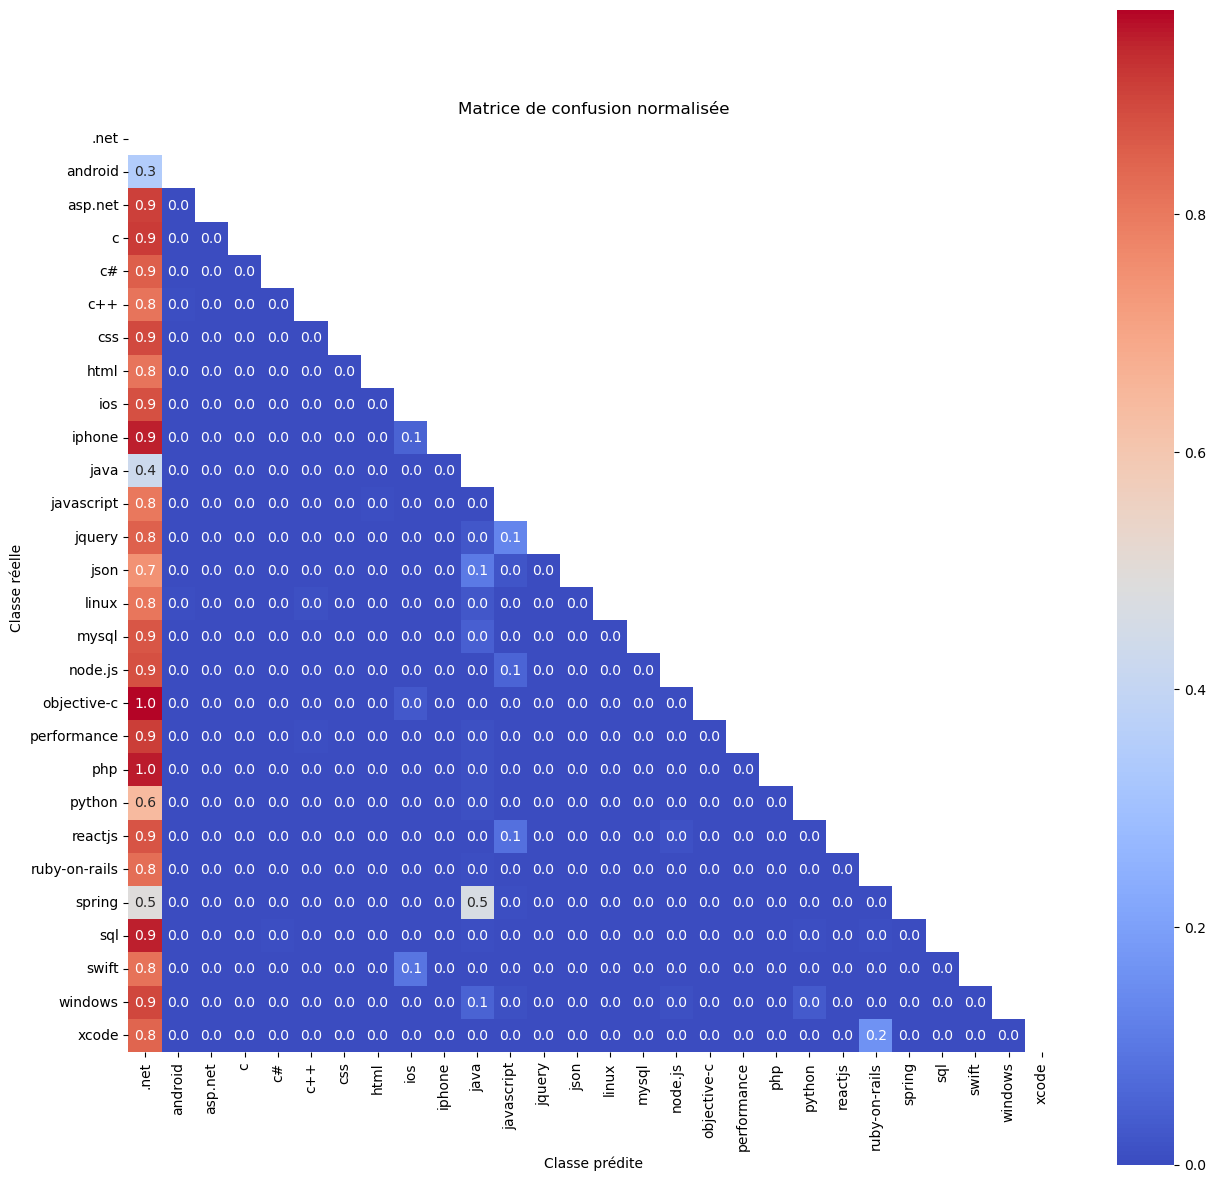

In [134]:
metriques_algo(y_test_in = y_test_lemma_750,
               y_pred_in = y_pred_lemma_randomforest_750)

# Test Set Accuracy = 0.18

In [ ]:
#######################################
#        Algorithme LinearSVC         #
#######################################

In [135]:
y_pred_lemma_LinearSVC_750 = algorithme_ovr(model_in                   = LinearSVC(), 
                                            model_name_in              = 'LinearSVC',
                                            X_train_in                 = X_train_lemma_750, 
                                            y_train_in                 = y_train_lemma_750, 
                                            X_test_in                  = X_test_lemma_750,
                                            feature_extraction_type_in = 'NLTK_lemma_750')

# Durée programme = 22.679 min

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 37199.113 --> stop : 38559.873 ) = 1360.759 sec ou 22.679 min



Test Set Accuracy	= 0.353 

F1 score		= 0.585 , average = micro
F1 score		= 0.4 , average = macro
F1 score		= 0.518 , average = samples
F1 score		= 0.56 , average = weighted


Jaccard score		= 0.413 , average = micro
Jaccard score		= 0.28 , average = macro
Jaccard score		= 0.475 , average = samples
Jaccard score		= 0.423 , average = weighted




C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification metrics =
               precision    recall  f1-score   support

           0       0.37      0.08      0.13       883
           1       0.93      0.77      0.84      1983
           2       0.33      0.11      0.17       397
           3       0.52      0.25      0.33       532
           4       0.76      0.59      0.66      2332
           5       0.78      0.55      0.64      1485
           6       0.47      0.40      0.43       322
           7       0.53      0.25      0.34       753
           8       0.65      0.50      0.56       945
           9       0.12      0.05      0.07       191
          10       0.78      0.60      0.68      3096
          11       0.67      0.54      0.60      2223
          12       0.39      0.16      0.23       470
          13       0.28      0.04      0.08       295
          14       0.34      0.14      0.19       369
          15       0.27      0.13      0.17       284
          16       0.74      0.43      0.54       741
 

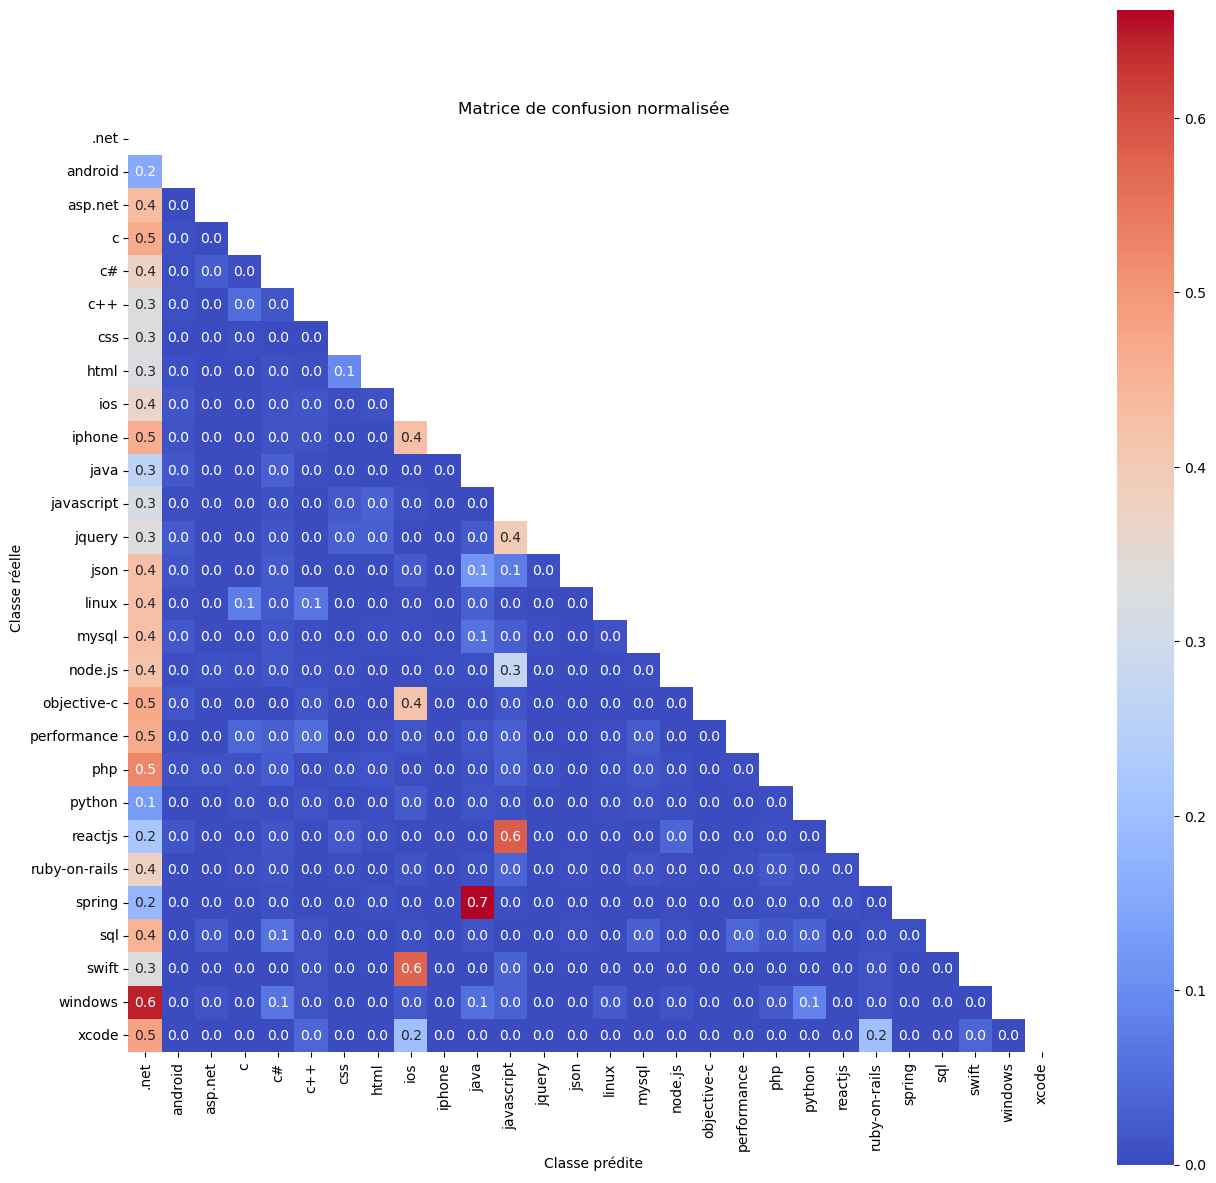

In [136]:
metriques_algo(y_test_in = y_test_lemma_750,
               y_pred_in = y_pred_lemma_LinearSVC_750)

# Test Set Accuracy = 0.353

In [ ]:
# SYNTHESE DECOUPAGE TRAIN / TEST :
#---------------|--------------------|----------------------------------------------------------------------------------|
#               |        X           |              Données train / test                                                |
#---------------|--------------------|----------------------------------------------------------------------------------|
#               | df_lemma           | X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma                         |
#  Données      |--------------------|----------------------------------------------------------------------------------|
#               | df_stemmer         | X_train_stemmer, X_test_stemmer, y_train_stemmer, y_test_stemmer                 |
#---------------|--------------------|----------------------------------------------------------------------------------|
#               | df_pca_lemma_750   | X_train_lemma_750, X_test_lemma_750, y_train_lemma_750, y_test_lemma_750         |
#  Données PCA  |--------------------|----------------------------------------------------------------------------------|
#               | df_pca_stemmer_500 | X_train_stemmer_500, X_test_stemmer_500, y_train_stemmer_500, y_test_stemmer_500 |
#---------------|--------------------|----------------------------------------------------------------------------------|
# Données       | df_norm_lemma      |               /                                                                  |
# standardisées |--------------------|----------------------------------------------------------------------------------|
#               | df_norm_stemmer    |               /                                                                  |
#---------------|--------------------|----------------------------------------------------------------------------------|  
# Données stan- |         /          |               /                                                                  |
# dardisées PCA |--------------------|----------------------------------------------------------------------------------|
#               |         /          |               /                                                                  |
#---------------|--------------------|----------------------------------------------------------------------------------|  

# 5. MACHINE LEARNING SUPERVISE - EXTRACTION DE FEATURES AVEC 3 APPROCHES WORD / SENTENCE EMBEDDING

In [ ]:
# Nous sommes dans une tâche de classification de phrases.

In [137]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
False


In [ ]:
####################################
#       Préparation du texte       #
####################################

In [138]:
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

In [139]:
# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

In [140]:
# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

In [141]:
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

In [142]:
# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [143]:
# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [144]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [145]:
df['sentence_bow']     = df['_Text_sans_html'].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] = df['_Text_sans_html'].apply(lambda x : transform_bow_lem_fct(x))
df['sentence_dl']      = df['_Text_sans_html'].apply(lambda x : transform_dl_fct(x))
df.shape

(49493, 10)

In [146]:
df.columns

Index(['_Tag_1', '_Tag_2', '_Text_sans_html', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final', 'sentence_bow', 'sentence_bow_lem',
       'sentence_dl'],
      dtype='object')

# 5.1. Word2Vec

In [ ]:
######################################################
#       Calcul longueur des documents                #
######################################################

In [147]:
# Longueur documents
len_Text_sans_html = df['_Text_sans_html'].str.len()

# on stocke ce vecteur numérique dans une colonne préfixée par _
df['_len_Text_sans_html'] = len_Text_sans_html

# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)

_len_Text_sans_html
count         49493.000000
mean           3699.969369
std            3123.912106
min             856.000000
25%            2030.000000
50%            2710.000000
75%            4051.000000
max           40807.000000

In [148]:
df.drop(['_len_Text_sans_html'],  axis = 1, inplace = True)

In [ ]:
######################################################
#             Création du modèle Word2Vec            #
######################################################

In [149]:
w2v_size      = 300 # nb colonnes
w2v_window    = 5
w2v_min_count = 1
w2v_epochs    = 100
maxlen        = 200 # valeurs essayées : 200 (adapt to length of sentences). Valeurs à essayer : 24 (exemple), None.

In [150]:
col_texte_brut = 'sentence_bow_lem'
sentences      = df['sentence_bow_lem'].to_list()
sentences      = [gensim.utils.simple_preprocess(text) for text in sentences]

In [151]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model...")
w2v_model = gensim.models.Word2Vec(min_count   = w2v_min_count, 
                                   window      = w2v_window,
                                   vector_size = w2v_size,
                                   seed        = 42,
                                   workers     = 1) # workers = multiprocessing.cpu_count()

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, 
                total_examples = w2v_model.corpus_count, 
                epochs         = w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size : %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model...
Vocabulary size : 344730
Word2Vec trained


In [152]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen  = maxlen, # Optional Int, maximum length of all sequences. If not provided, 
                                              # sequences will be padded to the length of the longest individual sequence.
                            padding = 'post')
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer...
Number of unique words: 344731


In [ ]:
######################################################
#        Création de la matrice d'embedding          #
######################################################

In [153]:
# Création de la matrice d'embedding
print("Create Embedding matrix...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix : %s" % str(embedding_matrix.shape))

Create Embedding matrix...
Word embedding rate :  1.0
Embedding matrix : (344731, 300)


In [ ]:
######################################################
#         Création du modèle d'embedding             #
######################################################

In [154]:
# Création du modèle
input          = Input(shape = (len(x_sentences), maxlen), dtype = 'float64')
word_input     = Input(shape = (maxlen,),dtype = 'float64')  
word_embedding = Embedding(input_dim    = vocab_size,
                           output_dim   = w2v_size,
                           weights      = [embedding_matrix],
                           input_length = maxlen)(word_input)
word_vec       = GlobalAveragePooling1D()(word_embedding)  
embed_model    = Model([word_input], word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          103419300 
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 103,419,300
Trainable params: 103,419,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
######################################################
#              Exécution du modèle                   #
######################################################

In [155]:
embeddings_w2v = embed_model.predict(x_sentences)
embeddings_w2v.shape

1547/1547 [==============================] - 7s 3ms/step


(49493, 300)

In [156]:
print(type(embeddings_w2v))
print(embeddings_w2v.shape)

<class 'numpy.ndarray'>
(49493, 300)


In [ ]:
######################################################
#       Découpage données X, y en train / test       #
######################################################

In [157]:
X_train_w2v, X_test_w2v, \
y_train_w2v, y_test_w2v = decoupage_train_test(X_in = embeddings_w2v,
                                               y_in = y) # y commun 

X_train shape	= (32170, 300)
X_test shape	= (17323, 300)
y_train shape	= (32170, 28)
y_test shape	= (17323, 28)


In [ ]:
#######################################
#       Algorithme RandomForest       #
#######################################

In [158]:
y_pred_w2v_randomforest = algorithme_ovr(model_in                   = RandomForestClassifier(),
                                         model_name_in              = 'RandomForestClassifier',
                                         X_train_in                 = X_train_w2v, 
                                         y_train_in                 = y_train_w2v, 
                                         X_test_in                  = X_test_w2v,
                                         feature_extraction_type_in = 'w2v')

# maxlen = 200, Durée programme = 18.221 min

Durée programme (start : 13926.340 --> stop : 15019.617 ) = 1093.278 sec ou 18.221 min



col_texte_brut = sentence_bow_lem 

Test Set Accuracy	= 0.32 

F1 score		= 0.534 , average = micro
F1 score		= 0.287 , average = macro
F1 score		= 0.438 , average = samples
F1 score		= 0.488 , average = weighted


Jaccard score		= 0.364 , average = micro
Jaccard score		= 0.199 , average = macro
Jaccard score		= 0.408 , average = samples
Jaccard score		= 0.361 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.50      0.03      0.05       883
           1       0.98      0.64      0.78      1983
           2       0.88      0.02      0.03       397
           3       0.79      0.07      0.13       532
           4       0.89      0.46      0.61      2332
           5       0.87      0.53      0.66      1485
           6       0.66      0.16      0.26       322
           7       0.66      0.28      0.39       753
           8       0.80      0.38      0.51       945
           9       0.00      0.00      0.00     

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


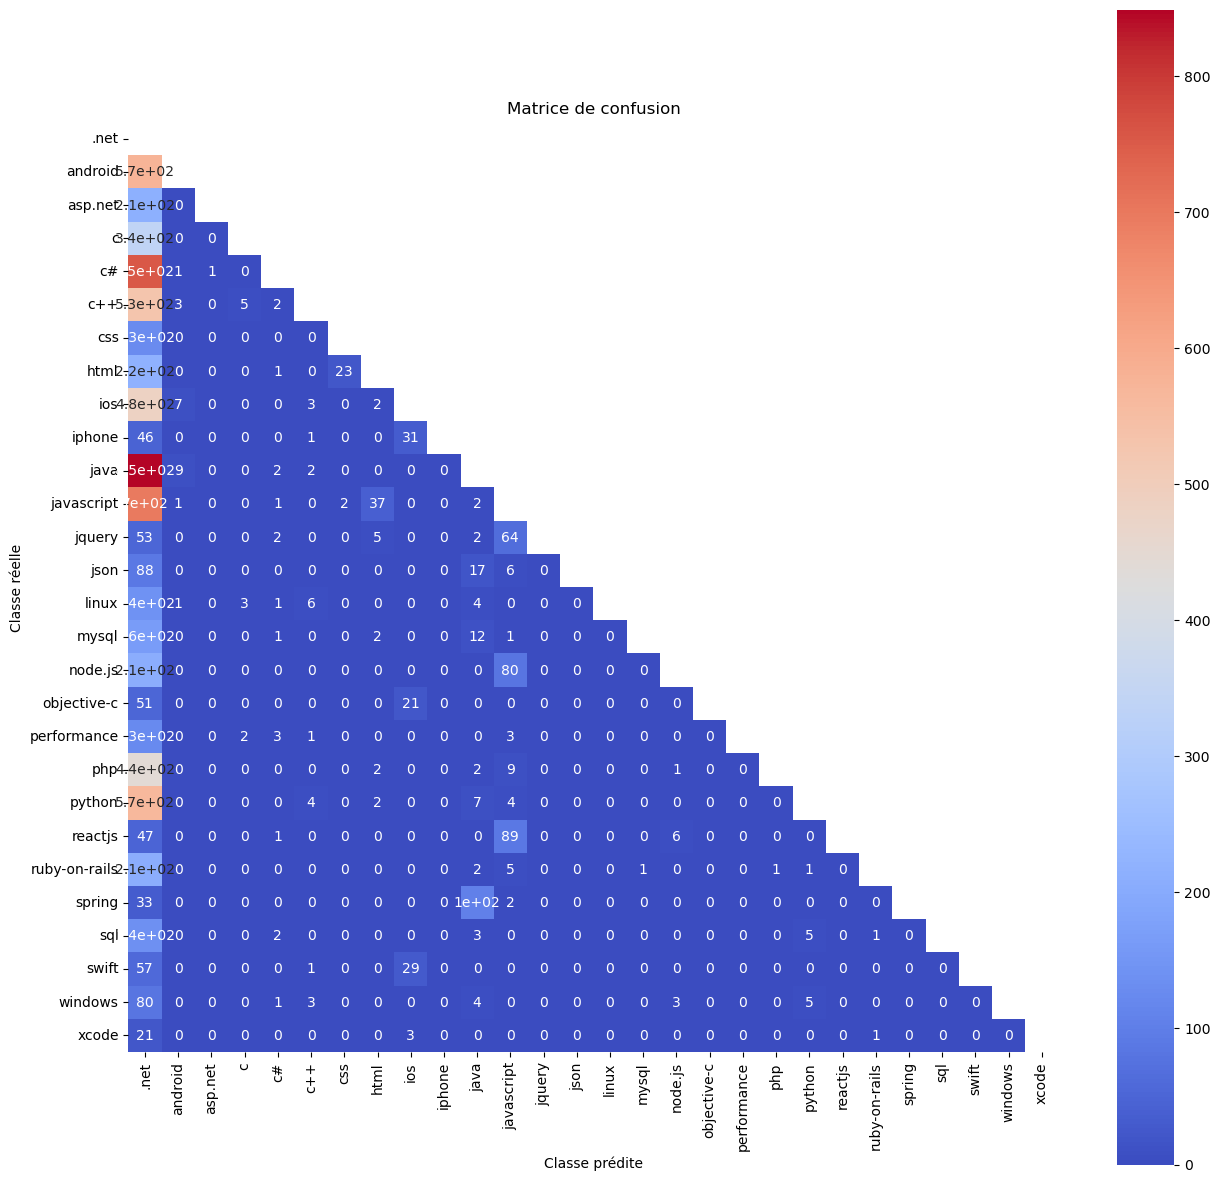

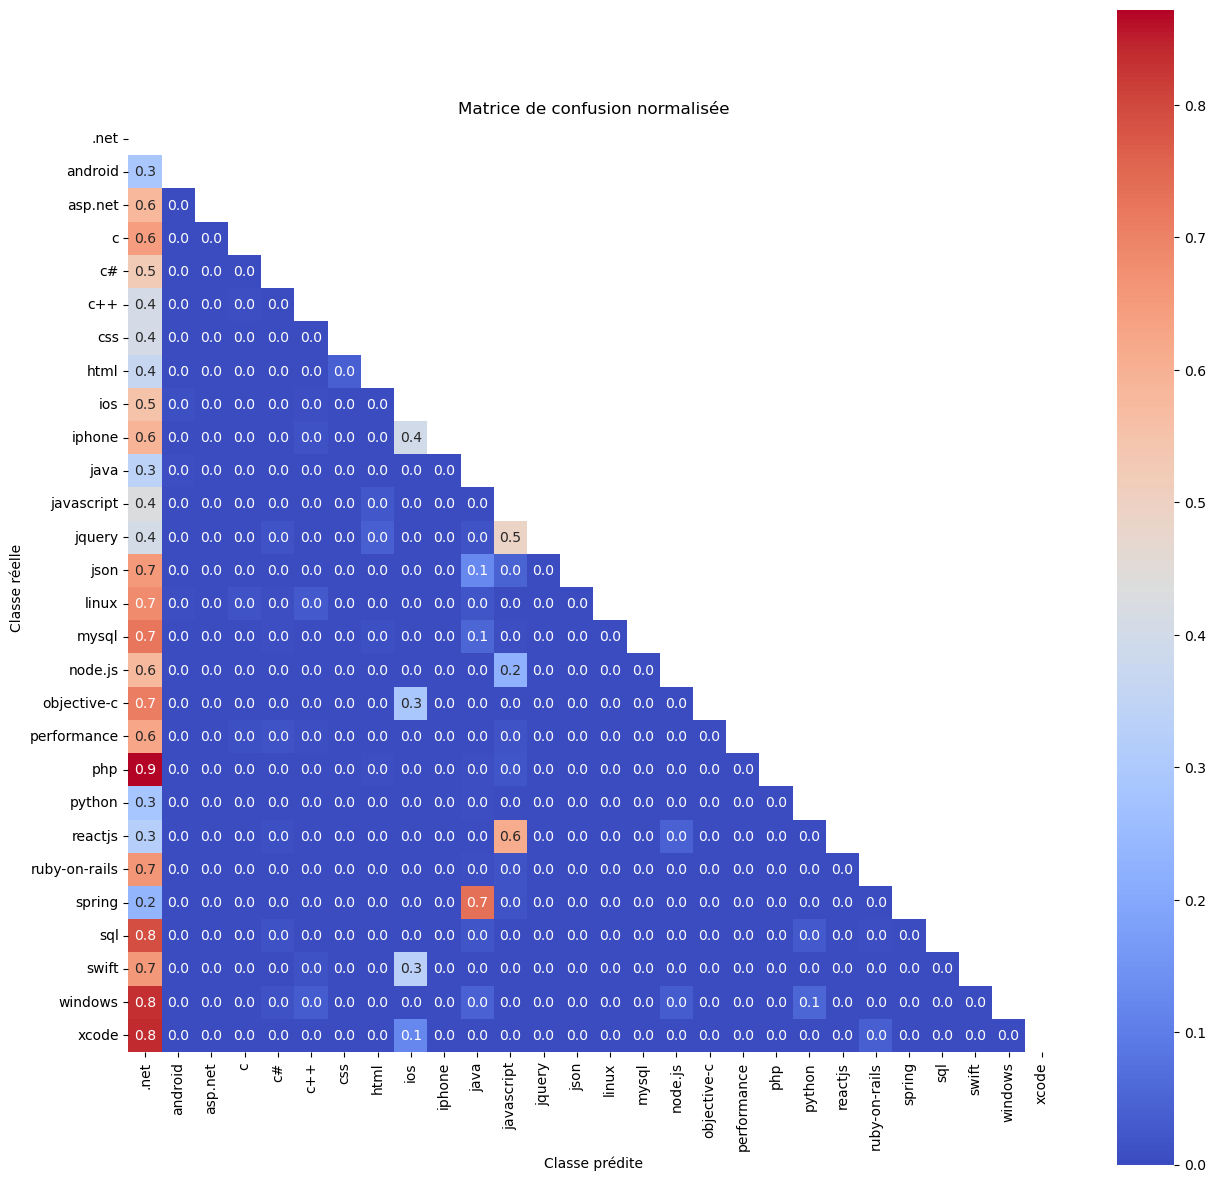

In [159]:
print('col_texte_brut =', col_texte_brut, '\n')

metriques_algo(y_test_in             = y_test_w2v,
               y_pred_in             = y_pred_w2v_randomforest,
               afficher_all_matrices = True)

# maxlen = 200, Test Set Accuracy = 0.32

In [ ]:
#######################################
#        Algorithme LinearSVC         #
#######################################

In [160]:
y_pred_w2v_LinearSVC = algorithme_ovr(model_in                   = LinearSVC(),
                                      model_name_in              = 'LinearSVC',
                                      X_train_in                 = X_train_w2v, 
                                      y_train_in                 = y_train_w2v, 
                                      X_test_in                  = X_test_w2v,
                                      feature_extraction_type_in = 'w2v')

# maxlen = 200, Durée programme = 3.803 min

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 15306.126 --> stop : 15534.284 ) = 228.158 sec ou 3.803 min



col_texte_brut = sentence_bow_lem 

Test Set Accuracy	= 0.449 

F1 score		= 0.674 , average = micro
F1 score		= 0.495 , average = macro
F1 score		= 0.624 , average = samples
F1 score		= 0.647 , average = weighted


Jaccard score		= 0.508 , average = micro
Jaccard score		= 0.367 , average = macro
Jaccard score		= 0.579 , average = samples
Jaccard score		= 0.513 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.52      0.14      0.22       883
           1       0.95      0.81      0.87      1983
           2       0.64      0.16      0.25       397
           3       0.65      0.37      0.47       532
           4       0.83      0.73      0.78      2332
           5       0.85      0.68      0.76      1485
           6       0.60      0.40      0.48       322
           7       0.61      0.36      0.45       753
           8       0.76      0.66      0.70       945
           9       0.40      0.04      0.08    

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


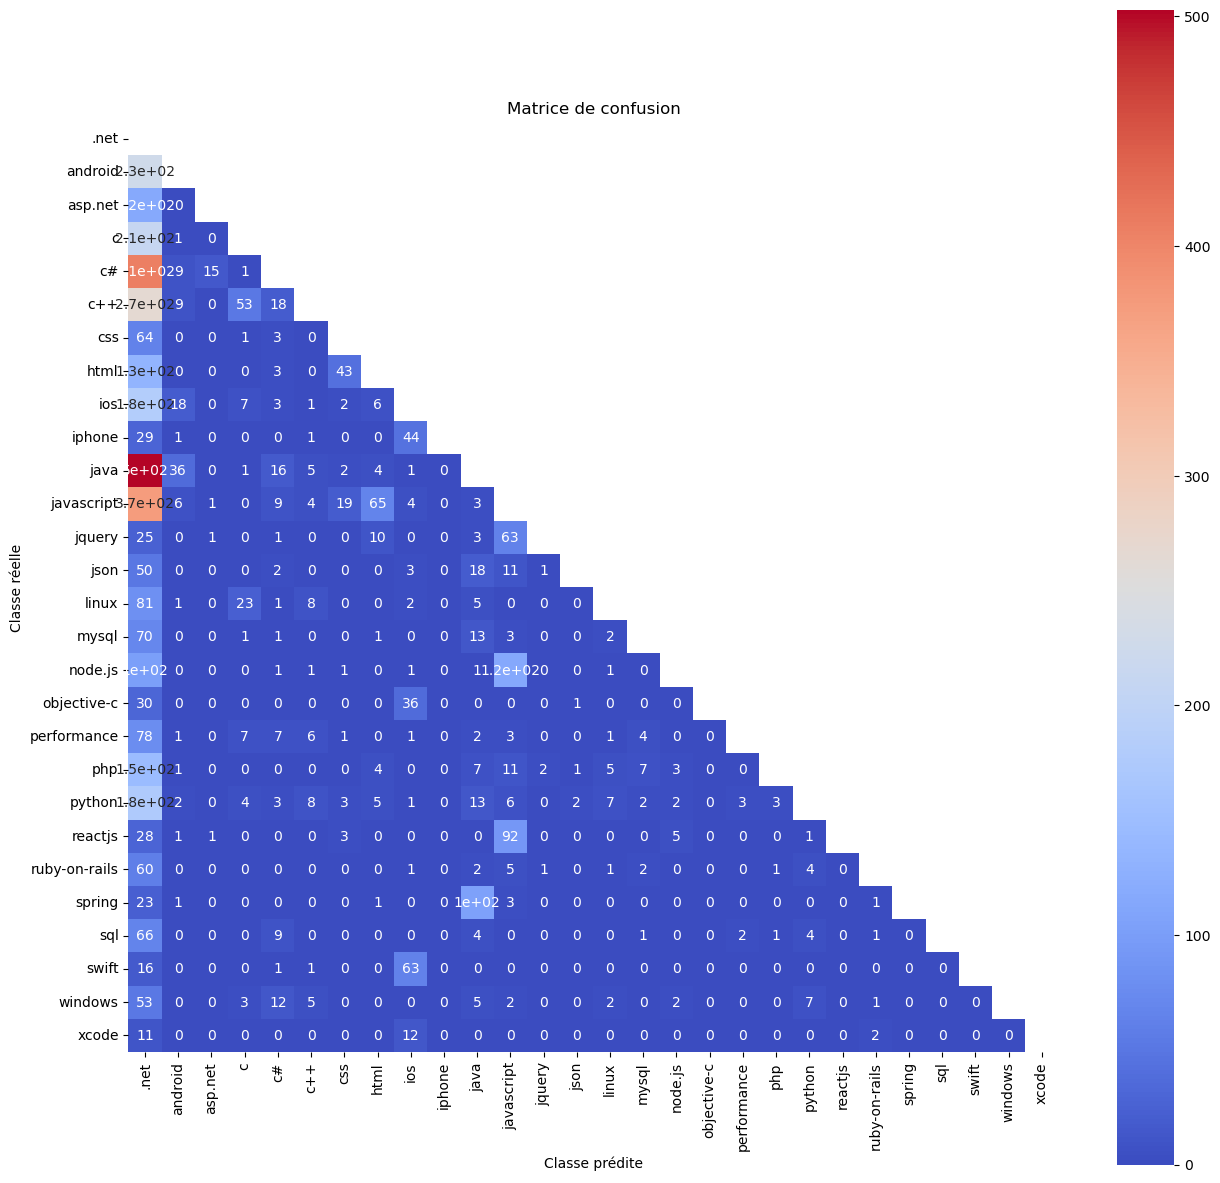

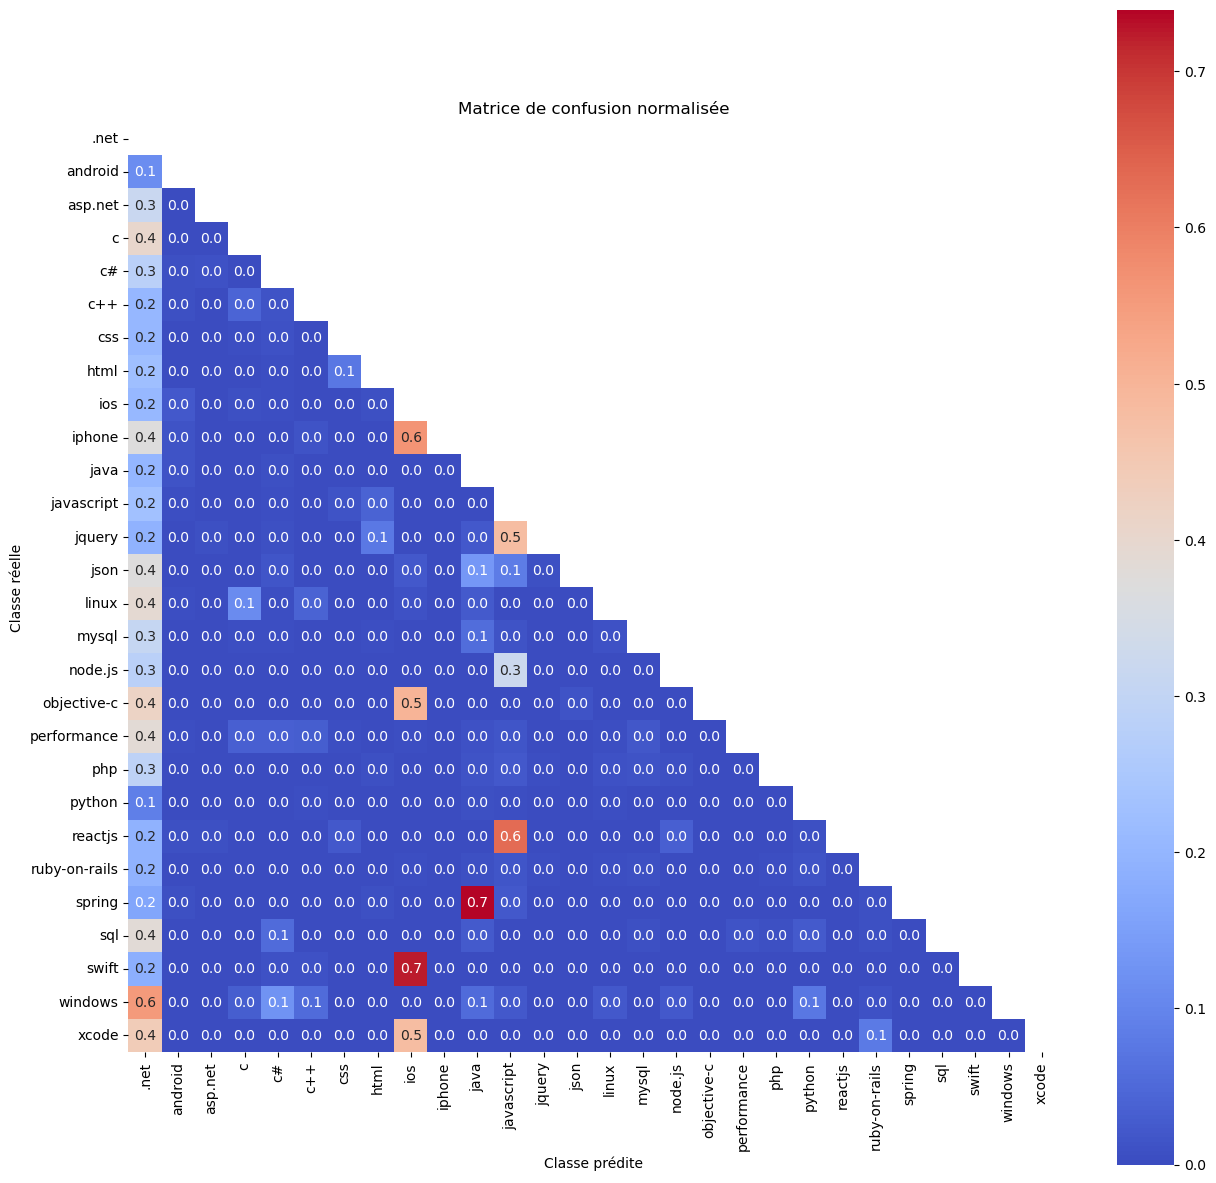

In [161]:
print('col_texte_brut =', col_texte_brut, '\n')

metriques_algo(y_test_in             = y_test_w2v,
               y_pred_in             = y_pred_w2v_LinearSVC,
               afficher_all_matrices = True)

# maxlen = 200, Test Set Accuracy = 0.449

# 5.2. USE (Universal Sentence Encoder)

In [ ]:
# https://www.geeksforgeeks.org/word-embedding-using-universal-sentence-encoder-in-python/
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=fr
# https://tfhub.dev/google/collections/universal-sentence-encoder/1

In [ ]:
#########################################################
#                  Fonctions USE                        #
#########################################################

In [162]:
# Fonction de création des features
def feature_USE_fct(sentences, b_size):
    
    batch_size = b_size
    time_1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step * batch_size
              
        feat = embed(sentences[idx:idx + batch_size])

        if (step == 0):
            features = feat
        else :
            features = np.concatenate((features, feat))

    time_2 = np.round(time.time() - time_1, 0)
    return features

In [ ]:
#########################################################
# Transformation des phrases brutes (sans balises html) #
#        avec USE (encodeur de phrases universel)       #
#      pour une tâche de classification de phrases.     #
#########################################################

In [163]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # USE (Universal Sentence Encoder)

In [175]:
# texte brut 
col_texte_brut = 'sentence_dl' # Valeurs essayées : 'sentence_dl', '_Text_sans_html'
sentences = df[col_texte_brut].to_list()

In [176]:
batch_size   = 1 # valeurs essayées : 1. Valeurs à essayer : 10 (exemple), 50, 100, 200
features_USE = feature_USE_fct(sentences, batch_size)

In [177]:
print(type(features_USE))
print(features_USE.shape)

<class 'numpy.ndarray'>
(49493, 512)


In [ ]:
######################################################
#       Découpage données X, y en train / test       #
######################################################

In [178]:
X_train_USE, X_test_USE, \
y_train_USE, y_test_USE = decoupage_train_test(X_in = features_USE,
                                               y_in = y) # y commun 

X_train shape	= (32170, 512)
X_test shape	= (17323, 512)
y_train shape	= (32170, 28)
y_test shape	= (17323, 28)


In [ ]:
#######################################
#       Algorithme RandomForest       #
#######################################

In [179]:
y_pred_USE_randomforest = algorithme_ovr(model_in                   = RandomForestClassifier(),
                                         model_name_in              = 'RandomForestClassifier',                 
                                         X_train_in                 = X_train_USE, 
                                         y_train_in                 = y_train_USE, 
                                         X_test_in                  = X_test_USE,
                                         feature_extraction_type_in = 'USE')

# col_texte_brut = 'sentence_dl',     batch_size = 1, Durée programme = 21.864 min
# col_texte_brut = '_Text_sans_html', batch_size = 1, Durée programme = 27.291 min  

Durée programme (start : 20768.698 --> stop : 22080.550 ) = 1311.852 sec ou 21.864 min



col_texte_brut = sentence_dl 

Test Set Accuracy	= 0.423 

F1 score		= 0.646 , average = micro
F1 score		= 0.377 , average = macro
F1 score		= 0.585 , average = samples
F1 score		= 0.593 , average = weighted


Jaccard score		= 0.477 , average = micro
Jaccard score		= 0.278 , average = macro
Jaccard score		= 0.544 , average = samples
Jaccard score		= 0.473 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.62      0.04      0.07       883
           1       0.98      0.78      0.87      1983
           2       0.69      0.08      0.14       397
           3       0.79      0.16      0.26       532
           4       0.84      0.75      0.80      2332
           5       0.89      0.59      0.71      1485
           6       0.76      0.17      0.28       322
           7       0.70      0.29      0.41       753
           8       0.77      0.59      0.67       945
           9       0.00      0.00      0.00       19

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


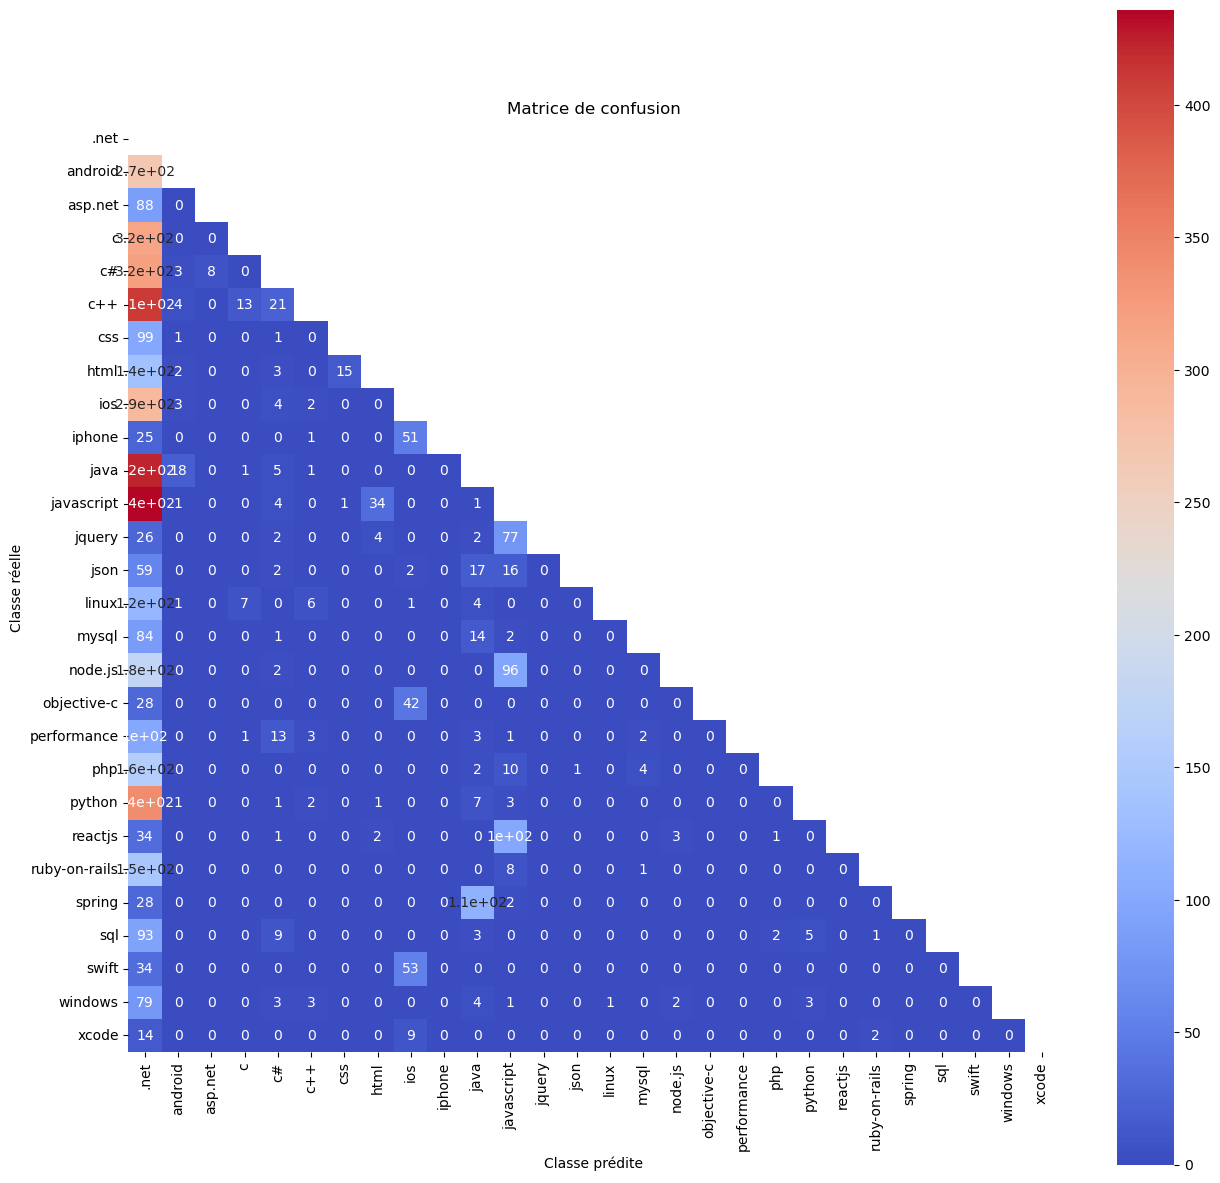

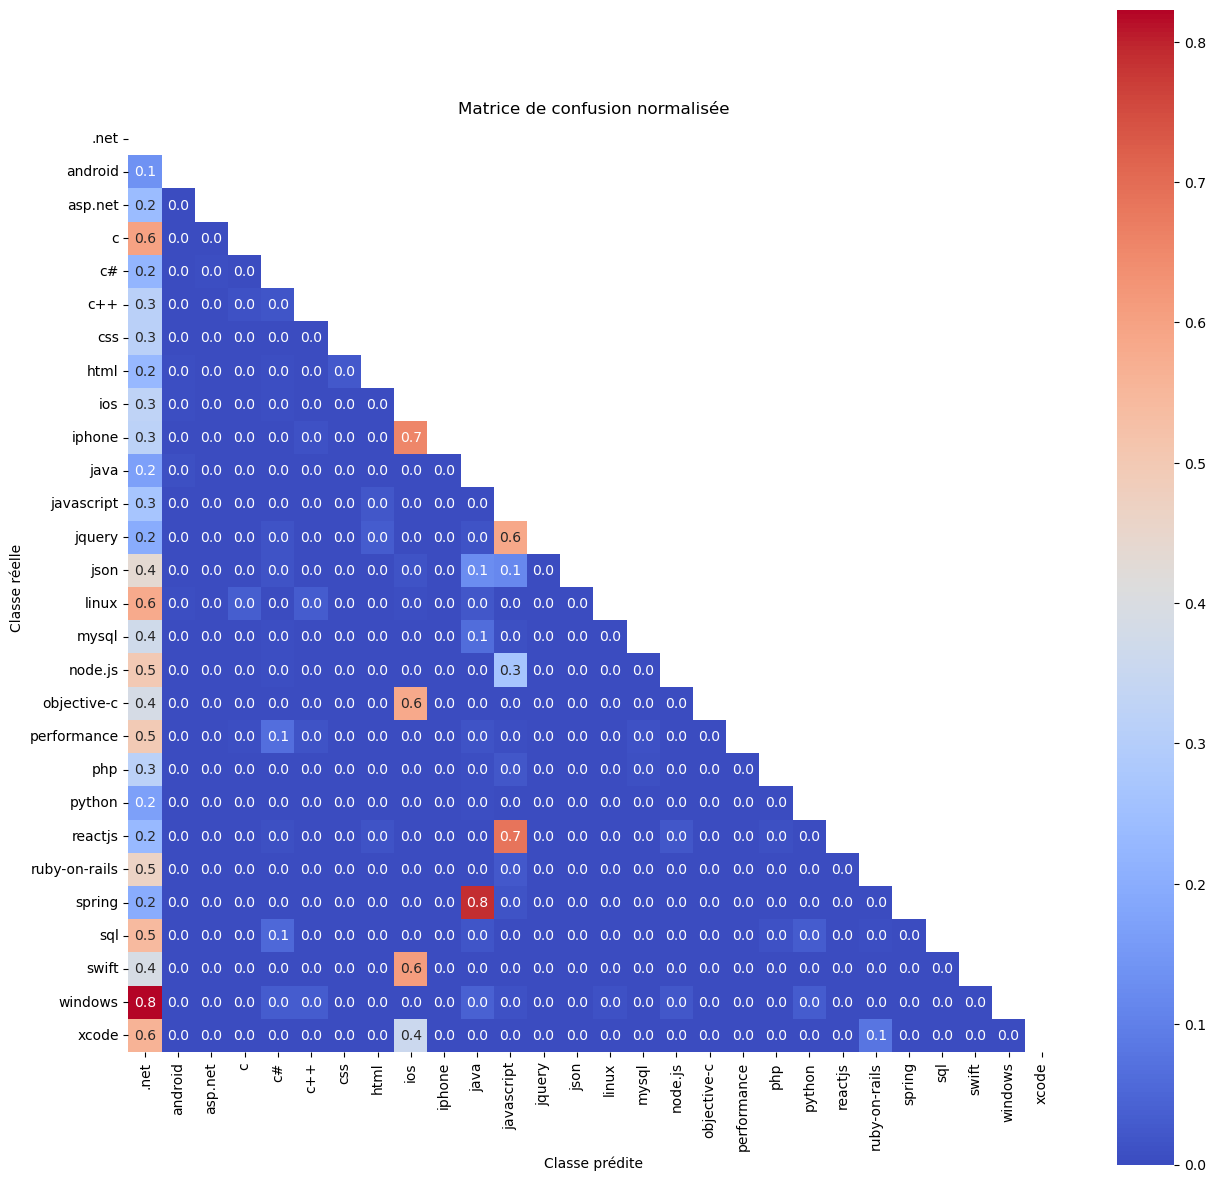

In [180]:
print('col_texte_brut =', col_texte_brut, '\n')

metriques_algo(y_test_in             = y_test_USE,
               y_pred_in             = y_pred_USE_randomforest,
               afficher_all_matrices = True)

# col_texte_brut = 'sentence_dl',     batch_size = 1, Test Set Accuracy = 0.423
# col_texte_brut = '_Text_sans_html', batch_size = 1, Test Set Accuracy = 0.403

In [ ]:
#######################################
#        Algorithme LinearSVC         #
#######################################

In [181]:
y_pred_USE_LinearSVC = algorithme_ovr(model_in                   = LinearSVC(),
                                      model_name_in              = 'LinearSVC',
                                      X_train_in                 = X_train_USE, 
                                      y_train_in                 = y_train_USE, 
                                      X_test_in                  = X_test_USE,
                                      feature_extraction_type_in = 'USE')

# col_texte_brut = 'sentence_dl',     batch_size = 1, Durée programme = 0.349 min
# col_texte_brut = '_Text_sans_html', batch_size = 1, Durée programme = 0.331 min 

Durée programme (start : 25470.008 --> stop : 25490.924 ) = 20.916 sec ou 0.349 min



col_texte_brut = sentence_dl 

Test Set Accuracy	= 0.523 

F1 score		= 0.737 , average = micro
F1 score		= 0.565 , average = macro
F1 score		= 0.715 , average = samples
F1 score		= 0.712 , average = weighted


Jaccard score		= 0.584 , average = micro
Jaccard score		= 0.435 , average = macro
Jaccard score		= 0.666 , average = samples
Jaccard score		= 0.588 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.60      0.19      0.29       883
           1       0.94      0.88      0.91      1983
           2       0.63      0.24      0.35       397
           3       0.73      0.50      0.59       532
           4       0.83      0.83      0.83      2332
           5       0.85      0.75      0.80      1485
           6       0.71      0.47      0.57       322
           7       0.63      0.44      0.52       753
           8       0.76      0.78      0.77       945
           9       0.40      0.01      0.02       19

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


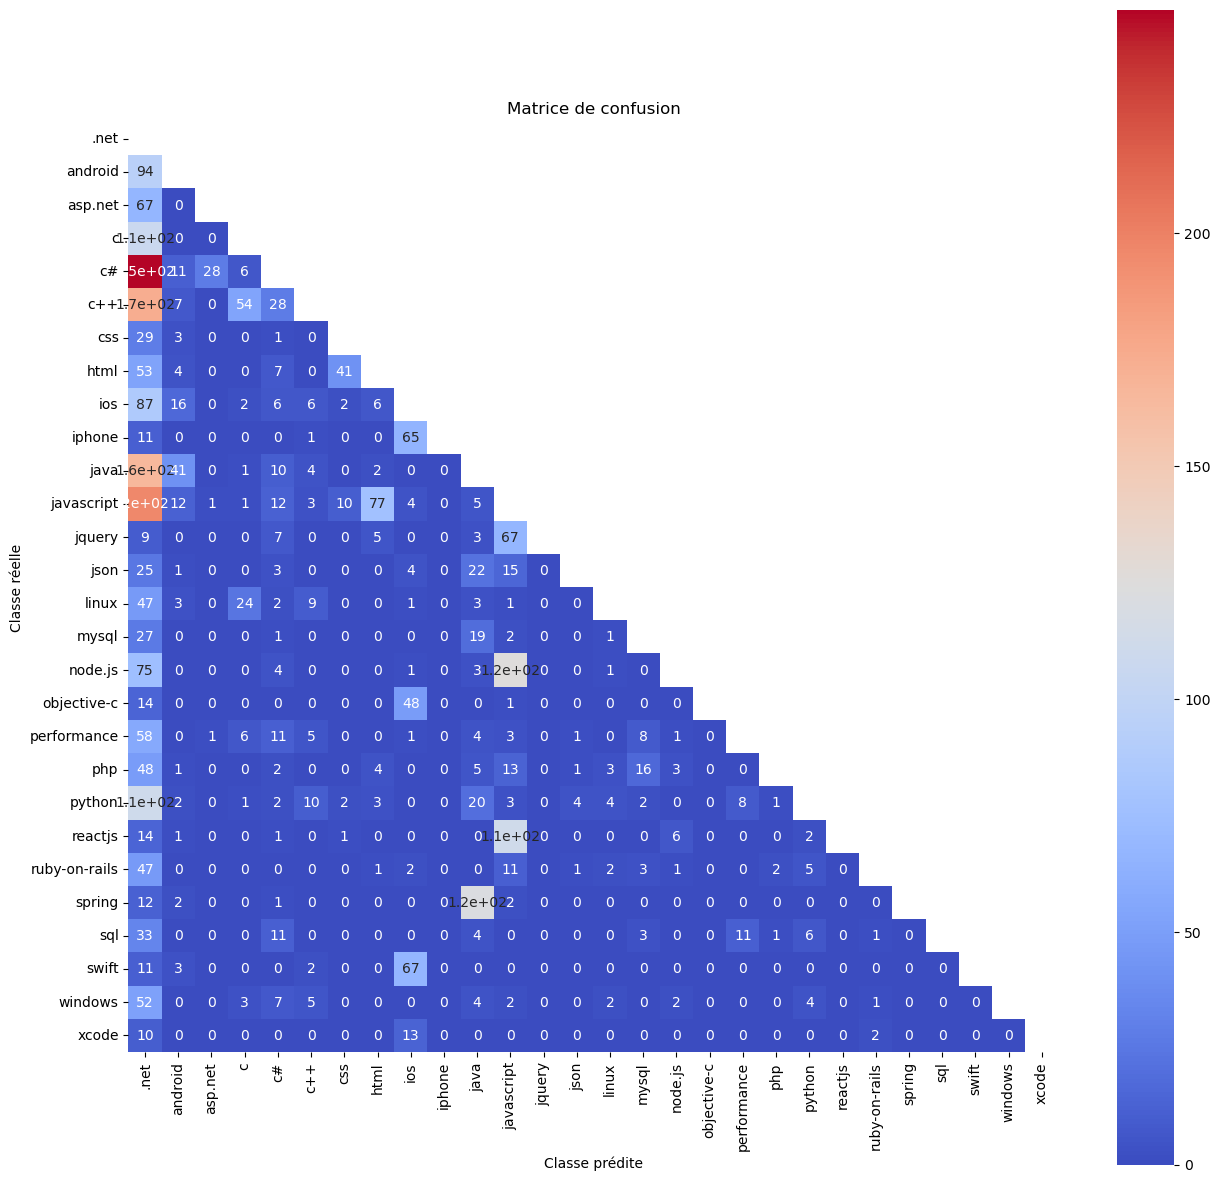

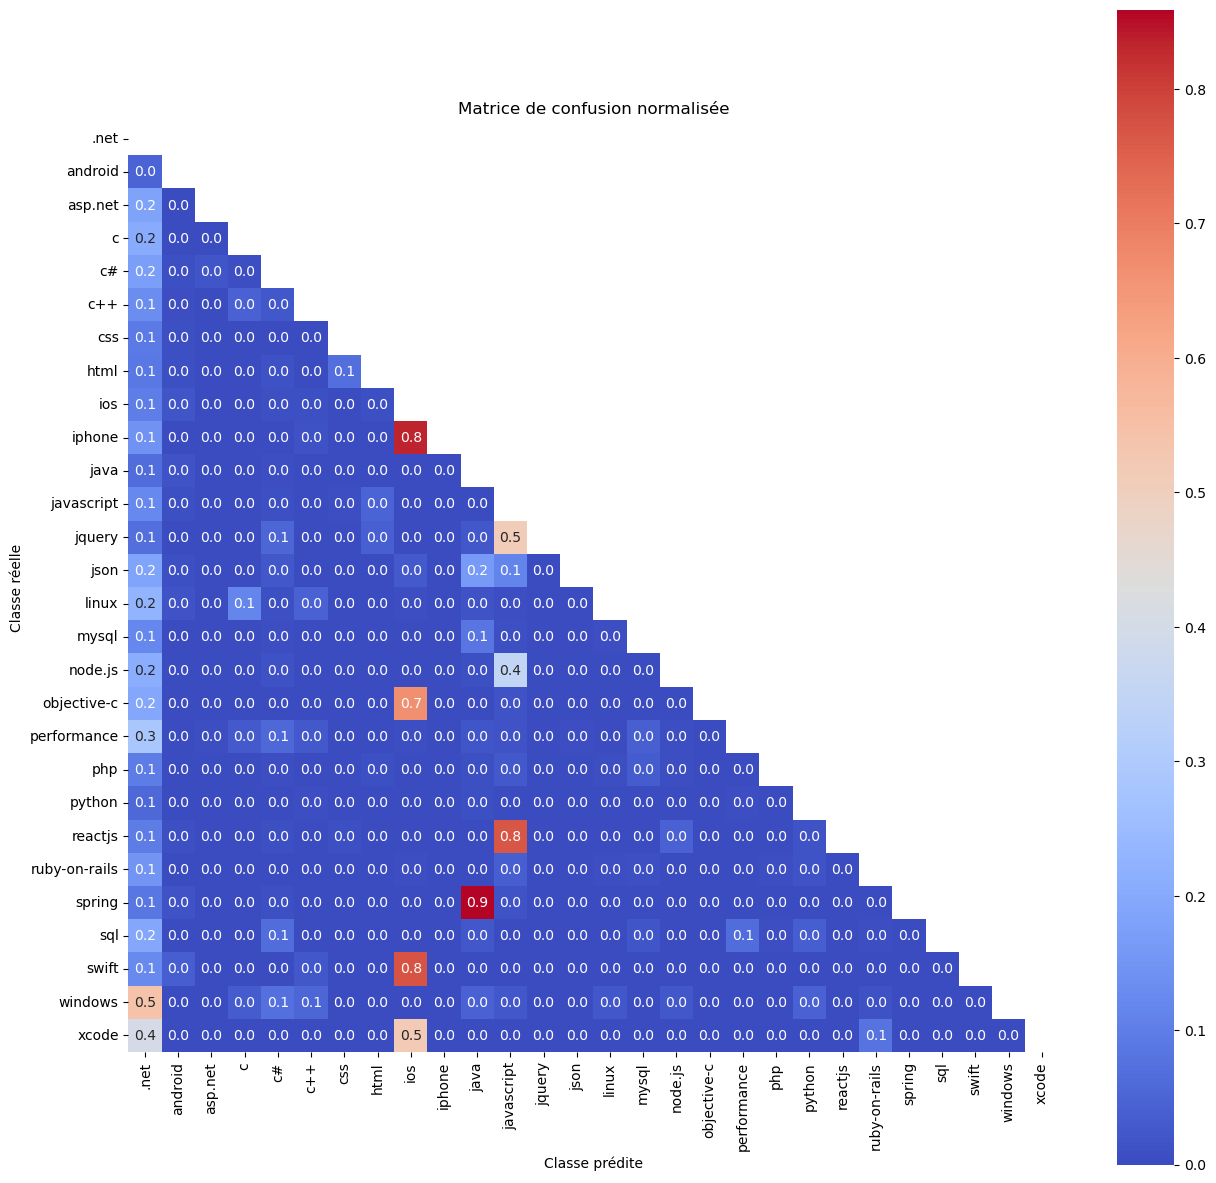

In [182]:
print('col_texte_brut =', col_texte_brut, '\n')

metriques_algo(y_test_in             = y_test_USE,
               y_pred_in             = y_pred_USE_LinearSVC,
               afficher_all_matrices = True)

# col_texte_brut = 'sentence_dl',     batch_size = 1, Test Set Accuracy = 0.523
# col_texte_brut = '_Text_sans_html', batch_size = 1, Test Set Accuracy = 0.517

# 5.3. BERT (Bidirectional Encoder Representations from Transformers) HuggingFace

In [ ]:
# Exemple de Word Embedding BERT via Huggingface :
# https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertModel

# Exemple de Word Embedding BERT via le hub Tensorflow : 
# https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

# https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32

In [ ]:
#########################################################
#                Fonctions BERT                         #
#########################################################

In [183]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids      = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot   = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens    = True,
                                              max_length            = max_length,
                                              padding               = 'max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids = True,
                                              truncation            = True,
                                              return_tensors        = "tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids      = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [184]:
# Fonction de création des features : stockage dans un fichier des last_hidden_states.
def feature_BERT_fct_file(model_in, bert_tokenizer_in, sentences_in, max_length_in, b_size_in, 
                          index_min_in, index_max_in, mode_in = 'HF'):
    
    batch_size      = b_size_in
    batch_size_pred = b_size_in
#    bert_tokenizer  = AutoTokenizer.from_pretrained(model_type)
    time_1          = time.time()
    step_max        = len(sentences_in)//batch_size 

    
    # Maj indice max si plus grand que le step max.
    if (index_max_in > step_max):
        index_max_in = step_max
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in)
    
    for index in np.arange(index_min_in, index_max_in):
#    for step in range(len(sentences)//batch_size):
        
        print('\n')
        print('index =', index, '/', index_max_in, '(step_max =', step_max, ')')
                
        idx = index * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                               bert_tokenizer_in, 
                                                                               max_length_in)
        
        if (mode_in == 'HF'):    # Bert HuggingFace
            outputs            = model_in.predict([input_ids, attention_mask, token_type_ids], 
                                                  batch_size = batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        elif (mode_in == 'TFhub'): # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask"     : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs            = model_in(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

             
        if (index == index_min_in):
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
    
    
    # Stockage du ndarrray dans un fichier
    # https://www.delftstack.com/fr/howto/numpy/python-save-and-load-numpy-array/
    print('last_hidden_states_tot.shape =', last_hidden_states_tot.shape)
    
    nom_fichier = 'BERT_last_hidden_states_' +  str(index_min_in) + '_' + str(index_max_in - 1) + '.npy'
    np.save(C_DATASET_CLEANED + nom_fichier, last_hidden_states_tot)
    print('\nsauvegarde ndarray dans fichier', nom_fichier)

    
    time_2 = np.round(time.time() - time_1, 0)
    print('\ntemps traitement :', time_2)

In [185]:
# Fonction de création des features : concaténation.
def feature_BERT_fct_concatenate(sentences_in, b_size_in):
    
    batch_size = b_size_in
    time_1     = time.time()

    
    # https://www.delftstack.com/fr/howto/python/how-to-find-files-with-certain-extension-only-in-python/
    liste_npy = [_ for _ in os.listdir(C_DATASET_CLEANED) if _.endswith('.npy')]
    print('liste_npy =\n', liste_npy, '\n')



    for file in liste_npy: 
        if (file == liste_npy[0]):
            print('fichier', file)
            last_hidden_states_tot = np.load(C_DATASET_CLEANED + file)
        else:
            print('fichier', file)        
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, np.load(C_DATASET_CLEANED + file)))
    
    features_BERT = np.array(last_hidden_states_tot).mean(axis = 1)
    
    time_2 = np.round(time.time() - time_1, 0)
    print('temps traitement :', time_2)
     
    return features_BERT, last_hidden_states_tot

In [ ]:
#################################
#       Environnement GPU       #
#################################

In [186]:
os.environ["TF_KERAS"] = '1'

In [187]:
# https://stackoverflow.com/questions/62035811/in-pytorch-how-to-convert-the-cuda-related-codes-into-cpu-version
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available :", len(tf.config.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)

import tensorflow as tf

print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available : 0
False


In [188]:
# To check if TensorFlow is capable of using GPU, run the following code.
#import tensorflow as tf
tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

''

In [189]:
# https://stackoverflow.com/questions/50560395/how-to-install-cuda-in-google-colab-gpus/60338745#60338745
# Setting up the device for GPU usage
from torch import cuda
if cuda.is_available():
    device = 'cuda' 
else:
    device = 'cpu'
print('device =', device)

device = cpu


In [ ]:
######################################################################################
#              Transformation des phrases brutes (sans balises html)                 #
# avec BERT (Bidirectional Encoder Representations from Transformers) HuggingFace    #
#                  pour une tâche de classification de phrases.                      #
######################################################################################

In [190]:
max_length     = 64  # valeurs essayées : 64. Valeurs à essayer : 512 (default value).
batch_size     = 1   # valeurs essayées : 1. Valeurs à essayer : 10 (exemple).

model_type     = 'bert-base-uncased'  # BERT
model          = TFAutoModel.from_pretrained(model_type)
bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job

Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StopGradient in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SquaredDifference in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:loca

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/rep

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StopGradient in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SquaredDifference in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Rsqrt in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerCon

Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Rsqrt in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/re

Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVa

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/

Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp i

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Erf in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhos

Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Res

Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/repli

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchMatMulV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Softmax in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchMatMulV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/

Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchMatMulV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in d

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StopGradient in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SquaredDifference in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Rsqrt in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/

Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:lo

Executing op Rsqrt in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/re

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/ta

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fil

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:loca

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /j

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:loca

Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:loca

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhos

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:loca

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:loca

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /j

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [191]:
# texte brut 
col_texte_brut = 'sentence_dl' # Valeurs essayées : 'sentence_dl'. Valeurs à essayer : _Text_sans_html'.
sentences      = df[col_texte_brut].to_list()

In [ ]:
#############################################################################
# Création des features : stockage dans un fichier des last_hidden_states.  #
#############################################################################

In [ ]:
# REMARQUE : SUPPRESSION DES TRACES POUR ALLEGER LE POIDS DU NOTEBOOK.
# RESUME DANS CHAQUE INTERVALLE DE LIGNES.

In [192]:
###################################################
# index 0 --> 4.999 : 5.000 lignes                #
################################################### 
for ind_min in [0, 1_000, 2_000, 3_000, 4_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 0 , index_max_in = 1000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_0_999.npy
#    > temps traitement : 2514.0
# 
# index_min_in = 1000 , index_max_in = 2000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_1000_1999.npy
#    > temps traitement : 2622.0
# 
# index_min_in = 2000 , index_max_in = 3000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_2000_2999.npy
#    > temps traitement : 2638.0
# 
# index_min_in = 3000 , index_max_in = 4000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_3000_3999.npy
#    > temps traitement : 1995.0
# 
# index_min_in = 4000 , index_max_in = 5000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_4000_4999.npy
#    > temps traitement : 2203.0



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 0 , index_max_in = 1000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_0_999.npy
#    > temps traitement : 1959.0
# 
# index_min_in = 1000 , index_max_in = 2000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_1000_1999.npy
#    > temps traitement : 1691.0
# 
# index_min_in = 2000 , index_max_in = 3000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_2000_2999.npy
#    > temps traitement : 1704.0
# 
# index_min_in = 3000 , index_max_in = 4000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_3000_3999.npy
#    > temps traitement : 1690.0
# 
# index_min_in = 4000 , index_max_in = 5000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_4000_4999.npy
#    > temps traitement : 1718.0

In [193]:
###################################################
# index 5.000 --> 9.999 : 5.000 lignes            #
###################################################
for ind_min in [5_000, 6_000, 7_000, 8_000, 9_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 5000 , index_max_in = 6000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_5000_5999.npy
#    > temps traitement : 4525.0
# 
# index_min_in = 6000 , index_max_in = 7000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_6000_6999.npy
#    > temps traitement : 6099.0
# 
# index_min_in = 7000 , index_max_in = 8000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_7000_7999.npy
#    > temps traitement : 3403.0
# 
# index_min_in = 8000 , index_max_in = 9000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_8000_8999.npy
#    > temps traitement : 3577.0
# 
# index_min_in = 9000 , index_max_in = 10000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_9000_9999.npy
#    > temps traitement : 3846.0



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 5000 , index_max_in = 6000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_5000_5999.npy
#    > temps traitement : 2964.0
# 
# index_min_in = 6000 , index_max_in = 7000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_6000_6999.npy
#    > temps traitement : 3317.0
# 
# index_min_in = 7000 , index_max_in = 8000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_7000_7999.npy
#    > temps traitement : 3675.0
# 
# index_min_in = 8000 , index_max_in = 9000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_8000_8999.npy
#    > temps traitement : 3232.0
# 
# index_min_in = 9000 , index_max_in = 10000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_9000_9999.npy
#    > temps traitement : 3621.0

In [194]:
###################################################
# index 10.000 --> 14.999 : 5.000 lignes          #
###################################################
for ind_min in [10_000, 11_000, 12_000, 13_000, 14_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 10000 , index_max_in = 11000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_10000_10999.npy
#    > temps traitement : 5173.0
# 
# index_min_in = 11000 , index_max_in = 12000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_11000_11999.npy
#    > temps traitement : 6579.0
# 
# index_min_in = 12000 , index_max_in = 13000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_12000_12999.npy
#    > temps traitement : 27958.0
# 
# index_min_in = 13000 , index_max_in = 14000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_13000_13999.npy
#    > temps traitement : 6708.0
# 
# index_min_in = 14000 , index_max_in = 15000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_14000_14999.npy
#    > temps traitement : 10043.0



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 10000 , index_max_in = 11000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_10000_10999.npy
#    > temps traitement : 3891.0
# 
# index_min_in = 11000 , index_max_in = 12000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_11000_11999.npy
#    > temps traitement : 7938.0
# 
# index_min_in = 12000 , index_max_in = 13000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_12000_12999.npy
#    > temps traitement : 3496.0
# 
# index_min_in = 13000 , index_max_in = 14000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_13000_13999.npy
#    > temps traitement : 4335.0
# 
# index_min_in = 14000 , index_max_in = 15000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_14000_14999.npy
#    > temps traitement : 3538.0

In [195]:
###################################################
# index 15.000 --> 19.999 : 5.000 lignes          #
###################################################
for ind_min in [15_000, 16_000, 17_000, 18_000, 19_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 15000 , index_max_in = 16000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_15000_15999.npy
#    > temps traitement : 4156.0
# 
# index_min_in = 16000 , index_max_in = 17000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_16000_16999.npy
#    > temps traitement : 5111.0
# 
# index_min_in = 17000 , index_max_in = 18000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_17000_17999.npy
#    > temps traitement : 24911.0
# 
# index_min_in = 18000 , index_max_in = 19000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_18000_18999.npy
#    > temps traitement : 6577.0
# 
# index_min_in = 19000 , index_max_in = 20000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_19000_19999.npy
#    > temps traitement : 7334.0



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 15000 , index_max_in = 16000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_15000_15999.npy
#    > temps traitement : 4303.0
# 
# index_min_in = 16000 , index_max_in = 17000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_16000_16999.npy
#    > temps traitement : 5963.0
# 
# index_min_in = 17000 , index_max_in = 18000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_17000_17999.npy
#    > temps traitement : 6878.0
# 
# index_min_in = 18000 , index_max_in = 19000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_18000_18999.npy
#    > temps traitement : 4290.0
# 
# index_min_in = 19000 , index_max_in = 20000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_19000_19999.npy
#    >temps traitement : 5908.0

In [196]:
###################################################
# index 20.000 --> 24.999 : 5.000 lignes          #
###################################################
for ind_min in [20_000, 21_000, 22_000, 23_000, 24_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 20000 , index_max_in = 21000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_20000_20999.npy
#    > temps traitement : 1139.0
# 
# index_min_in = 21000 , index_max_in = 22000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_21000_21999.npy
#    > temps traitement : 1881.0
# 
# index_min_in = 22000 , index_max_in = 23000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_22000_22999.npy
#    > temps traitement : 3133.0
# 
# index_min_in = 23000 , index_max_in = 24000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_23000_23999.npy
#    > temps traitement : 3548.0
# 
# index_min_in = 24000 , index_max_in = 25000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_24000_24999.npy
#    > temps traitement : 3493.0  



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 20000 , index_max_in = 21000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_20000_20999.npy
#    > temps traitement : 1972.0
# 
# index_min_in = 21000 , index_max_in = 22000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_21000_21999.npy
#    > temps traitement : 1848.0
# 
# index_min_in = 22000 , index_max_in = 23000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_22000_22999.npy
#    > temps traitement : 2153.0
# 
# index_min_in = 23000 , index_max_in = 24000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_23000_23999.npy
#    > temps traitement : 2536.0
# 
# index_min_in = 24000 , index_max_in = 25000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_24000_24999.npy
#    > temps traitement : 2572.0

In [197]:
###################################################
# index 25.000 --> 29.999 : 5.000 lignes          #
###################################################
for ind_min in [25_000, 26_000, 27_000, 28_000, 29_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK
    
    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 25000 , index_max_in = 26000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_25000_25999.npy
#    > temps traitement : 317.0
# 
# index_min_in = 26000 , index_max_in = 27000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_26000_26999.npy
#    > temps traitement : 292.0
# 
# index_min_in = 27000 , index_max_in = 28000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_27000_27999.npy
#    > temps traitement : 442.0
# 
# index_min_in = 28000 , index_max_in = 29000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_28000_28999.npy
#    > temps traitement : 651.0
# 
# index_min_in = 29000 , index_max_in = 30000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_29000_29999.npy
#    > temps traitement : 1025.0  



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 25000 , index_max_in = 26000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_25000_25999.npy
#    > temps traitement : 2330.0
# 
# index_min_in = 26000 , index_max_in = 27000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_26000_26999.npy
#    > temps traitement : 24955.0
# 
# index_min_in = 27000 , index_max_in = 28000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_27000_27999.npy
#    > temps traitement : 2313.0
# 
# index_min_in = 28000 , index_max_in = 29000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_28000_28999.npy
#    > temps traitement : 9995.0
# 
# index_min_in = 29000 , index_max_in = 30000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_29000_29999.npy
#    > temps traitement : 7122.0

In [198]:
###################################################
# index 30.000 --> 34.999 : 5.000 lignes          #
###################################################
for ind_min in [30_000, 31_000, 32_000, 33_000, 34_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 30000 , index_max_in = 31000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_30000_30999.npy
#    > temps traitement : 3524.0
# 
# index_min_in = 31000 , index_max_in = 32000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_31000_31999.npy
#    > temps traitement : 4699.0
# 
# index_min_in = 32000 , index_max_in = 33000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_32000_32999.npy
#    > temps traitement : 25509.0
# 
# index_min_in = 33000 , index_max_in = 34000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_33000_33999.npy
#    > temps traitement : 4876.0
# 
# index_min_in = 34000 , index_max_in = 35000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_34000_34999.npy
#    > temps traitement : 6788.0



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 30000 , index_max_in = 31000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_30000_30999.npy
#    > temps traitement : 4706.0
# 
# index_min_in = 31000 , index_max_in = 32000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_31000_31999.npy
#    > temps traitement : 3158.0
# 
# index_min_in = 32000 , index_max_in = 33000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_32000_32999.npy
#    > temps traitement : 6119.0
# 
# index_min_in = 33000 , index_max_in = 34000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_33000_33999.npy
#    > temps traitement : 3441.0
# 
# index_min_in = 34000 , index_max_in = 35000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_34000_34999.npy
#    > temps traitement : 3740.0

In [199]:
###################################################
# index 35.000 --> 39.999 : 5.000 lignes          #
###################################################
for ind_min in [35_000, 36_000, 37_000, 38_000, 39_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK
    
    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 35000 , index_max_in = 36000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_35000_35999.npy
#    > temps traitement : 3043.0
# 
# index_min_in = 36000 , index_max_in = 37000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_36000_36999.npy
#    > temps traitement : 3740.0
# 
# index_min_in = 37000 , index_max_in = 38000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_37000_37999.npy
#    > temps traitement : 4360.0
# 
# index_min_in = 38000 , index_max_in = 39000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_38000_38999.npy
#    > temps traitement : 6383.0
# 
# index_min_in = 39000 , index_max_in = 40000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_39000_39999.npy
#    > temps traitement : 27173.0 



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 35000 , index_max_in = 36000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_35000_35999.npy
#    > temps traitement : 8718.0
# 
# index_min_in = 36000 , index_max_in = 37000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_36000_36999.npy
#    > temps traitement : 4601.0
# 
# index_min_in = 37000 , index_max_in = 38000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_37000_37999.npy
#    > temps traitement : 3174.0
# 
# index_min_in = 38000 , index_max_in = 39000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_38000_38999.npy
#    > temps traitement : 2500.0
# 
# index_min_in = 39000 , index_max_in = 40000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_39000_39999.npy
#    > temps traitement : 4097.0

In [200]:
###################################################
# index 40.000 --> 44.999 : 5.000 lignes          #
###################################################
for ind_min in [40_000, 41_000, 42_000, 43_000, 44_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 40000 , index_max_in = 41000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_40000_40999.npy
#    > temps traitement : 3419.0
# 
# index_min_in = 41000 , index_max_in = 42000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_41000_41999.npy
#    > temps traitement : 5665.0
# 
# index_min_in = 42000 , index_max_in = 43000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_42000_42999.npy
#    > temps traitement : 2282.0
# 
# index_min_in = 43000 , index_max_in = 44000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_43000_43999.npy
#    > temps traitement : 2475.0
# 
# index_min_in = 44000 , index_max_in = 45000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_44000_44999.npy
#    > temps traitement : 2774.0



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 40000 , index_max_in = 41000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_40000_40999.npy
#    > temps traitement : 3799.0
# 
# index_min_in = 41000 , index_max_in = 42000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_41000_41999.npy
#    > temps traitement : 7992.0
# 
# index_min_in = 42000 , index_max_in = 43000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_42000_42999.npy
#    > temps traitement : 3278.0
# 
# index_min_in = 43000 , index_max_in = 44000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_43000_43999.npy
#    > temps traitement : 3319.0
# 
# index_min_in = 44000 , index_max_in = 45000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_44000_44999.npy
#    > temps traitement : 3469.0

In [201]:
###################################################
# index 45_000 --> 48_999 : 4.000 lignes          #
###################################################
for ind_min in [45_000, 46_000, 47_000, 48_000]:
    
    print('\n\n')
    print('@' * 40, 'ind_min =', ind_min, ', ind_max =', ind_min + 999, '@' * 40)
    feature_BERT_fct_file(model_in          = model, 
                          bert_tokenizer_in = bert_tokenizer, 
                          sentences_in      = sentences, 
                          max_length_in     = max_length, 
                          b_size_in         = batch_size, 
                          mode_in           = 'HF',
                          index_min_in      = ind_min,
                          index_max_in      = ind_min + 1_000) # OK

    
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
# index_min_in = 45000 , index_max_in = 46000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_45000_45999.npy
#    > temps traitement : 1404.0
# 
# index_min_in = 46000 , index_max_in = 47000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_46000_46999.npy
#    > temps traitement : 1458.0
# 
# index_min_in = 47000 , index_max_in = 48000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_47000_47999.npy
#    > temps traitement : 1616.0
# 
# index_min_in = 48000 , index_max_in = 49000
#    > last_hidden_states_tot.shape = (1000, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_48000_48999.npy
#    > temps traitement : 1411.0   



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 45000 , index_max_in = 46000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_45000_45999.npy
#    > temps traitement : 3195.0
# 
# index_min_in = 46000 , index_max_in = 47000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_46000_46999.npy
#    > temps traitement : 3775.0
# 
# index_min_in = 47000 , index_max_in = 48000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_47000_47999.npy
#    > temps traitement : 3490.0
# 
# index_min_in = 48000 , index_max_in = 49000
#    > last_hidden_states_tot.shape = (1000, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_48000_48999.npy
#    > temps traitement : 4079.0

In [202]:
###################################################
# index 49_000 --> 49_493 : 494 lignes            #
###################################################
feature_BERT_fct_file(model_in          = model, 
                      bert_tokenizer_in = bert_tokenizer, 
                      sentences_in      = sentences, 
                      max_length_in     = max_length, 
                      b_size_in         = batch_size, 
                      mode_in           = 'HF',
                      index_min_in      = 49_000,
                      index_max_in      = len(sentences)//batch_size)  # 49_493 # OK


# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 64       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 49000 , index_max_in = 49493
#    > last_hidden_states_tot.shape = (493, 64, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_49000_49492.npy
#    > temps traitement : 1218.0



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @       max_length = 512       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# index_min_in = 49000 , index_max_in = 49493
#    > last_hidden_states_tot.shape = (493, 512, 768)
#    > sauvegarde ndarray dans fichier BERT_last_hidden_states_49000_49492.npy
#    > temps traitement : 1406.0

In [205]:
# Fonction de création des features : concaténation.
# Remarque : la fonction de création des features se fait en 2 fois en raison de l'espace mémoire demandé.
features_BERT, last_hidden_states_tot = feature_BERT_fct_concatenate(sentences_in = sentences, 
                                                                     b_size_in    = batch_size)

liste_npy =
 ['BERT_last_hidden_states_0_999.npy', 'BERT_last_hidden_states_10000_10999.npy', 'BERT_last_hidden_states_1000_1999.npy', 'BERT_last_hidden_states_11000_11999.npy', 'BERT_last_hidden_states_12000_12999.npy', 'BERT_last_hidden_states_13000_13999.npy', 'BERT_last_hidden_states_14000_14999.npy', 'BERT_last_hidden_states_15000_15999.npy', 'BERT_last_hidden_states_16000_16999.npy', 'BERT_last_hidden_states_17000_17999.npy', 'BERT_last_hidden_states_18000_18999.npy', 'BERT_last_hidden_states_19000_19999.npy', 'BERT_last_hidden_states_20000_20999.npy', 'BERT_last_hidden_states_2000_2999.npy', 'BERT_last_hidden_states_21000_21999.npy', 'BERT_last_hidden_states_22000_22999.npy', 'BERT_last_hidden_states_23000_23999.npy', 'BERT_last_hidden_states_24000_24999.npy', 'BERT_last_hidden_states_25000_25999.npy', 'BERT_last_hidden_states_26000_26999.npy', 'BERT_last_hidden_states_27000_27999.npy', 'BERT_last_hidden_states_28000_28999.npy', 'BERT_last_hidden_states_29000_29999.npy', 'BERT_l

In [206]:
print('features_BERT shape \t=', features_BERT.shape)
print('y shape\t\t\t=', y.shape)

features_BERT shape 	= (49493, 768)
y shape			= (49493, 28)


In [ ]:
######################################################
#       Découpage données X, y en train / test       #
######################################################

In [207]:
X_train_BERT, X_test_BERT, \
y_train_BERT, y_test_BERT = decoupage_train_test(X_in = features_BERT,
                                                 y_in = y) # y commun

X_train shape	= (32170, 768)
X_test shape	= (17323, 768)
y_train shape	= (32170, 28)
y_test shape	= (17323, 28)


In [ ]:
#######################################
#       Algorithme RandomForest       #
#######################################

In [208]:
y_pred_BERT_randomforest = algorithme_ovr(model_in                   = RandomForestClassifier(),
                                          model_name_in              = 'RandomForestClassifier',         
                                          X_train_in                 = X_train_BERT, 
                                          y_train_in                 = y_train_BERT, 
                                          X_test_in                  = X_test_BERT,
                                          feature_extraction_type_in = 'BERT')

# col_texte_brut = 'sentence_dl', batch_size = 1, max_length = 64, Durée programme = 200.774 min

Durée programme (start : 4962.212 --> stop : 17008.631 ) = 12046.418 sec ou 200.774 min



col_texte_brut = sentence_dl 

Test Set Accuracy	= 0.0 

F1 score		= 0.001 , average = micro
F1 score		= 0.0 , average = macro
F1 score		= 0.0 , average = samples
F1 score		= 0.001 , average = weighted


Jaccard score		= 0.0 , average = micro
Jaccard score		= 0.0 , average = macro
Jaccard score		= 0.0 , average = samples
Jaccard score		= 0.0 , average = weighted


Classification metrics =
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       883
           1       0.20      0.00      0.00      1983
           2       0.00      0.00      0.00       397
           3       0.00      0.00      0.00       532
           4       0.00      0.00      0.00      2332
           5       0.00      0.00      0.00      1485
           6       0.00      0.00      0.00       322
           7       0.00      0.00      0.00       753
           8       0.25      0.00      0.00       945
           9       0.00      0.00      0.00       191
          10

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


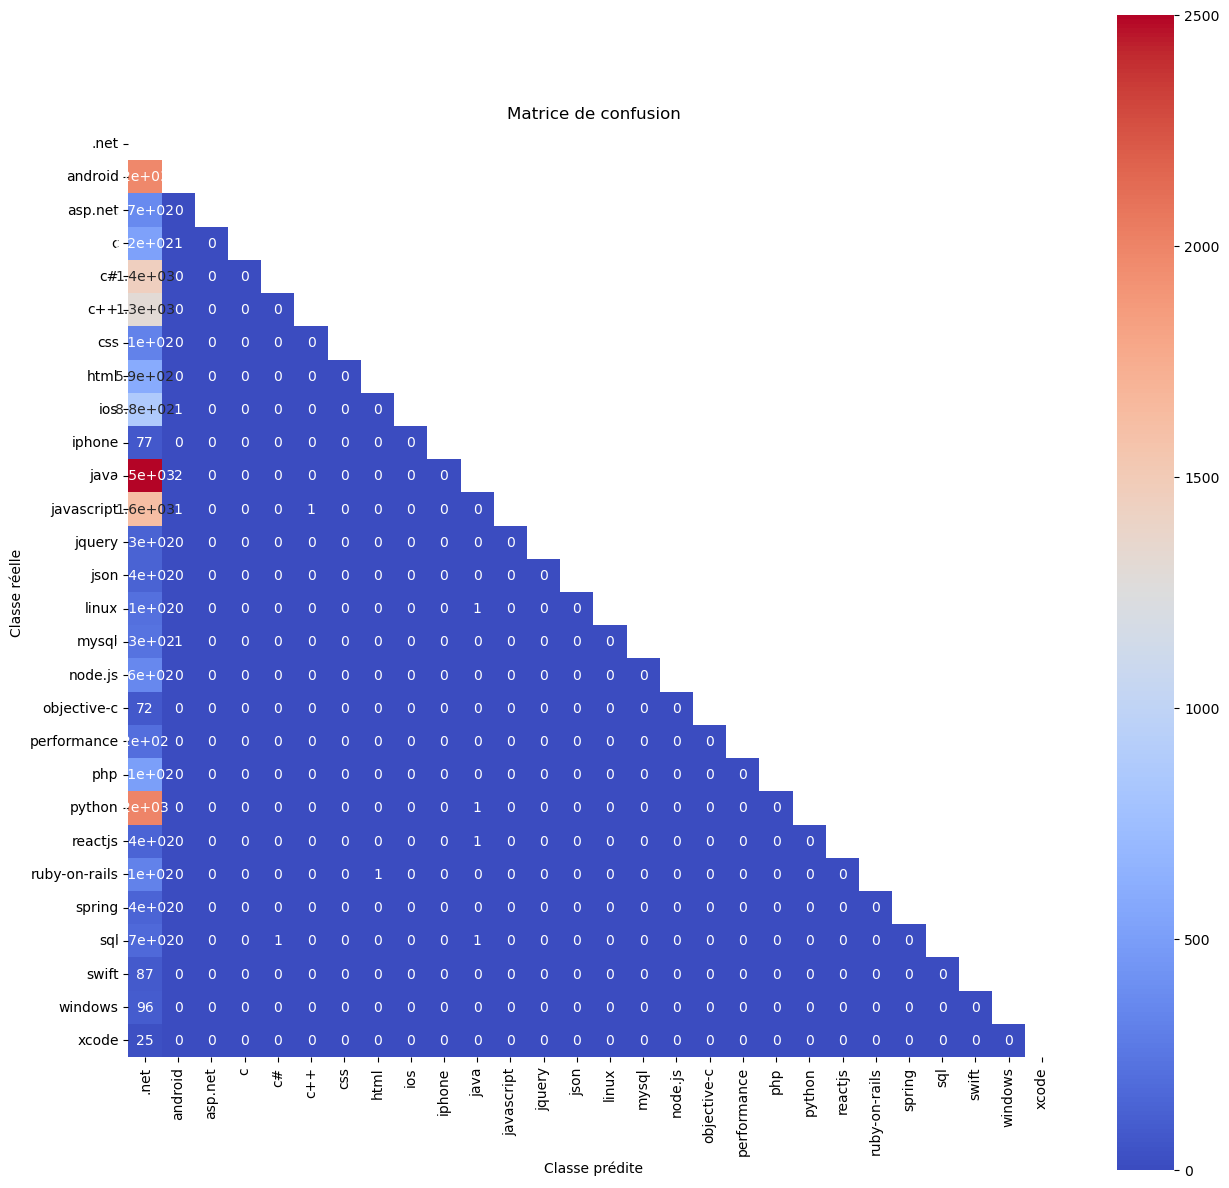

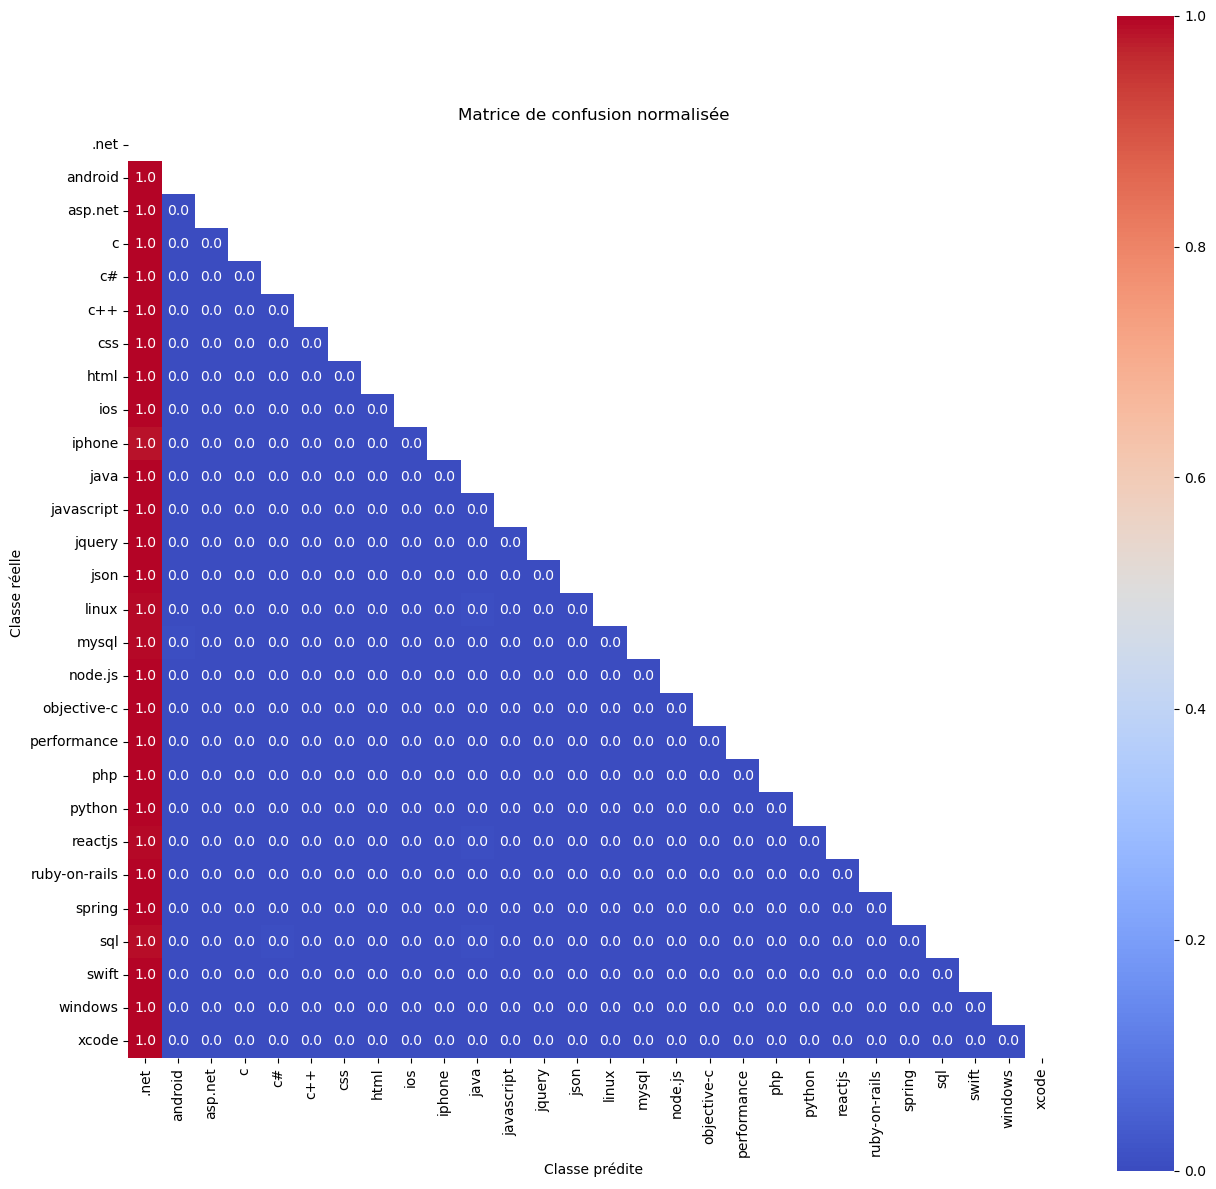

In [209]:
print('col_texte_brut =', col_texte_brut, '\n')

metriques_algo(y_test_in             = y_test_BERT,
               y_pred_in             = y_pred_BERT_randomforest,
               afficher_all_matrices = True)

# col_texte_brut = 'sentence_dl', batch_size = 1, max_length = 64, Test Set Accuracy = 

In [ ]:
#######################################
#        Algorithme LinearSVC         #
#######################################

In [210]:
y_pred_BERT_LinearSVC = algorithme_ovr(model_in                   = LinearSVC(),
                                       model_name_in              = 'LinearSVC',
                                       X_train_in                 = X_train_BERT, 
                                       y_train_in                 = y_train_BERT, 
                                       X_test_in                  = X_test_BERT,
                                       feature_extraction_type_in = 'BERT')

# col_texte_brut = 'sentence_dl', batch_size = 1, max_length = 64, Durée programme = 26.649 min

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 23177.648 --> stop : 24776.606 ) = 1598.958 sec ou 26.649 min



col_texte_brut = sentence_dl 

Test Set Accuracy	= 0.0 

F1 score		= 0.0 , average = micro
F1 score		= 0.0 , average = macro
F1 score		= 0.0 , average = samples
F1 score		= 0.0 , average = weighted


Jaccard score		= 0.0 , average = micro
Jaccard score		= 0.0 , average = macro
Jaccard score		= 0.0 , average = samples
Jaccard score		= 0.0 , average = weighted




C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification metrics =
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       883
           1       0.00      0.00      0.00      1983
           2       0.00      0.00      0.00       397
           3       0.00      0.00      0.00       532
           4       0.00      0.00      0.00      2332
           5       0.00      0.00      0.00      1485
           6       0.00      0.00      0.00       322
           7       0.00      0.00      0.00       753
           8       0.00      0.00      0.00       945
           9       0.00      0.00      0.00       191
          10       0.00      0.00      0.00      3096
          11       0.00      0.00      0.00      2223
          12       0.00      0.00      0.00       470
          13       0.00      0.00      0.00       295
          14       0.00      0.00      0.00       369
          15       0.00      0.00      0.00       284
          16       0.00      0.00      0.00       741
 

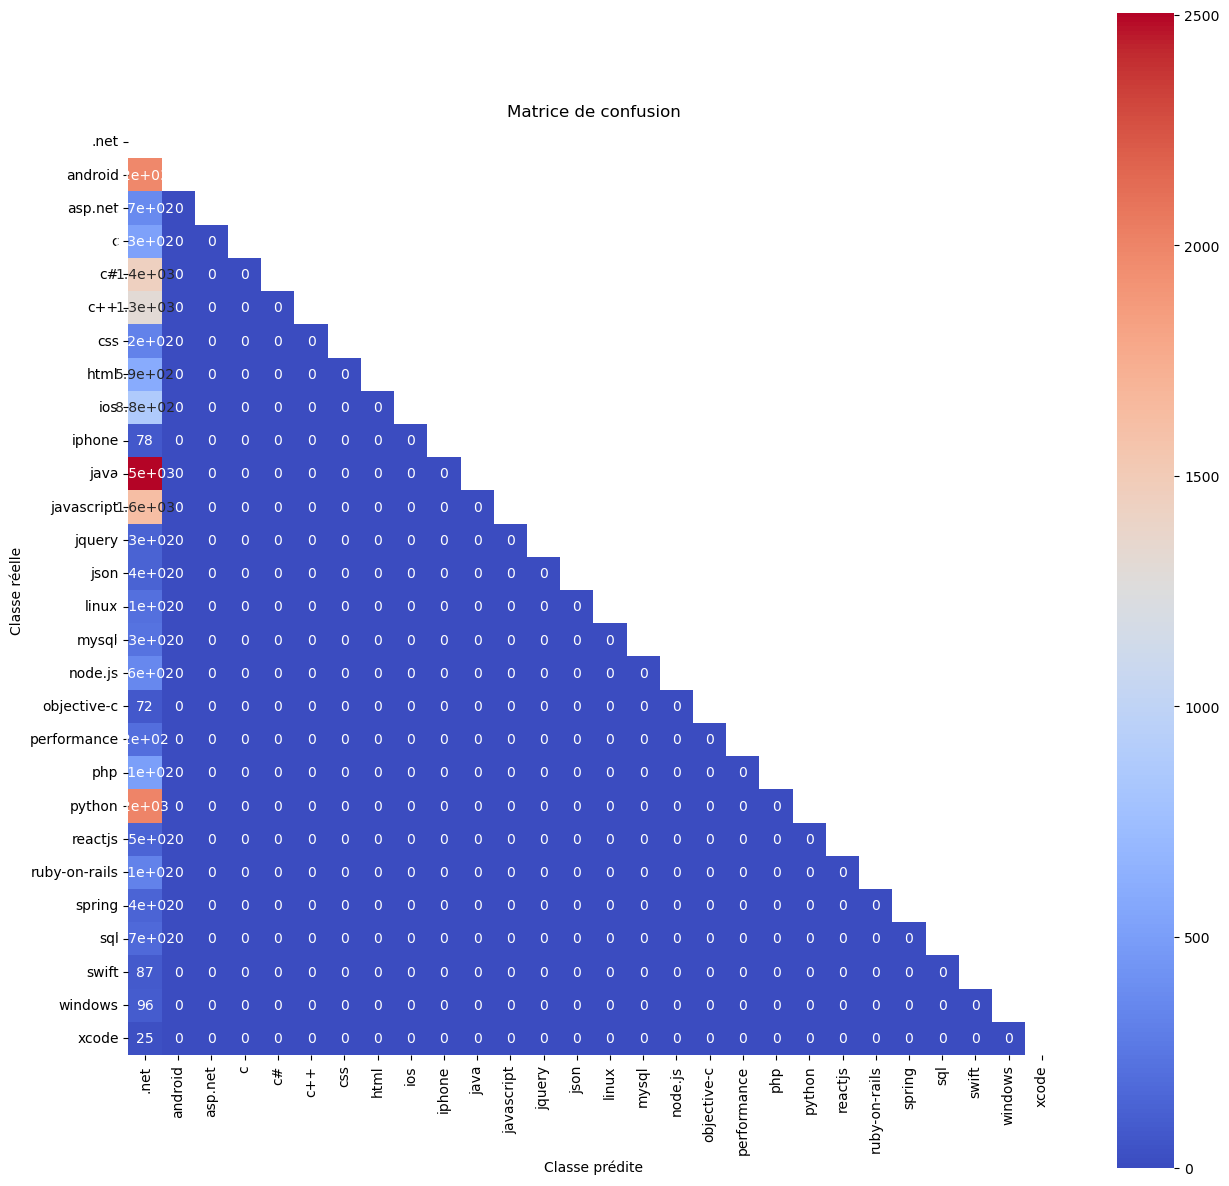

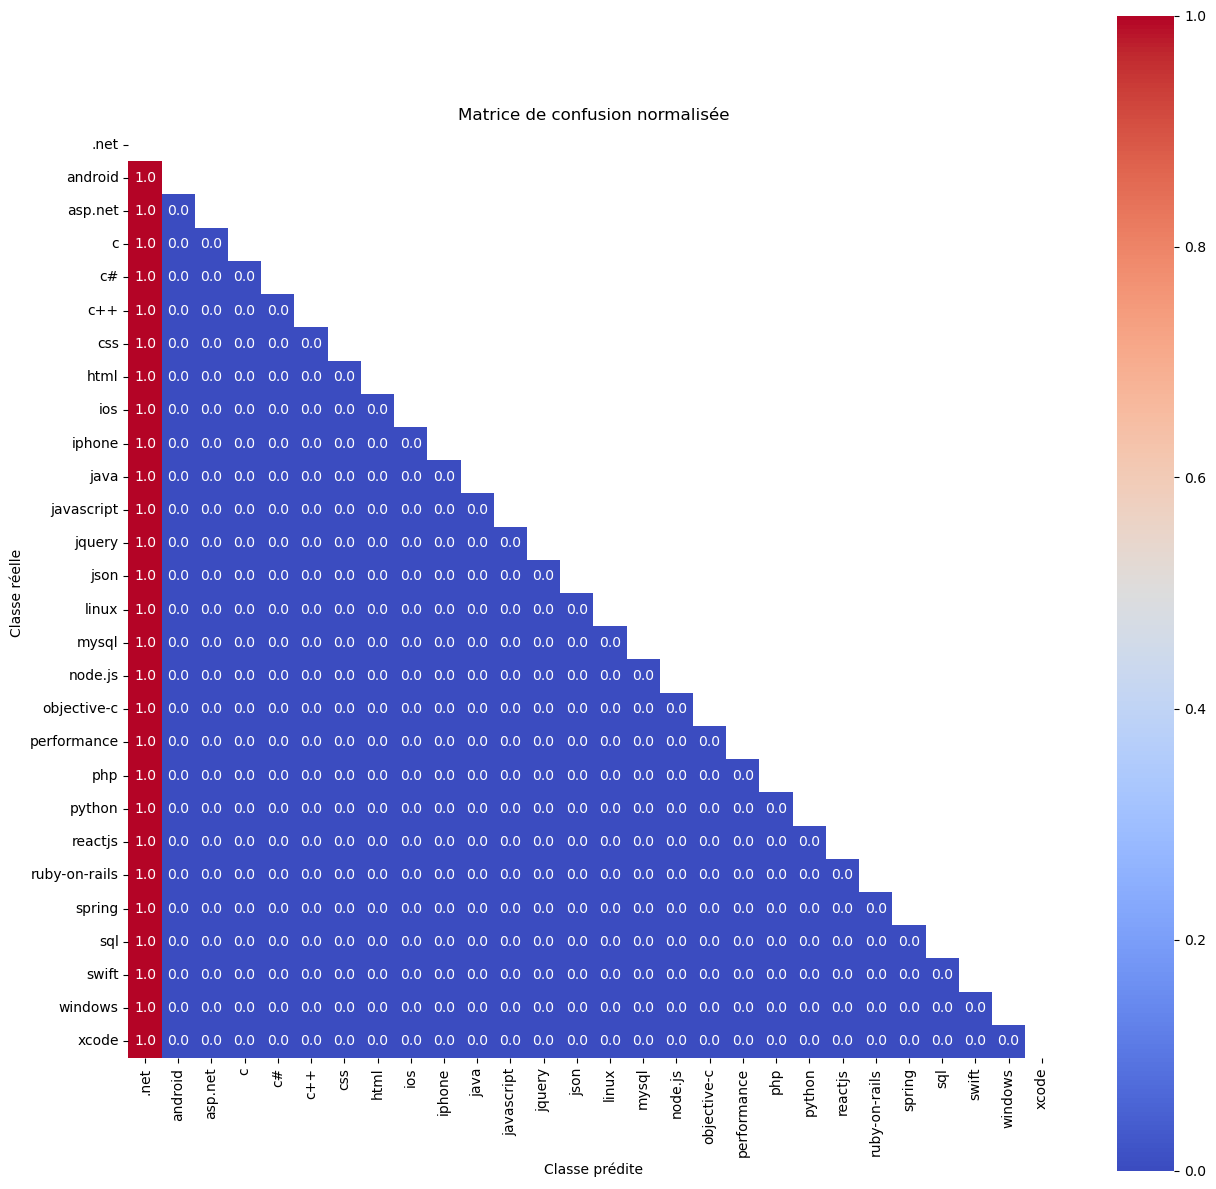

In [211]:
print('col_texte_brut =', col_texte_brut, '\n')

metriques_algo(y_test_in             = y_test_BERT,
               y_pred_in             = y_pred_BERT_LinearSVC,
               afficher_all_matrices = True)

# col_texte_brut = 'sentence_dl', batch_size = 1, max_length = 64, Test Set Accuracy =